## 2 - Export Data Assessment (GUI Data)

##### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as su
import ast
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd

##### Data Loading

In [2]:
# Load ddfs into dictionary (exception for 'all_surf_pos', df)
root_dir = './aggregated_data'
def load_data(root_dir, exception=False):    # Get csv file reads into one dictionary
    data = {}
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            file_name = os.path.splitext(file)[0]   #file name without '.csv'
            if file.endswith('.csv') and file != 'all_surf_positions_HiDrive_Studie2.csv':
                data[file_name] = dd.read_csv(file_path)    #read and attach to dict
            elif exception and file == 'all_surf_positions_HiDrive_Studie2.csv':
                data [file_name] = pd.read_csv(file_path, converters=converters)    #read as normal and attach to dict
    return data
def parse(filedata): # Manually read the column
    output = []
    for line in filedata.split('\n'): # split into lines
        line = line.strip().rstrip(']').lstrip('[') #remove whitespace and brackets
        if not line:  
            continue    #skip empty lines
        line = line.split() #split into cell
        row = []
        for cell in line:
            cell = cell.strip()     #remove whitespace
            if not cell.strip():
                continue    #skip empty cells
            row.append(float(cell)) #convert to float and add
        output.append(row)
    return output
converters = {
    "img_to_surf_trans": parse,
    "surf_to_img_trans": parse,
    "dist_img_to_surf_trans": parse,
    "surf_to_dist_img_trans": parse,
}

data = load_data(root_dir)

In [3]:
participant_ids = [1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ddf = data['all_gui_data']
df = ddf.compute()
df['block_data'] = df['block_data'].apply(lambda x: eval(x))

### 1. Basic statistics
- Only 6 blocks in P01 -> Recording interrupted
- Higher reaction time, completion time and errors in P05 -> Just slower tha others

In [4]:
display(df.iloc[:, 1:].describe())

block_id   block_type      task_id  start_timestamp  reaction_time  \
count  1320.000000  1320.000000  1320.000000     1.320000e+03    1320.000000   
mean      4.704545     4.684848     5.567424     1.711031e+09       1.199770   
std       2.262322     2.300229     3.665506     4.345978e+05       0.683389   
min       1.000000     1.000000     1.000000     1.710323e+09       0.232422   
25%       3.000000     2.000000     3.000000     1.710774e+09       0.751183   
50%       5.000000     5.000000     5.000000     1.711035e+09       1.134766   
75%       7.000000     6.000000     8.000000     1.711467e+09       1.479014   
max       8.000000     8.000000    18.000000     1.711630e+09       8.175781   

       clicked_timestamp  completion_time  end_timestamp       errors  
count       1.320000e+03      1320.000000   1.320000e+03  1320.000000  
mean        1.711031e+09        25.504475   1.711031e+09     0.200758  
std         4.345976e+05        13.291043   4.345946e+05     0.564155  
min         1.710323e+09         7.255859   1.710323e+09     0.000000  
25%         1.710774e+09        16.585598   1.710774e+09     0.000000  
50%         1.711035e+09        22.205724   1.711035e+09     0.000000  
75%         1.711467e+09        30.471418   1.711467e+09     0.000000  
max         1.711630e+09       131.046875   1.711630e+09     4.000000

In [43]:
# Mean block duration
df['block_duration'] = df['block_data'].apply(lambda x: x[1])
print("BLOCK DURATION")
print(f"Mean: {df['block_duration'].unique().mean()}")
print(f"Std:  {df['block_duration'].unique().std()}")

BLOCK DURATION
Mean: 330.92008245342504
Std:  32.61587846524015


In [41]:
# Mean tasks per block
tpb = (
    df.groupby(['participant_id', 'block_id'])
    .size()
).reset_index(name="task_count")
print("TASKS PER BLOCK")
print(f"Mean: {tpb["task_count"].mean()}")
print(f"Std:  {tpb["task_count"].std()}")

TASKS PER BLOCK
Mean: 8.68421052631579
Std:  3.5610495004688048


### 2. Quality Assessment
Task block, Completion time, Reaction time and Errors distributions +correlations +boxplots

##### Task block duration distribution
- Longer in P01 and P05

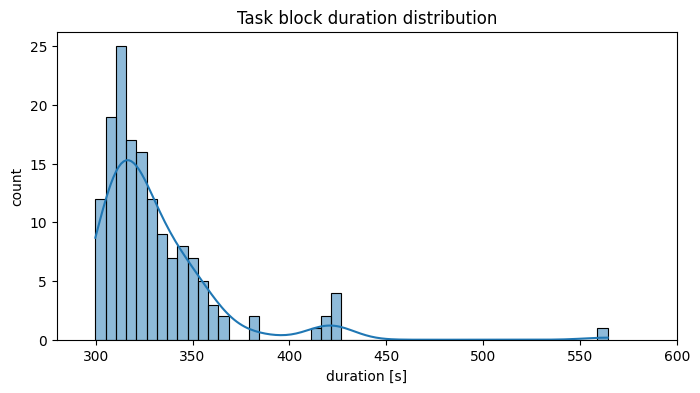

In [42]:
block_durations = pd.concat([group.head(1) for _, group in df.groupby(['participant_id', 'block_id'])])['block_data'].apply(lambda x: x[1])
plt.figure(figsize=(8, 4))
sns.histplot(block_durations, bins=50, kde=True, )
plt.title(f'Task block duration distribution')
plt.xlabel('duration [s]')
plt.ylabel('count')
plt.xlim(280, 600)
plt.show()

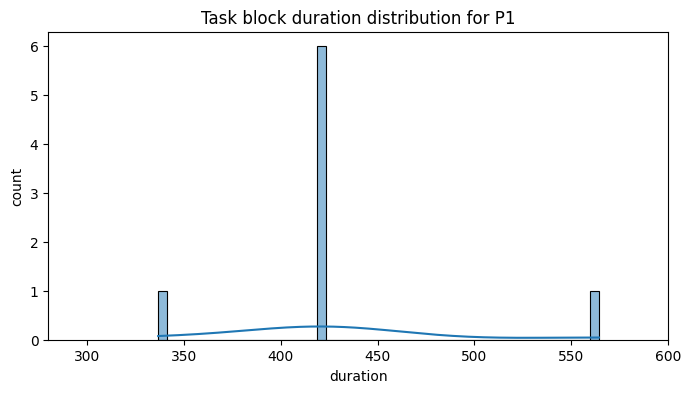

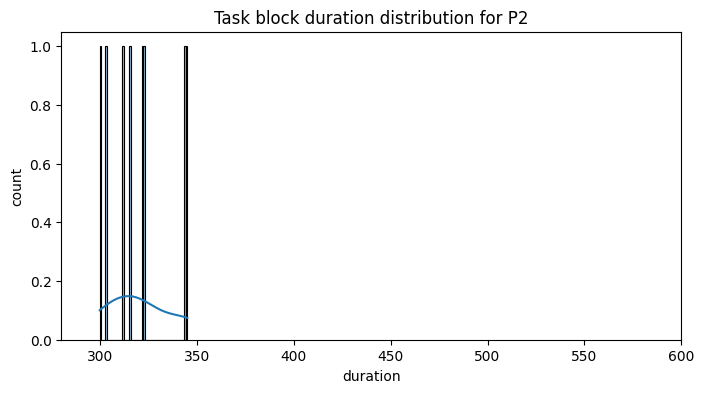

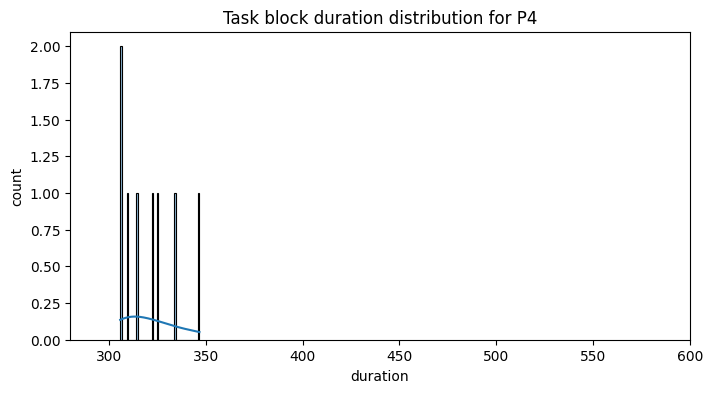

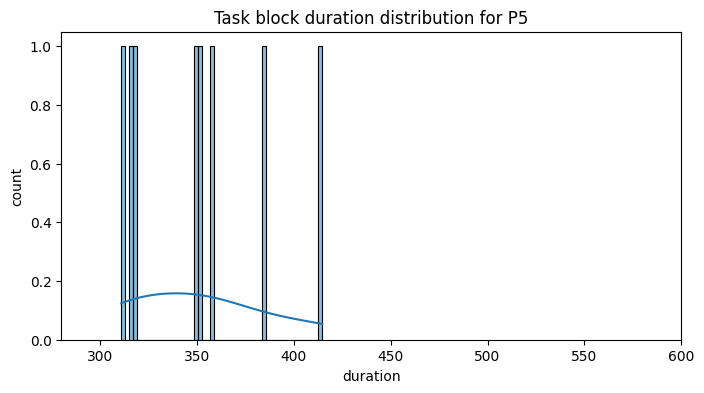

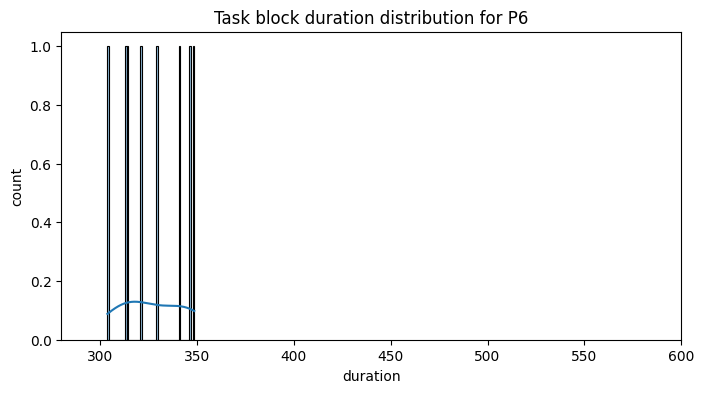

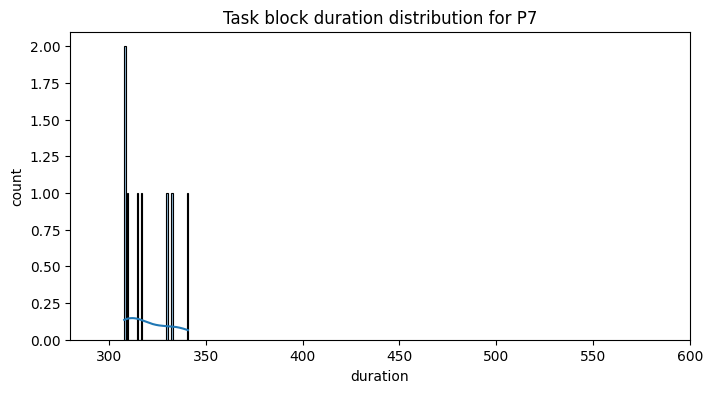

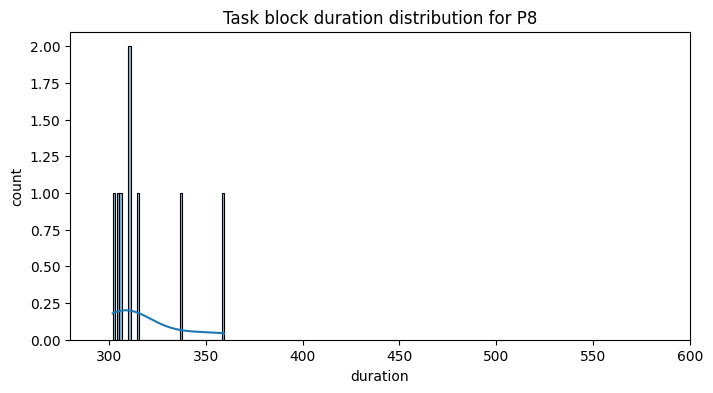

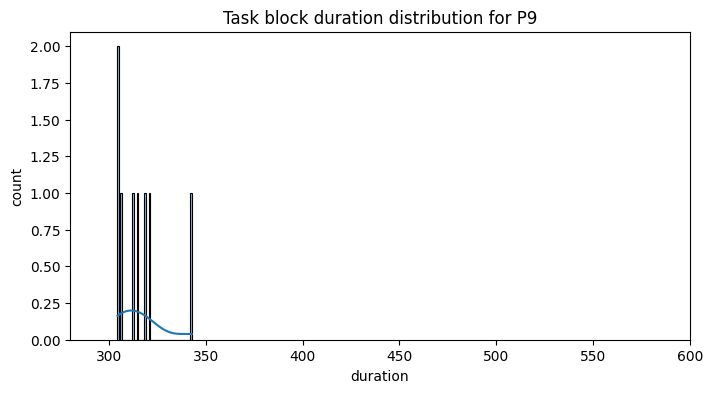

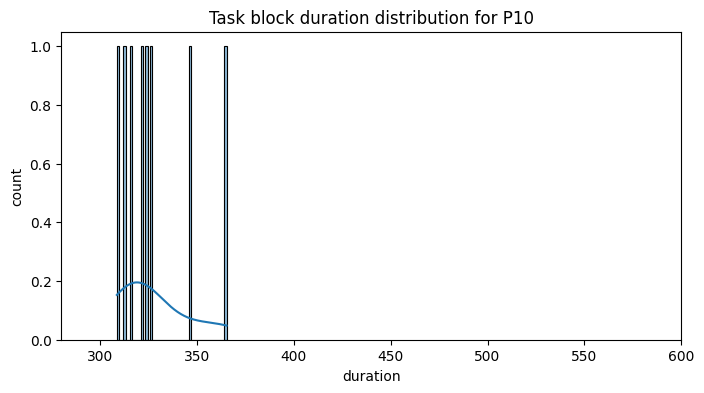

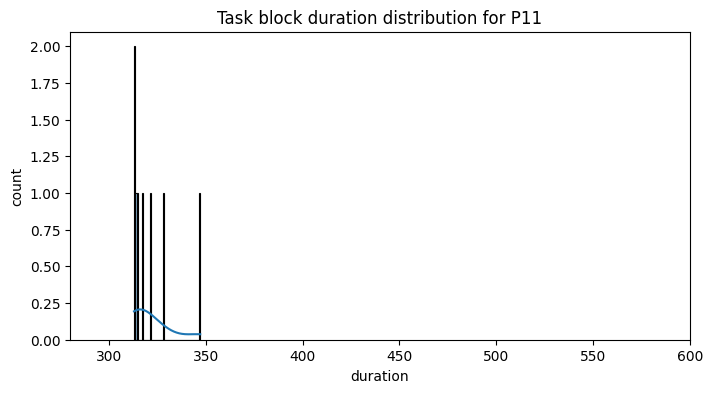

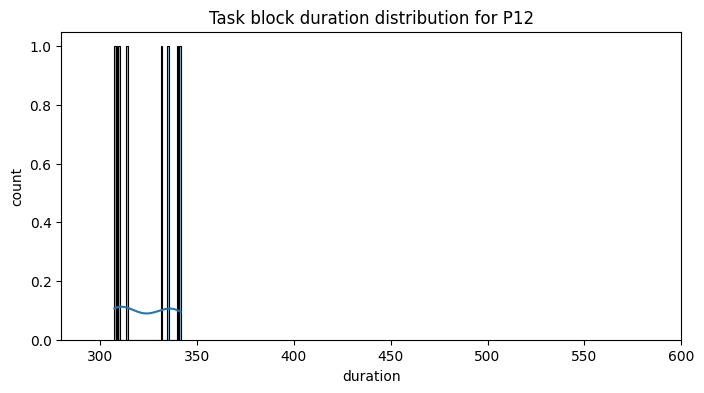

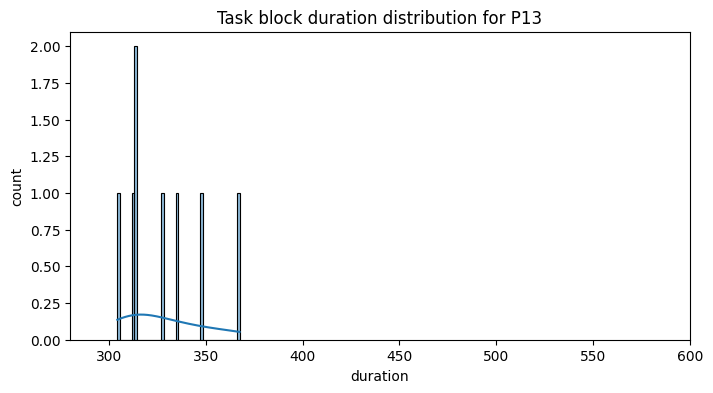

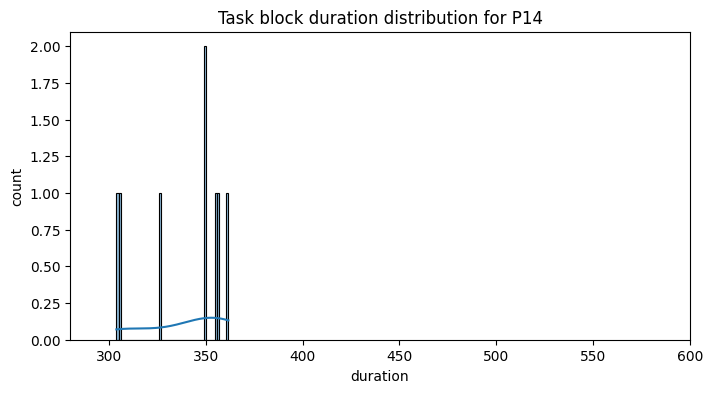

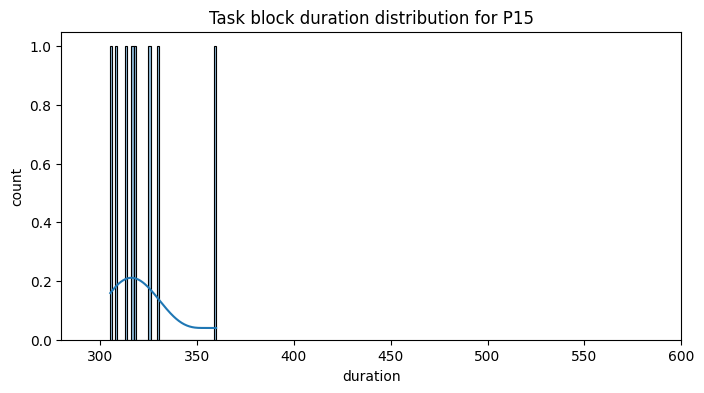

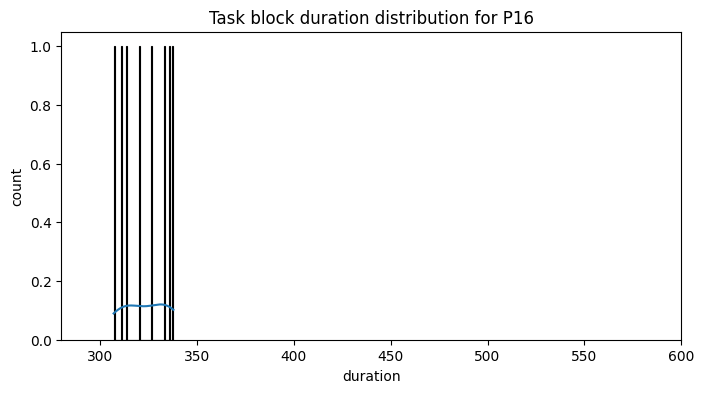

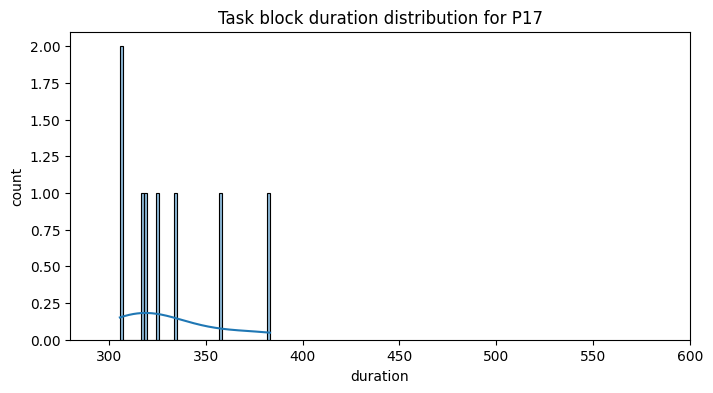

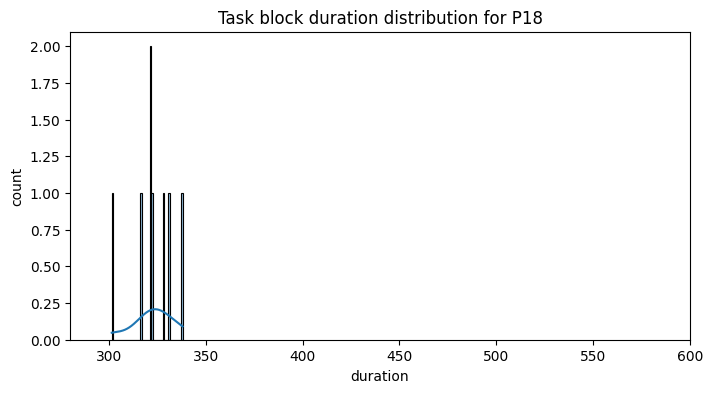

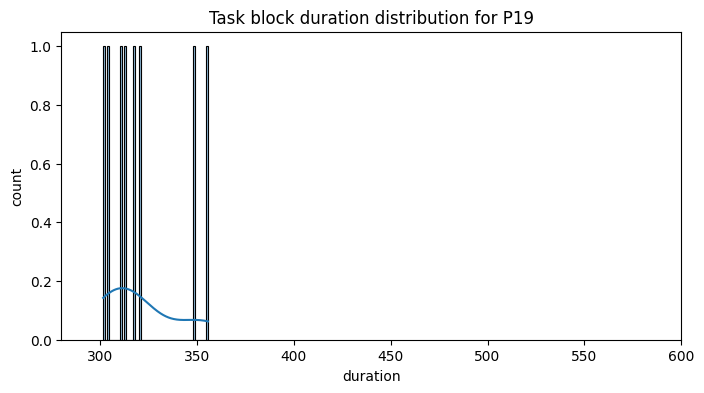

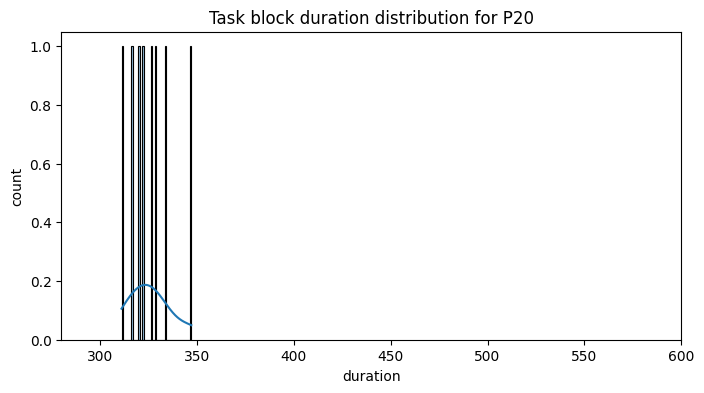

In [8]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    block_durations = pd.concat([group.head(1) for _, group in participant_df.groupby('block_id')])['block_data'].apply(lambda x: x[1])
    plt.figure(figsize=(8, 4))
    sns.histplot(block_durations, bins=50, kde=True, )
    plt.title(f'Task block duration distribution for P{pid}')
    plt.xlabel('duration')
    plt.ylabel('count')
    plt.xlim(280, 600)
    plt.show()

##### Tasks per block distribution
- ...

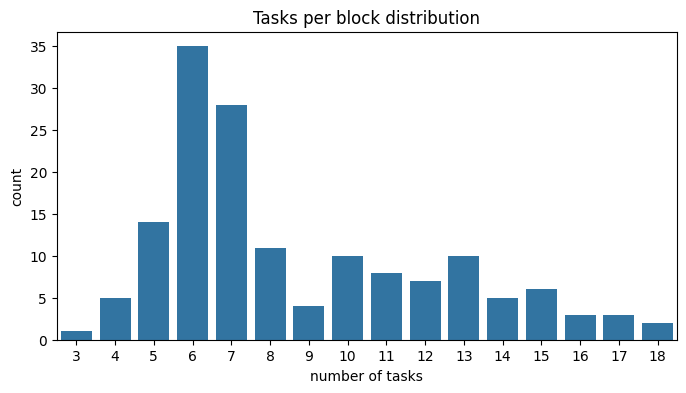

In [53]:
plt.figure(figsize=(8, 4))
sns.countplot(
    x=tpb['task_count'],
    order=sorted(tpb['task_count'].dropna().unique())
)
plt.title(f'Tasks per block distribution')
plt.xlabel('number of tasks')
plt.ylabel('count')
plt.show()

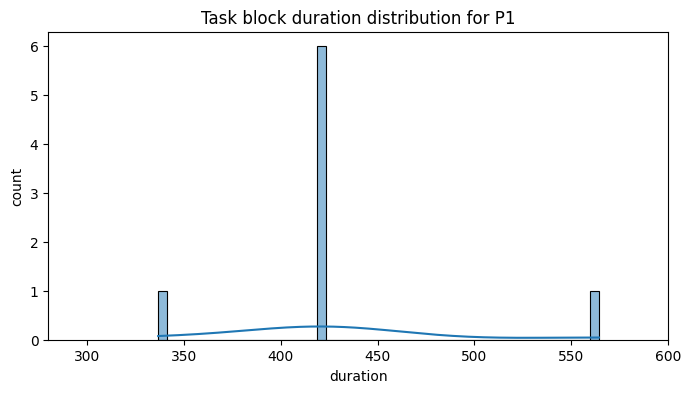

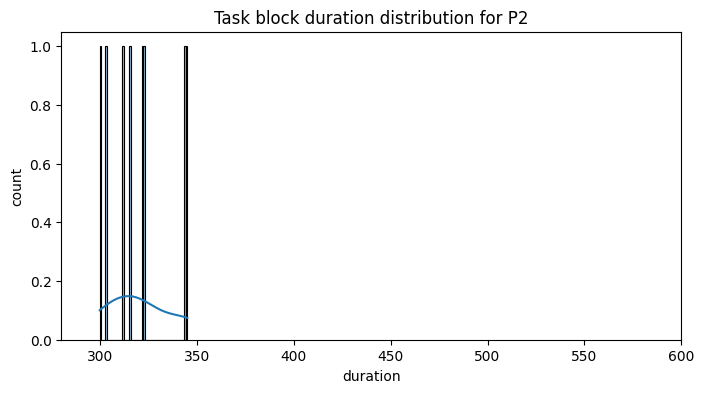

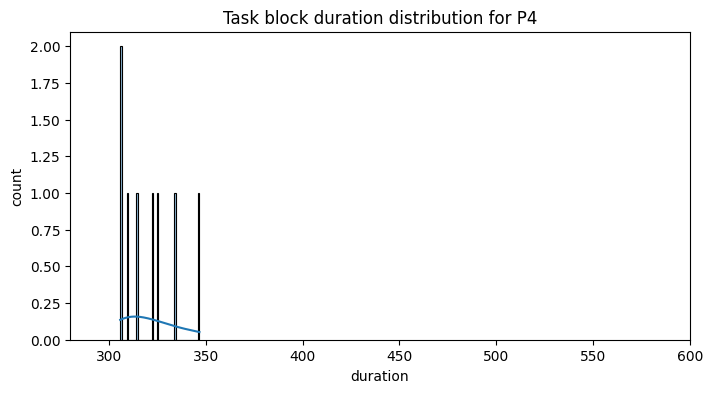

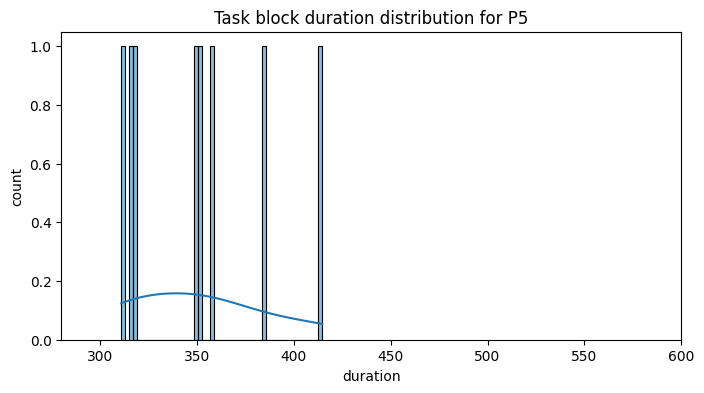

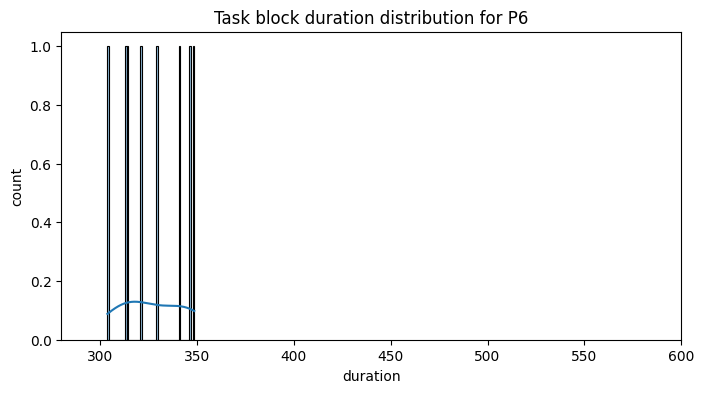

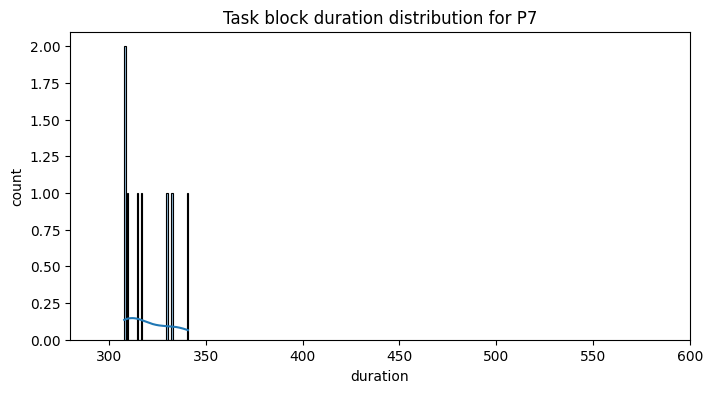

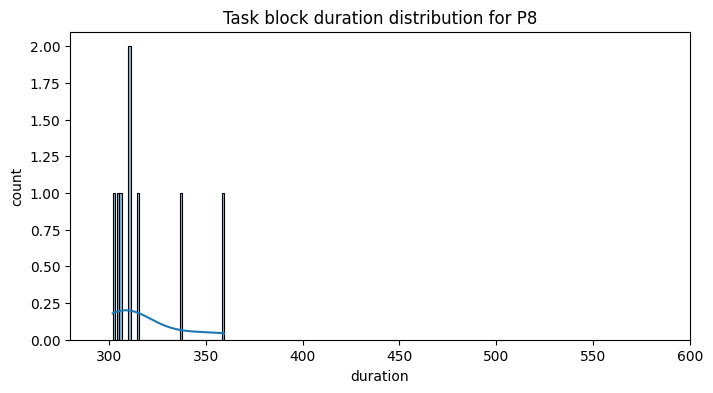

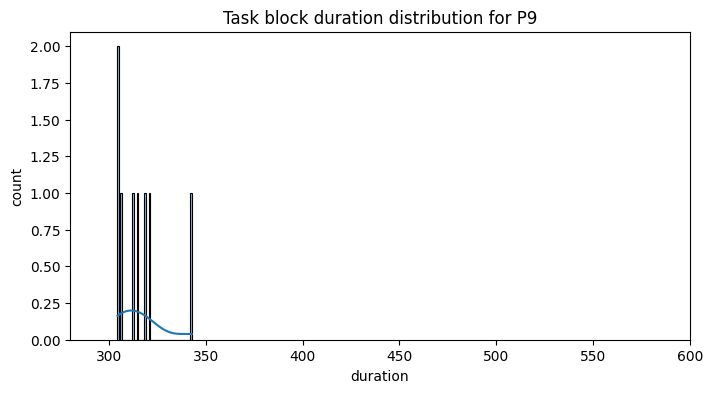

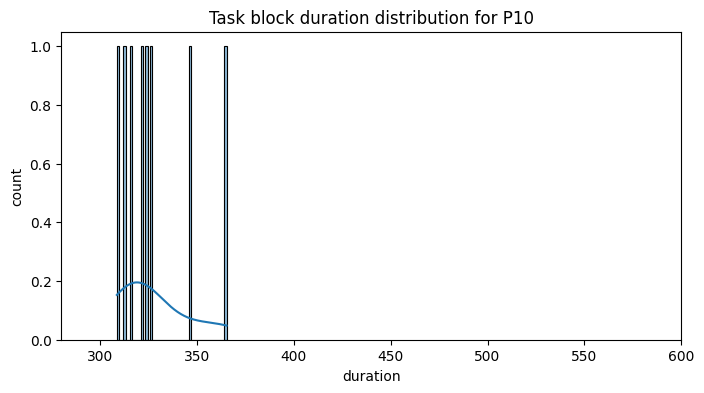

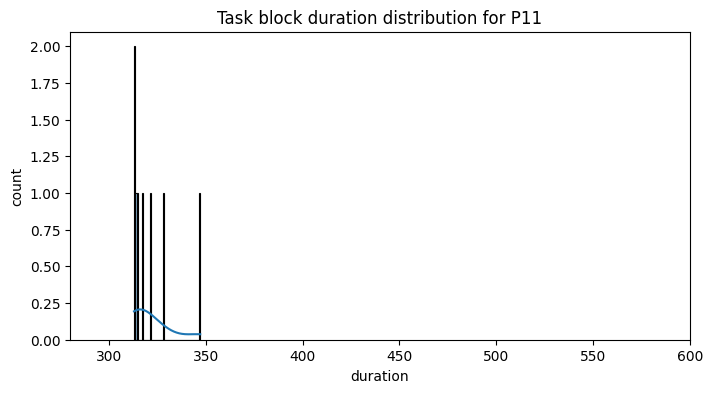

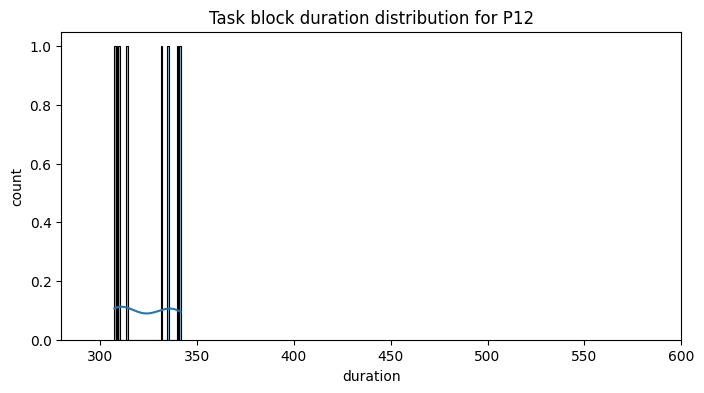

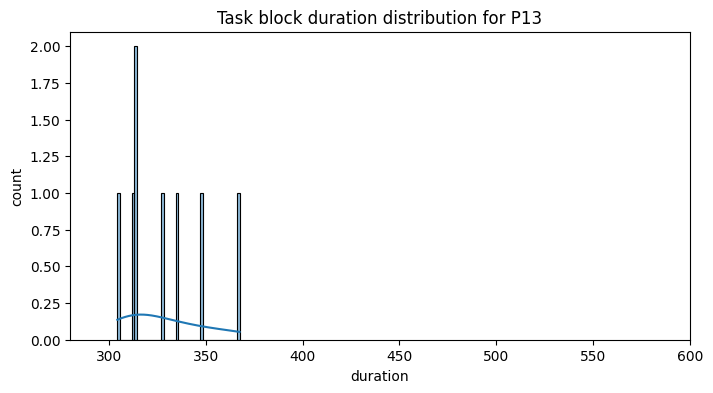

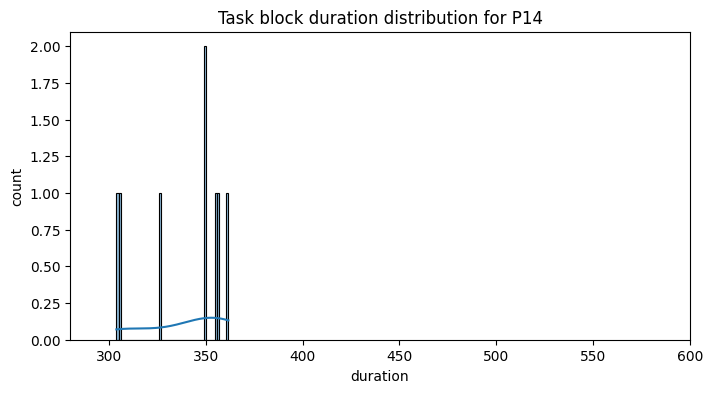

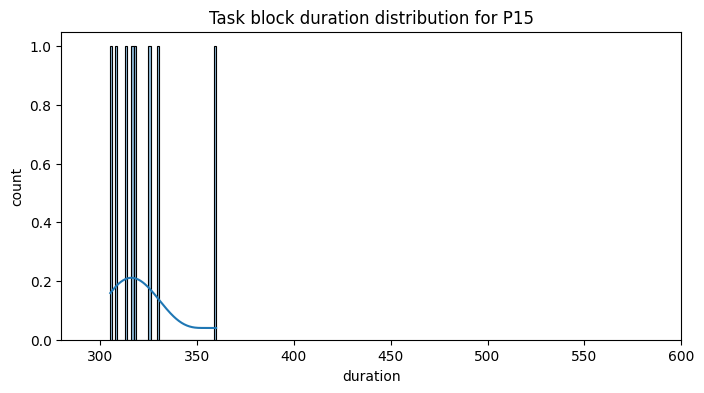

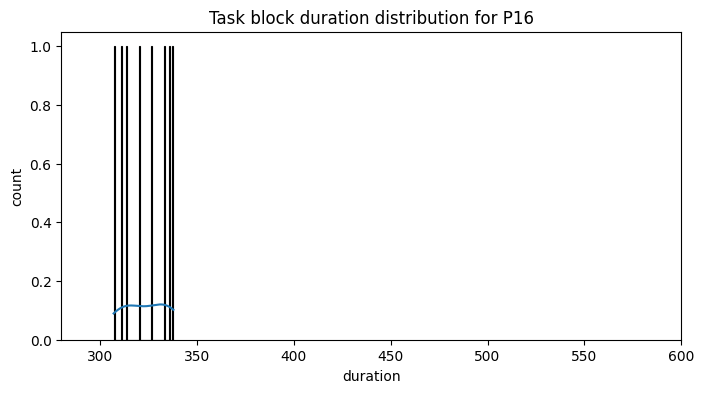

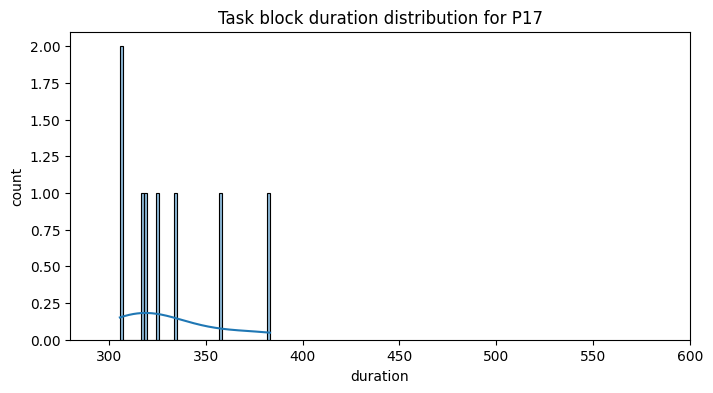

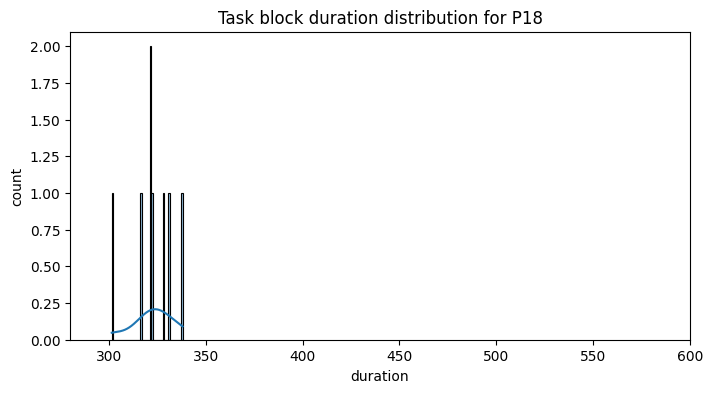

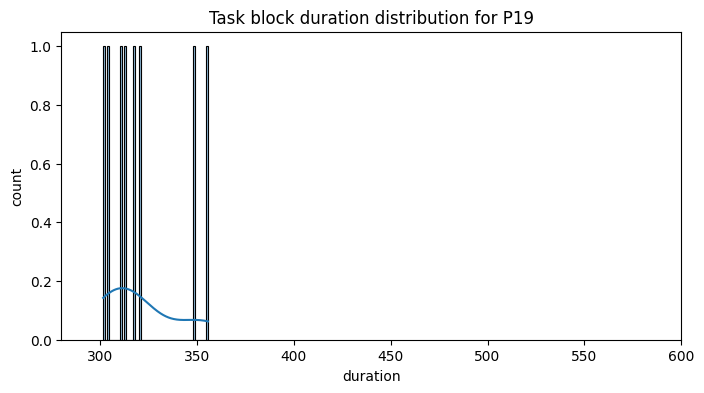

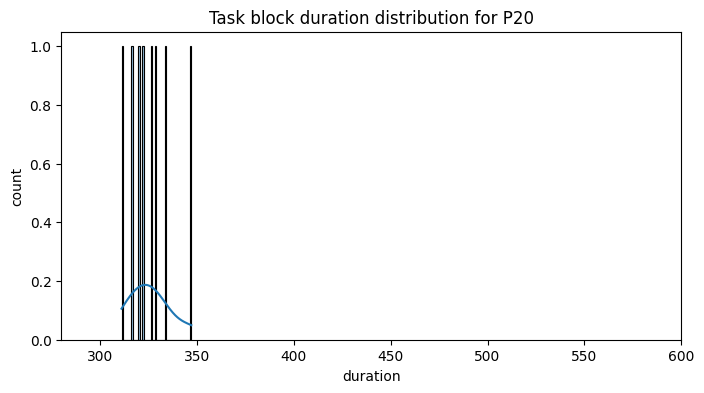

In [ ]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    block_durations = pd.concat([group.head(1) for _, group in participant_df.groupby('block_id')])['block_data'].apply(lambda x: x[1])
    plt.figure(figsize=(8, 4))
    sns.histplot(block_durations, bins=50, kde=True, )
    plt.title(f'Task block duration distribution for P{pid}')
    plt.xlabel('duration')
    plt.ylabel('count')
    plt.xlim(280, 600)
    plt.show()

##### Completion time distribution
- Longer in P01 and P05

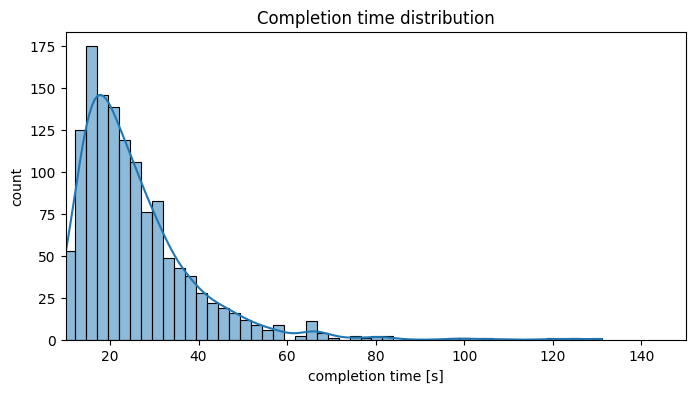

In [44]:
plt.figure(figsize=(8, 4))
sns.histplot(df['completion_time'], bins=50, kde=True, )
plt.title(f'Completion time distribution')
plt.xlabel('completion time [s]')
plt.ylabel('count')
plt.xlim(10, 150)
plt.show()

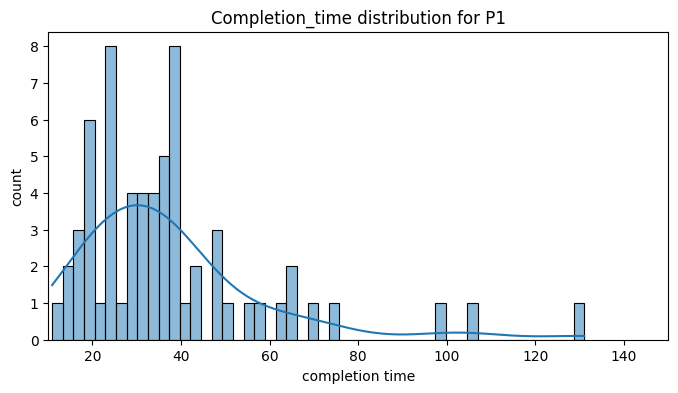

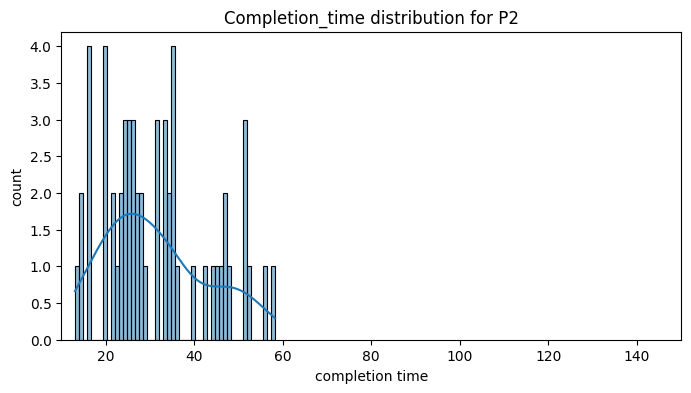

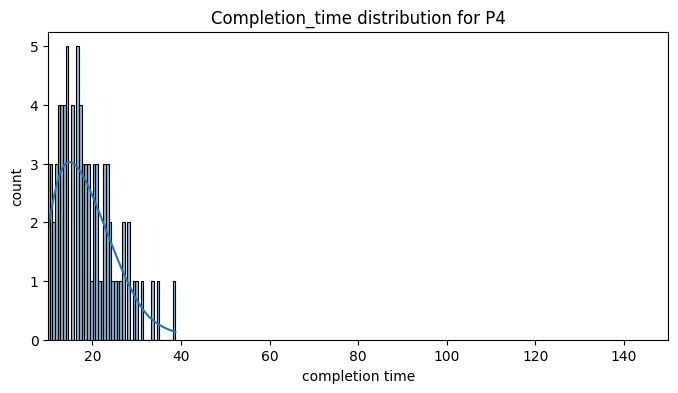

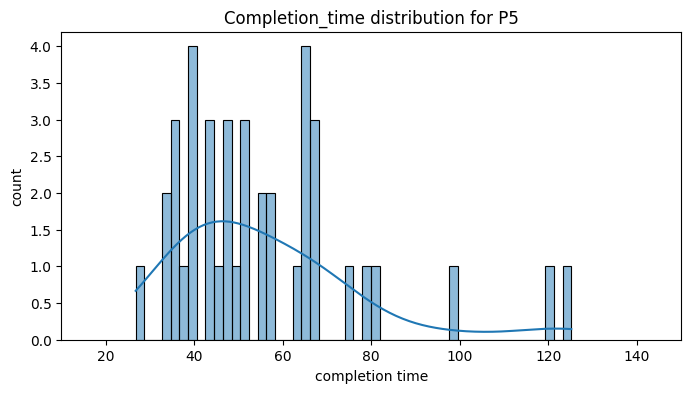

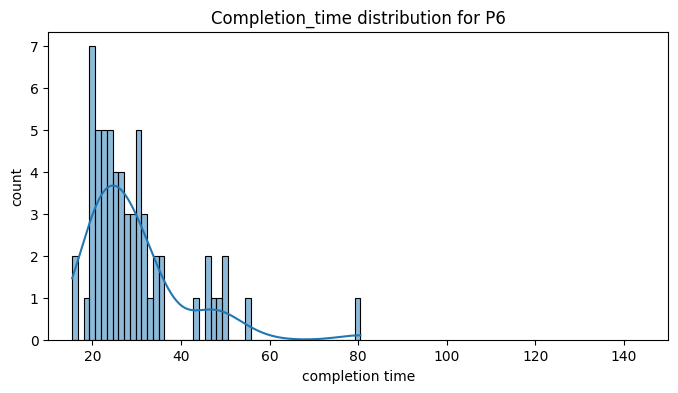

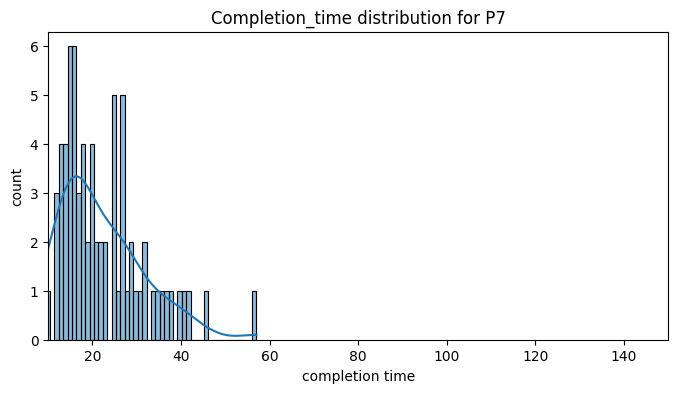

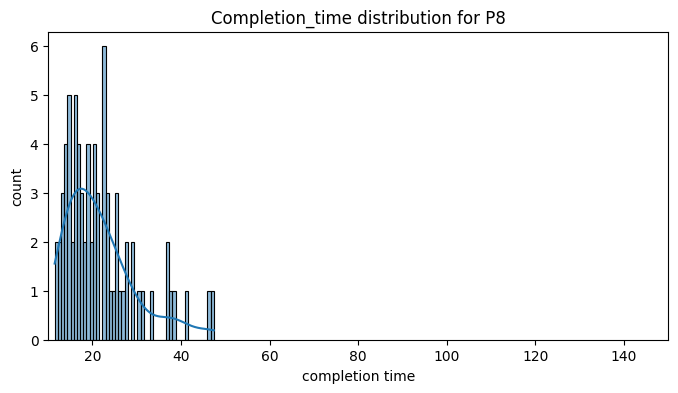

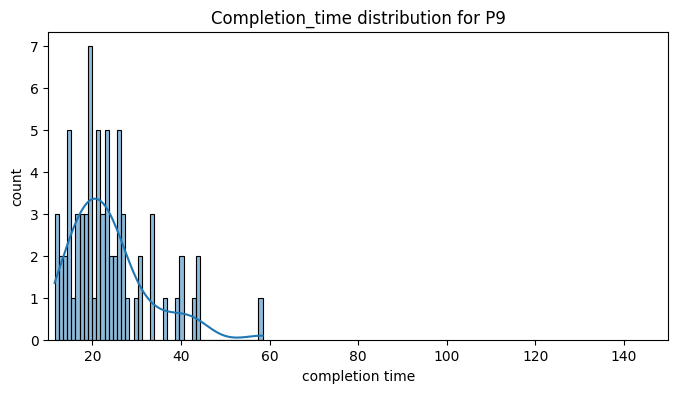

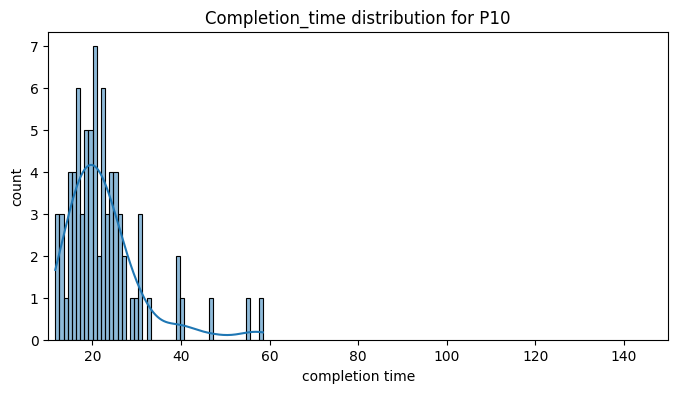

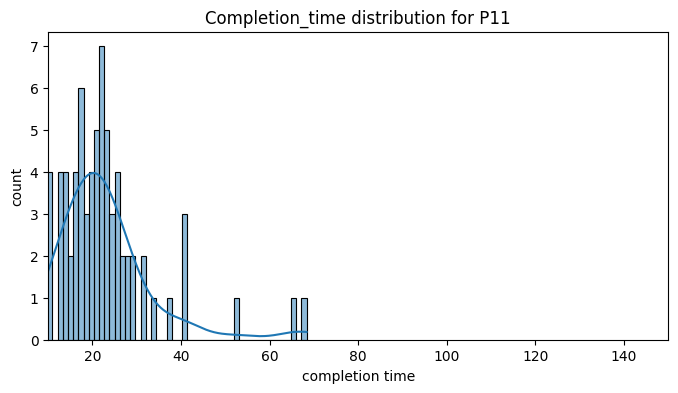

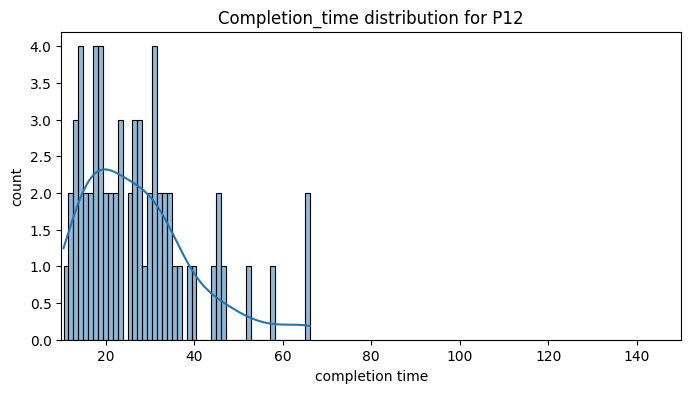

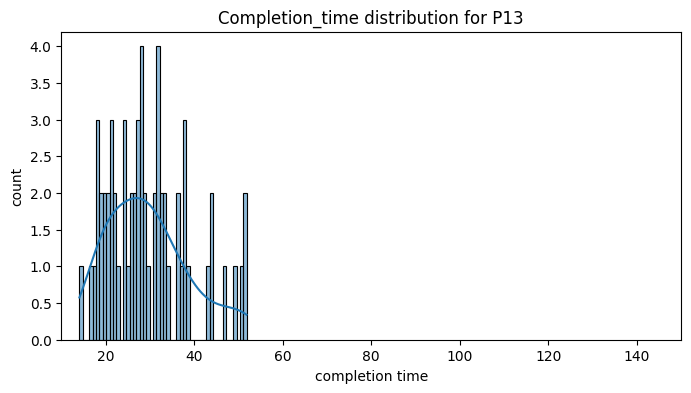

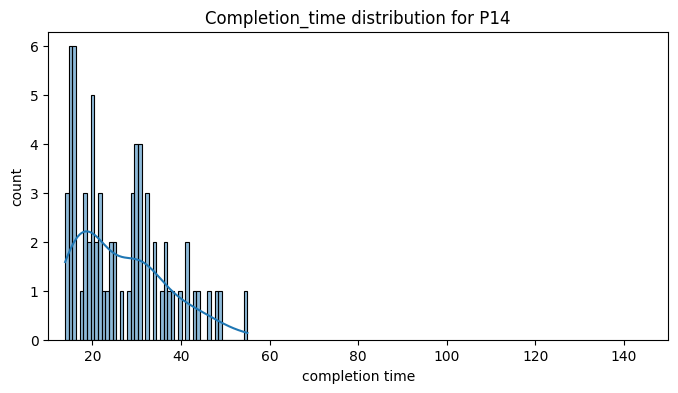

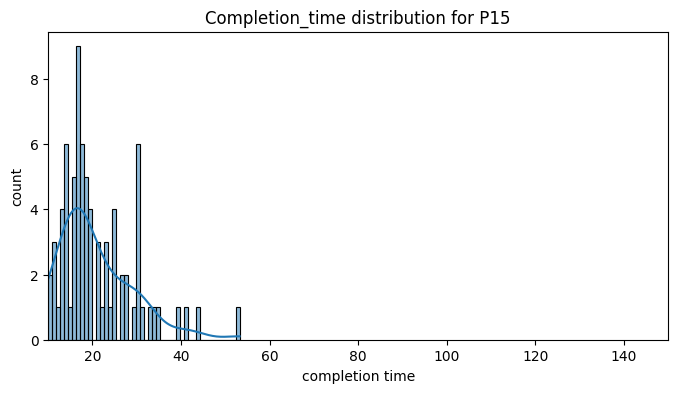

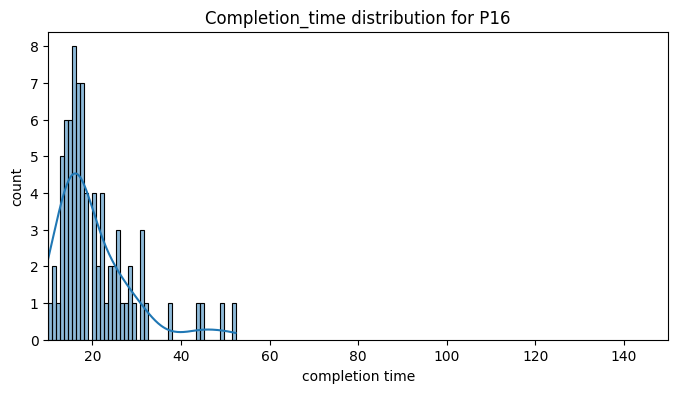

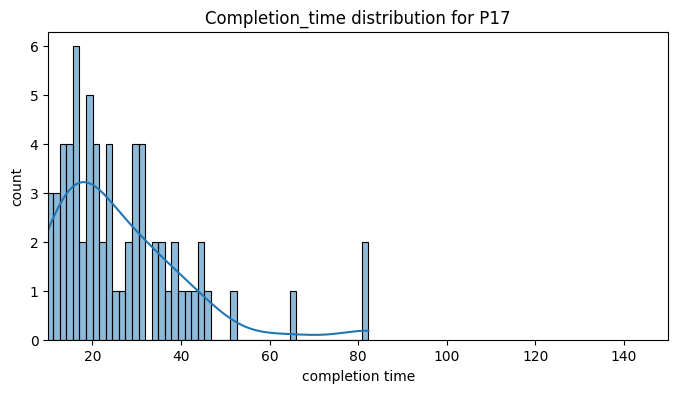

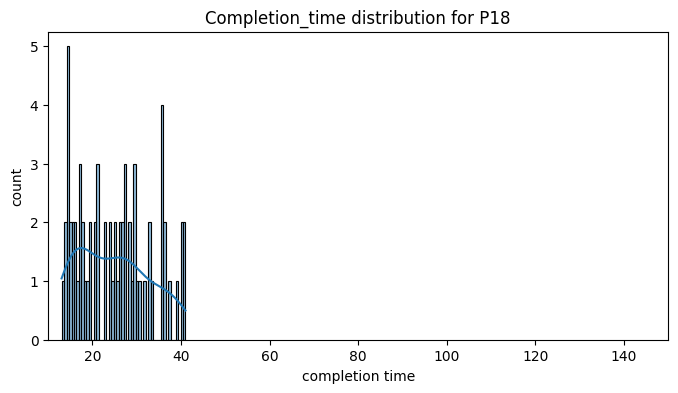

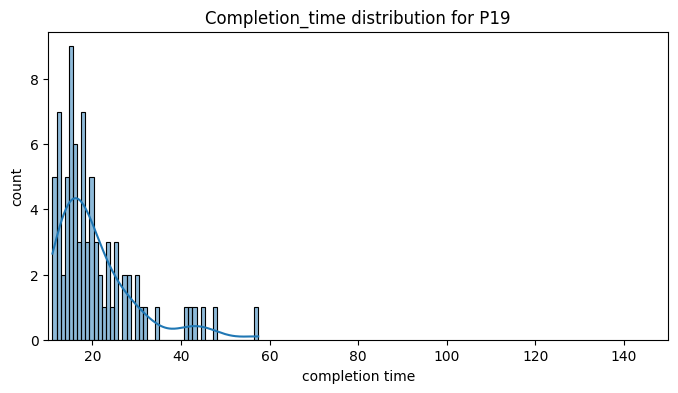

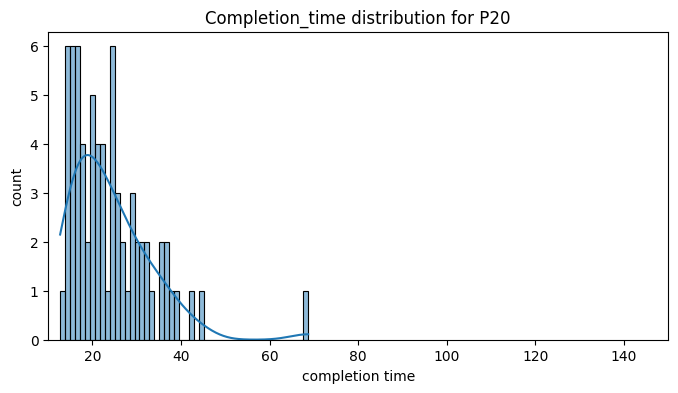

In [9]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    sns.histplot(participant_df['completion_time'], bins=50, kde=True, )
    plt.title(f'Completion_time distribution for P{pid}')
    plt.xlabel('completion time')
    plt.ylabel('count')
    plt.xlim(10, 150)
    plt.show()

##### Reaction time distribution
- Check long RT, distraction?

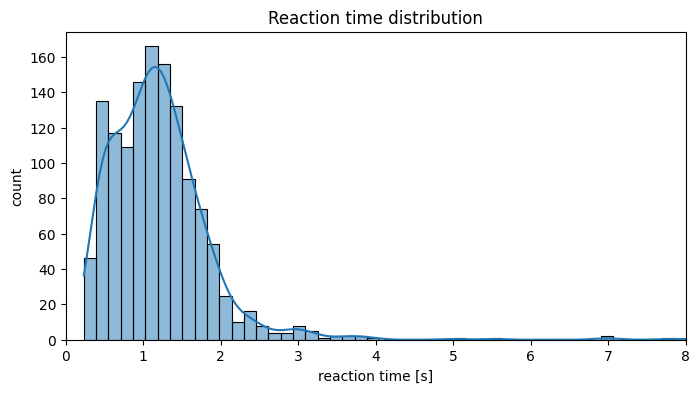

In [43]:
plt.figure(figsize=(8, 4))
sns.histplot(df['reaction_time'], bins=50, kde=True, )
plt.title(f'Reaction time distribution')
plt.xlabel('reaction time [s]')
plt.ylabel('count')
plt.xlim(0, 8)
plt.show()

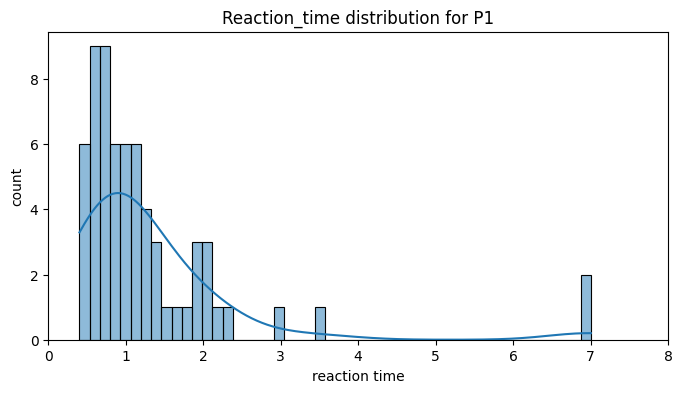

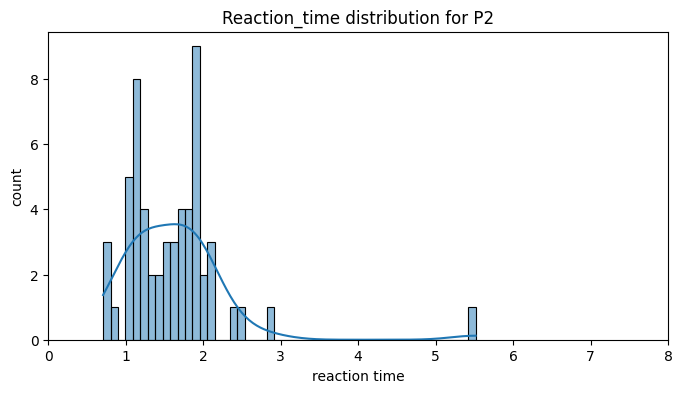

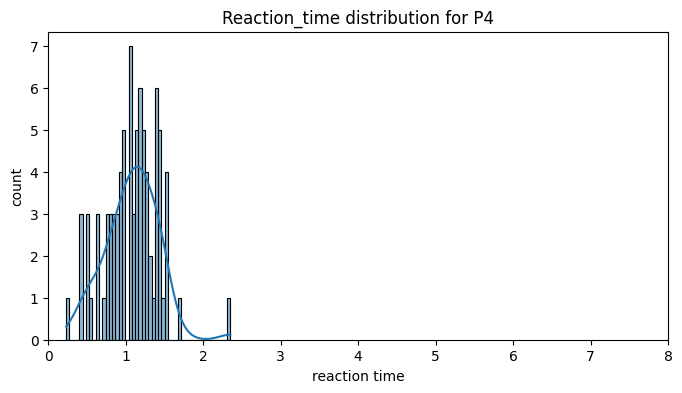

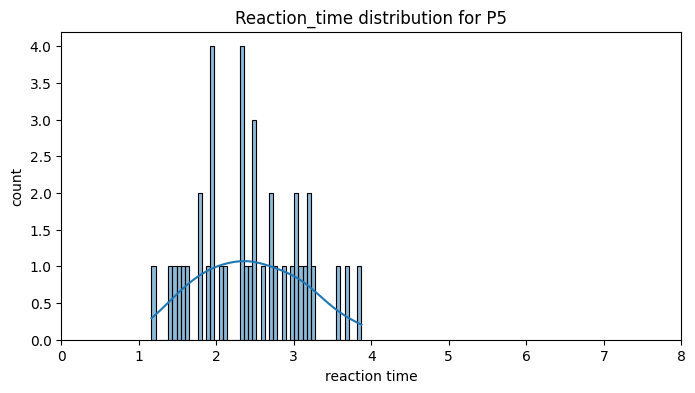

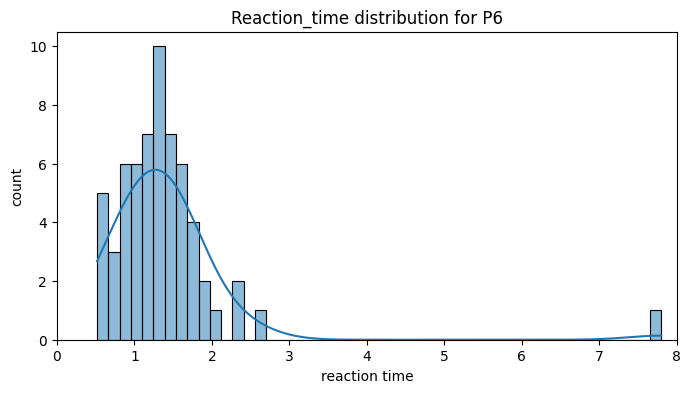

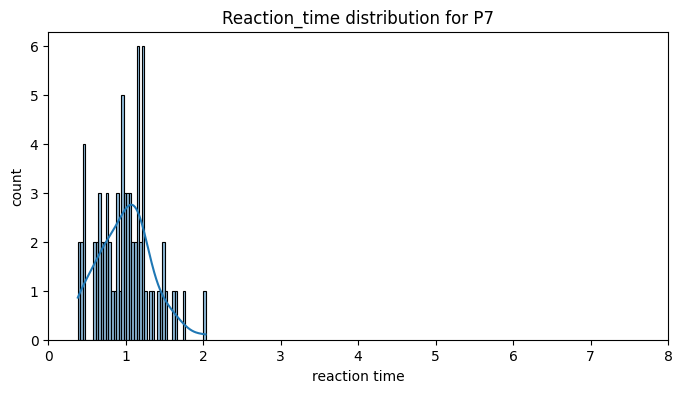

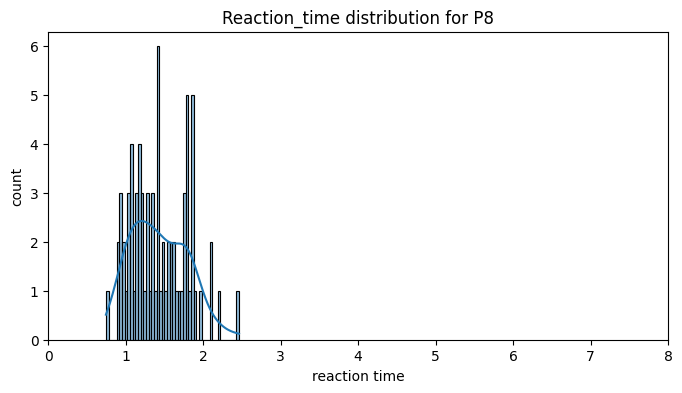

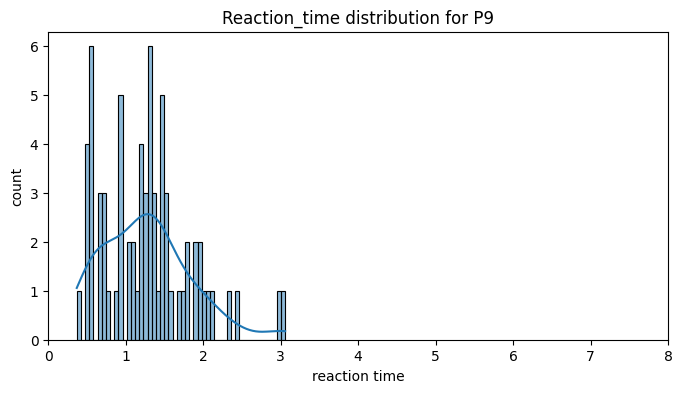

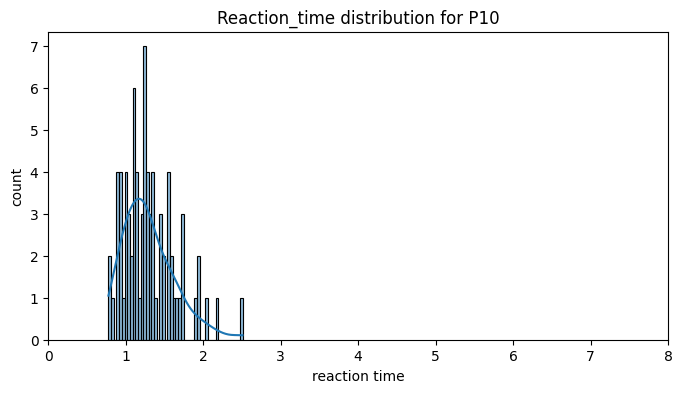

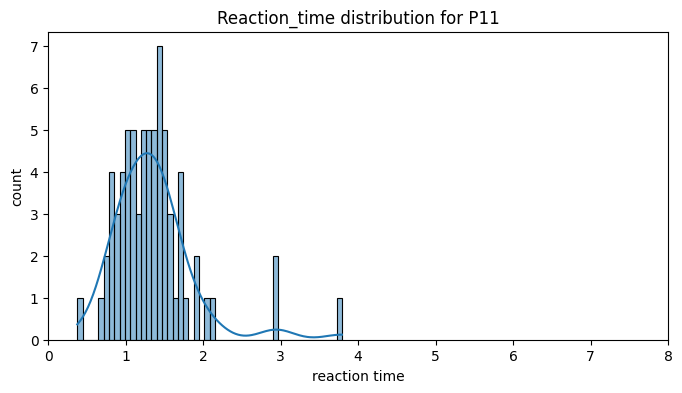

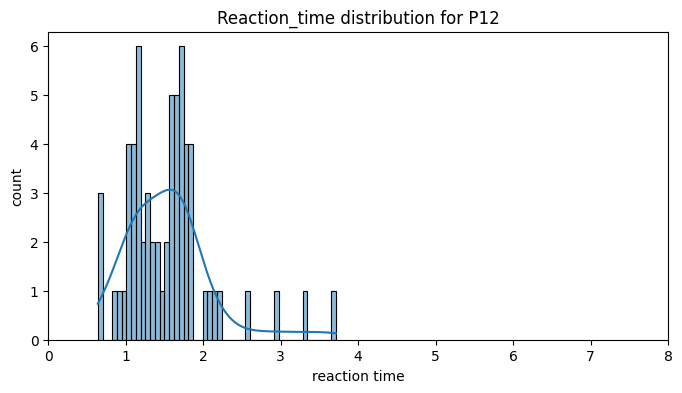

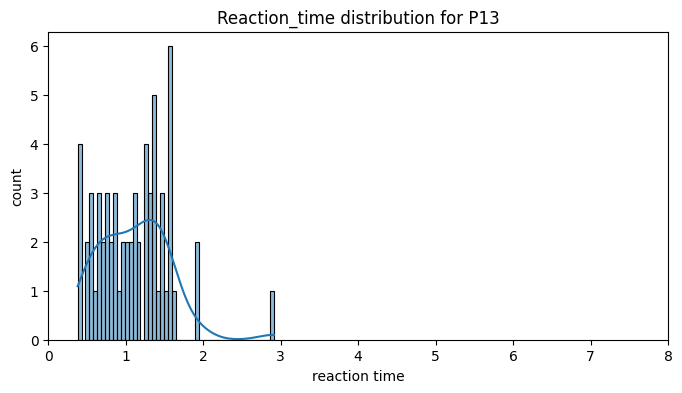

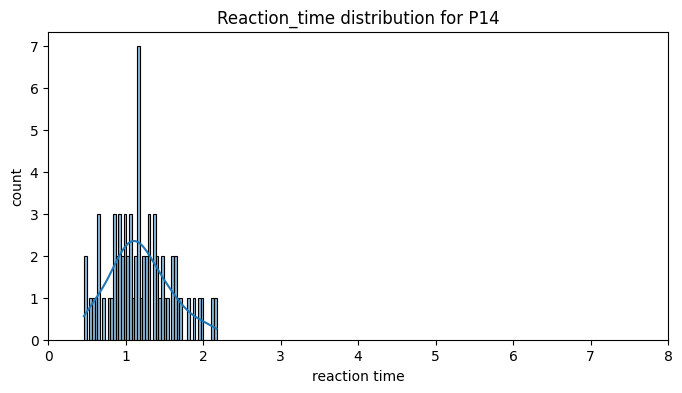

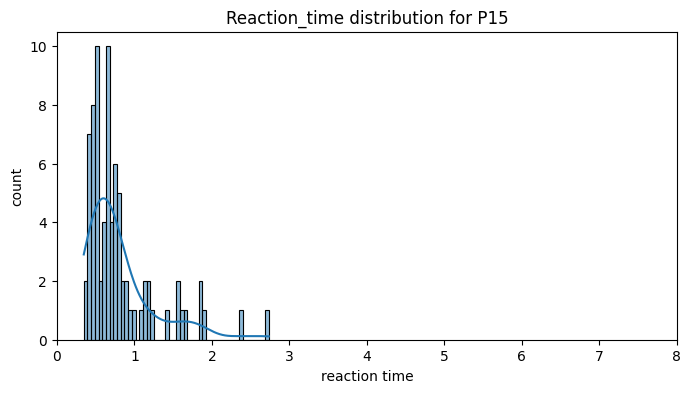

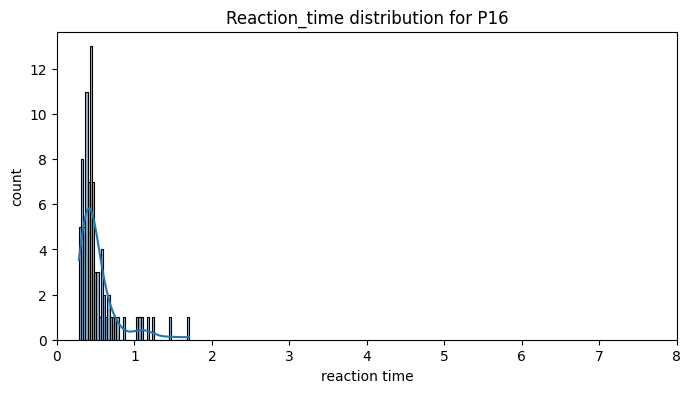

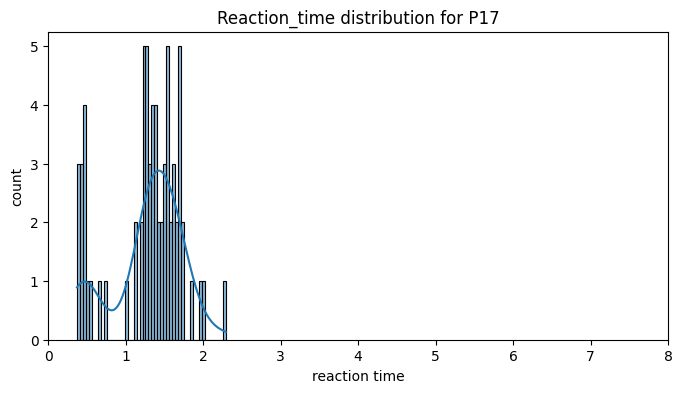

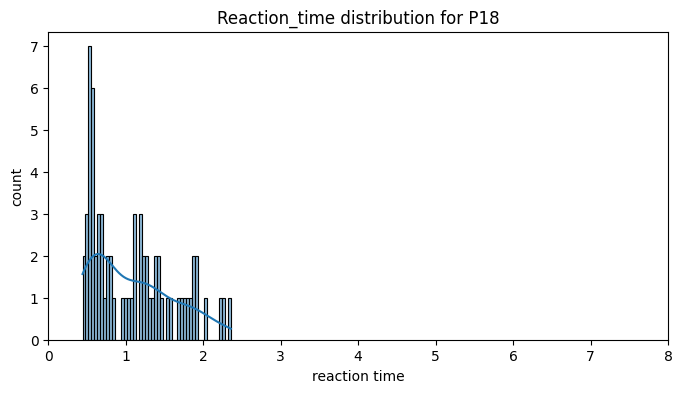

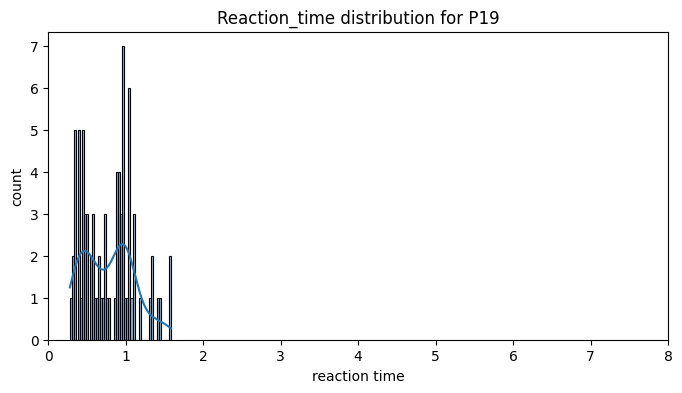

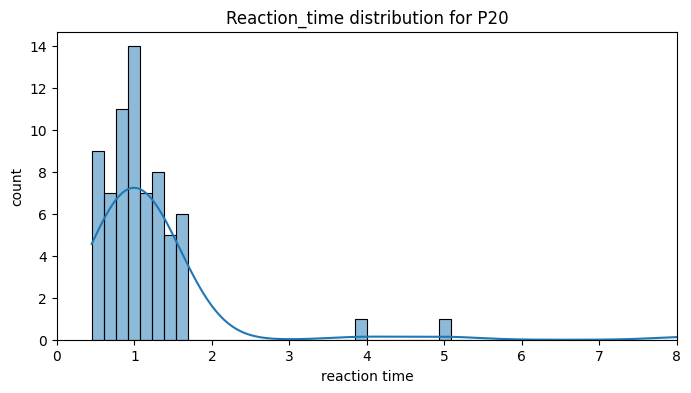

In [10]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    sns.histplot(participant_df['reaction_time'], bins=50, kde=True, )
    plt.title(f'Reaction_time distribution for P{pid}')
    plt.xlabel('reaction time')
    plt.ylabel('count')
    plt.xlim(0, 8)
    plt.show()

##### Error distribution
- Good

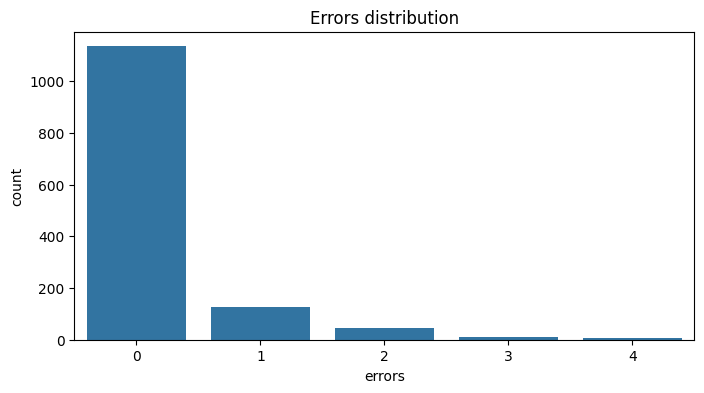

In [30]:
plt.figure(figsize=(8, 4))
sns.countplot(
    x=df['errors'],
    order=sorted(df['errors'].dropna().unique())
)
plt.xlabel('errors')
plt.ylabel('count')
plt.title(f'Errors distribution')
plt.show()

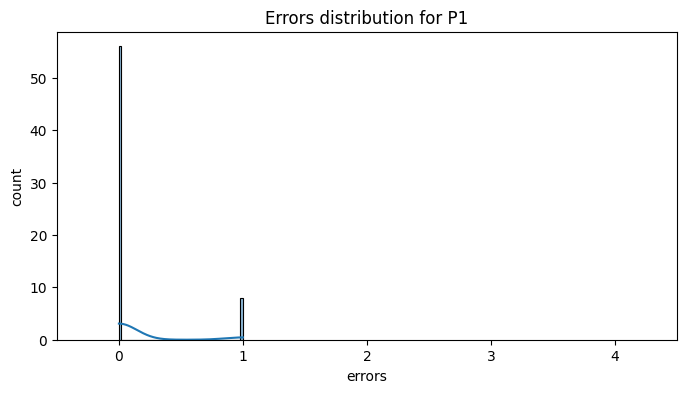

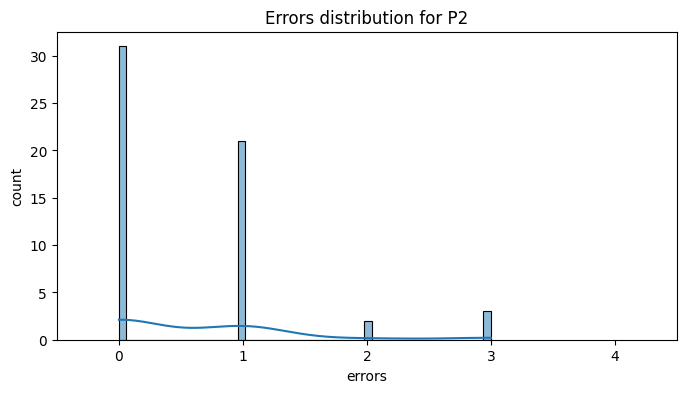

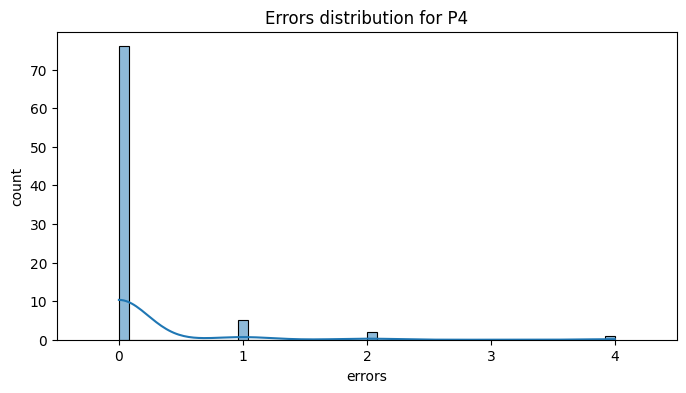

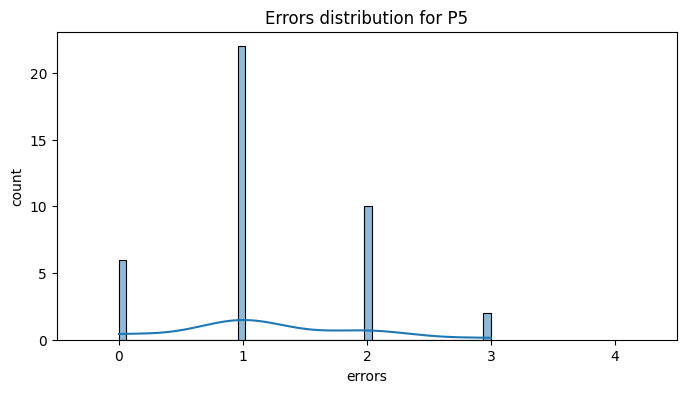

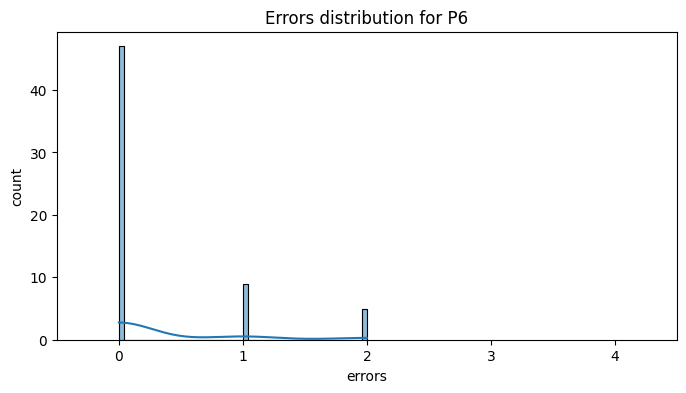

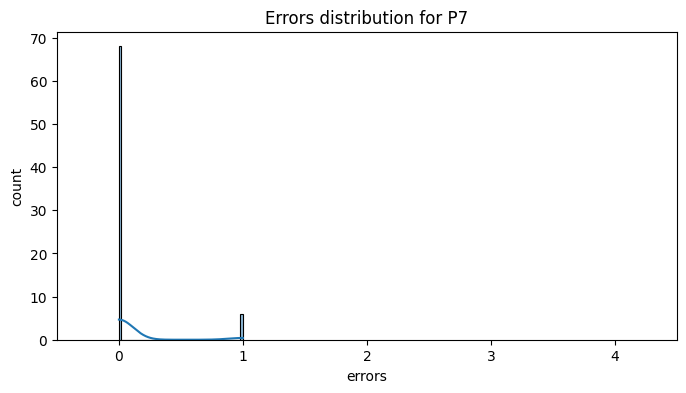

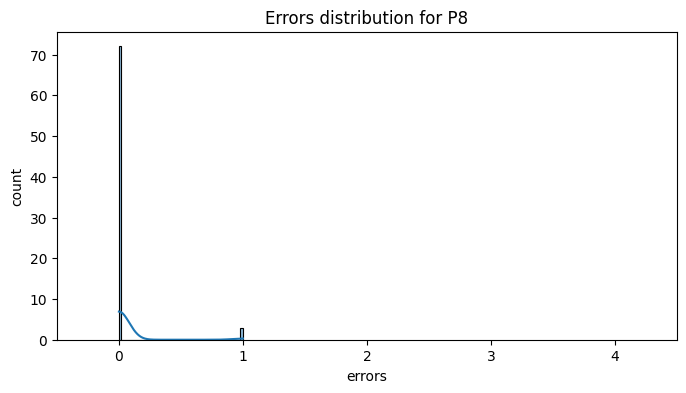

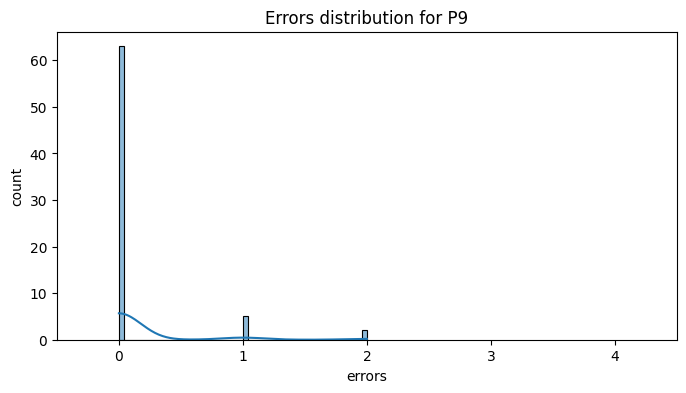

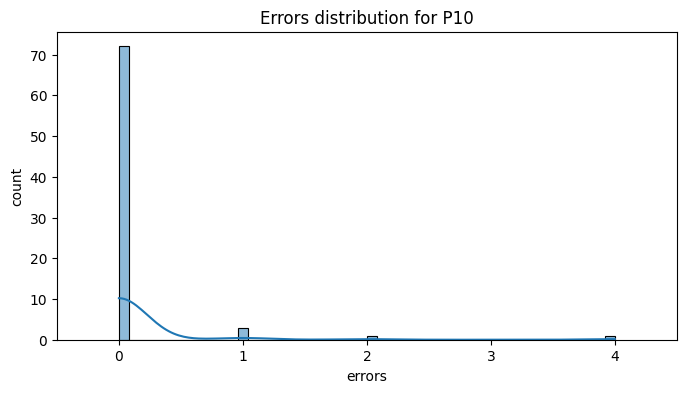

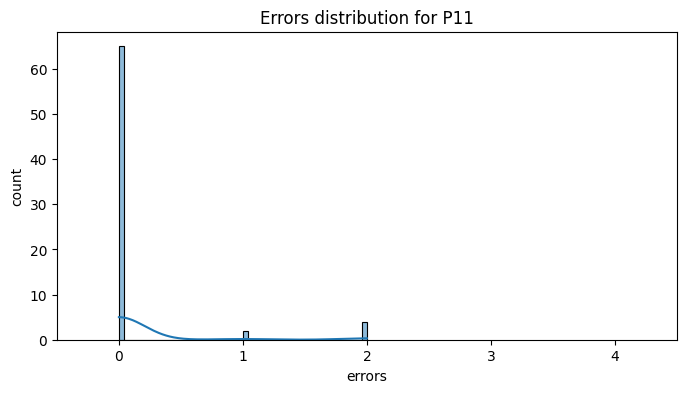

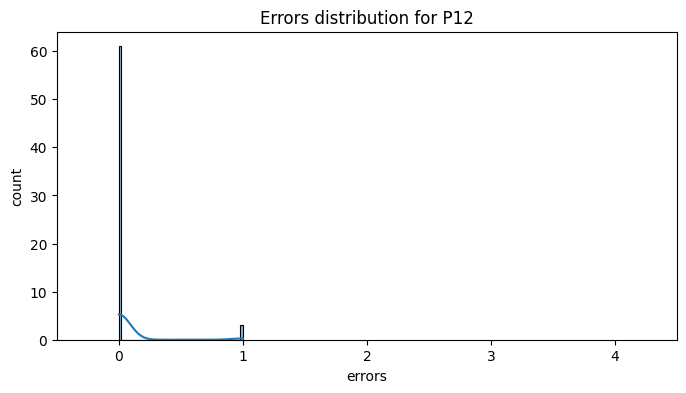

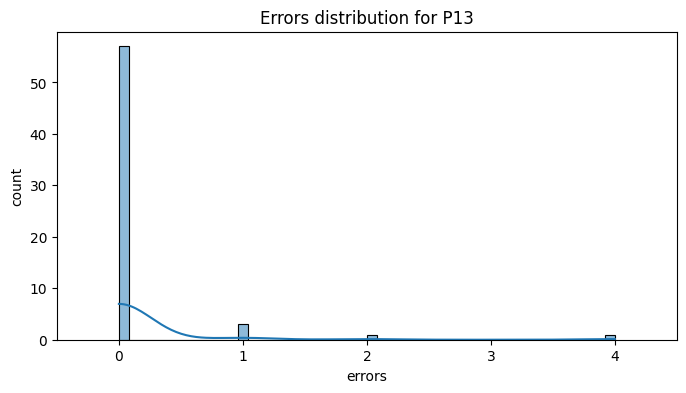

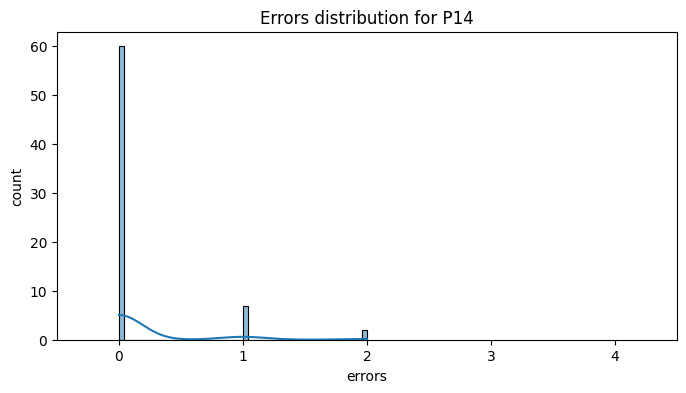

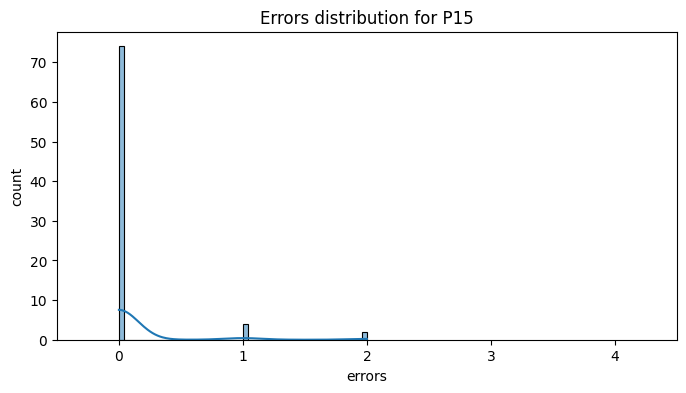

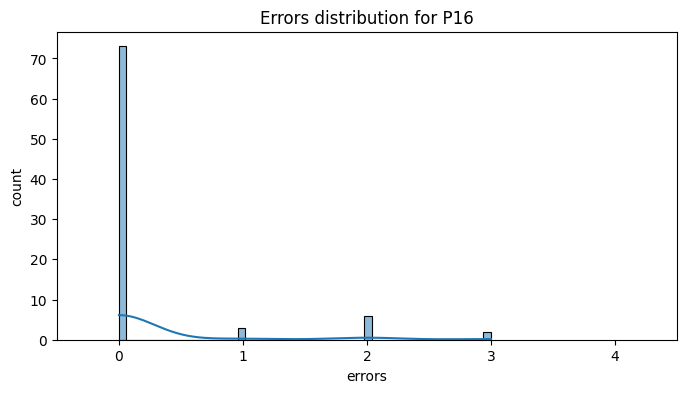

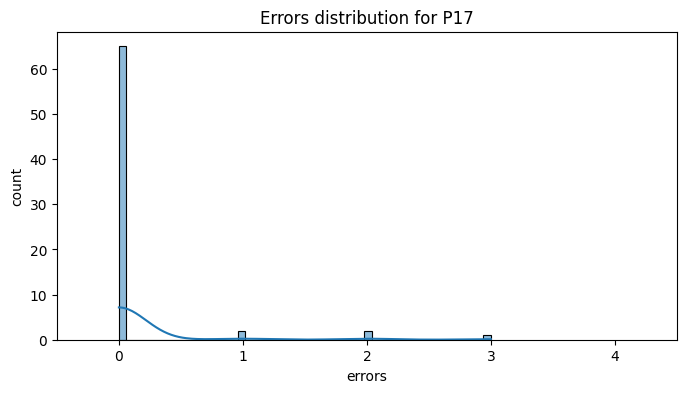

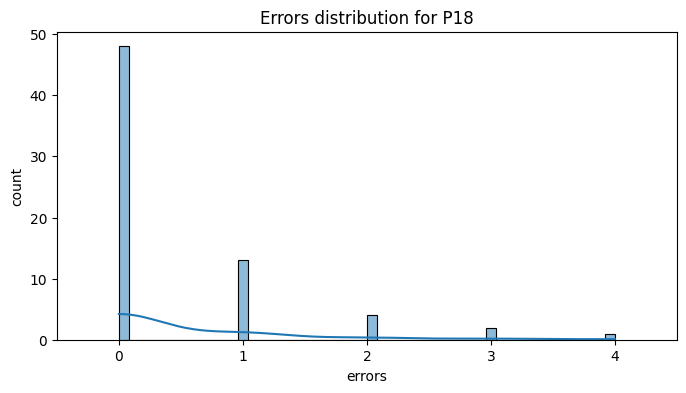

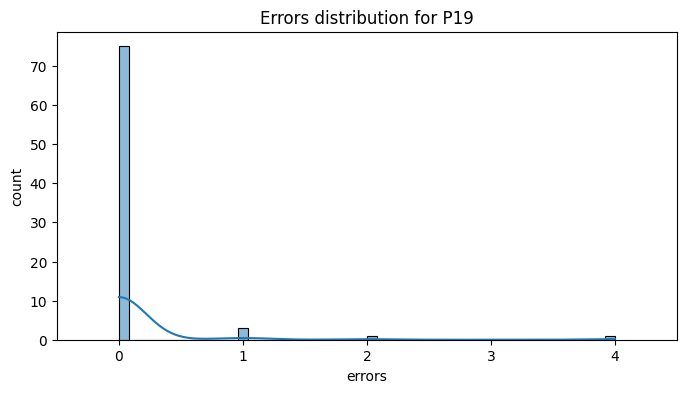

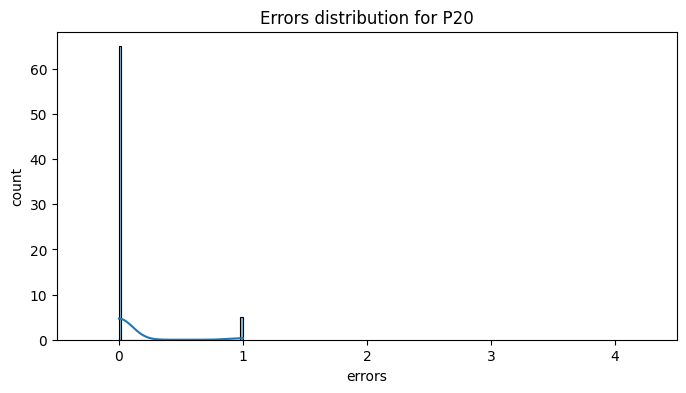

In [11]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    sns.histplot(participant_df['errors'], bins=50, kde=True, )
    plt.title(f'Errors distribution for P{pid}')
    plt.xlabel('errors')
    plt.ylabel('count')
    plt.xlim(-.5, 4.5)
    plt.show()

##### Completion time-task block duration correlation
- No correleation

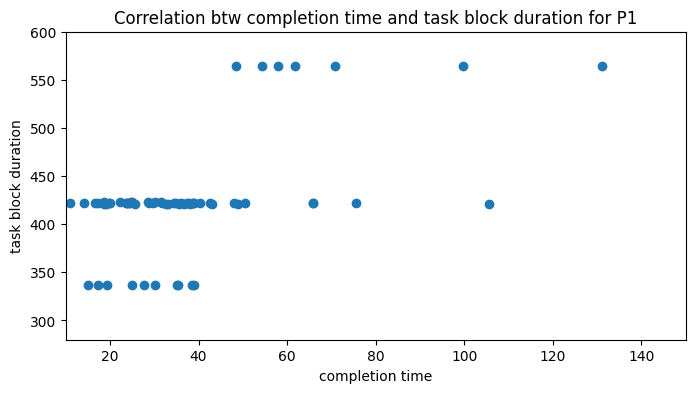

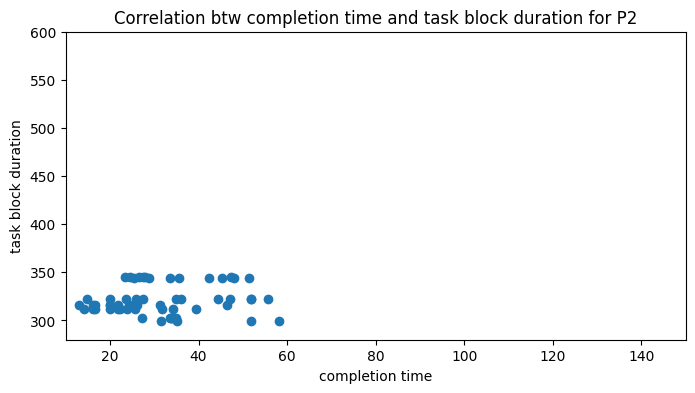

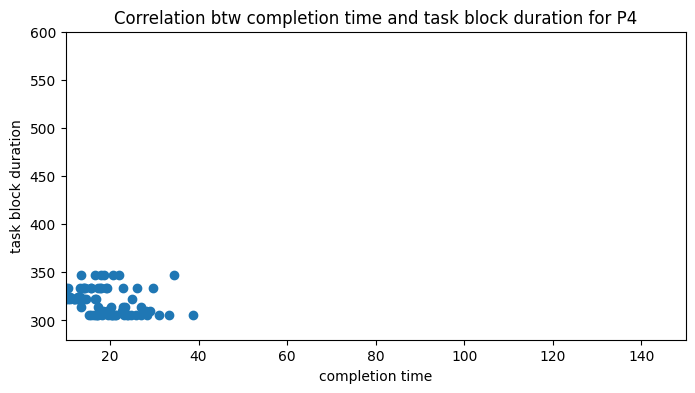

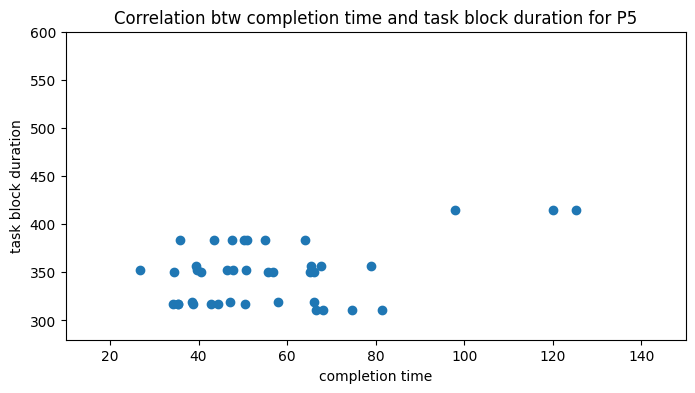

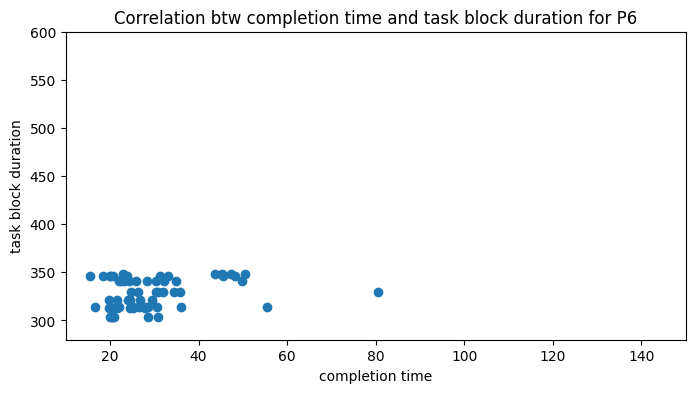

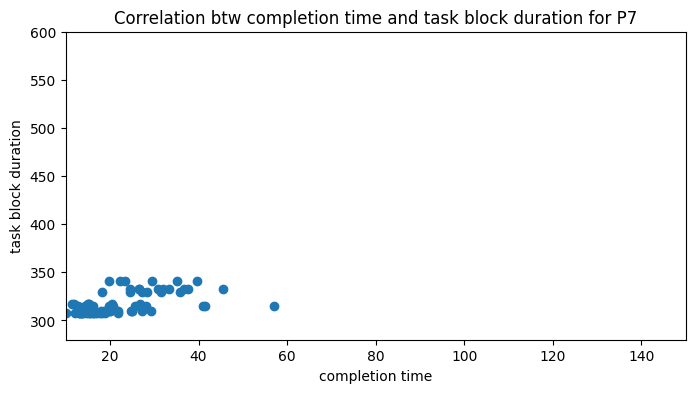

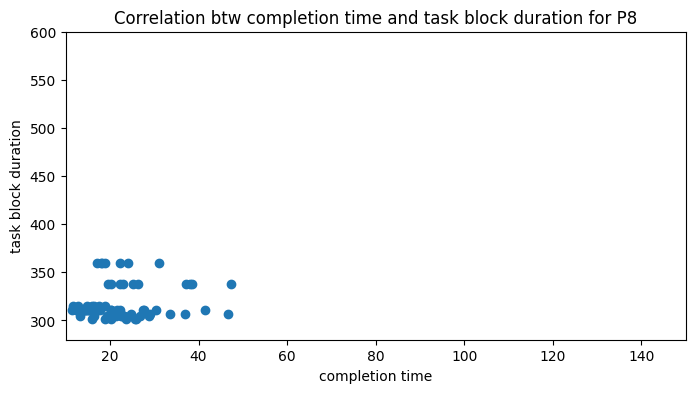

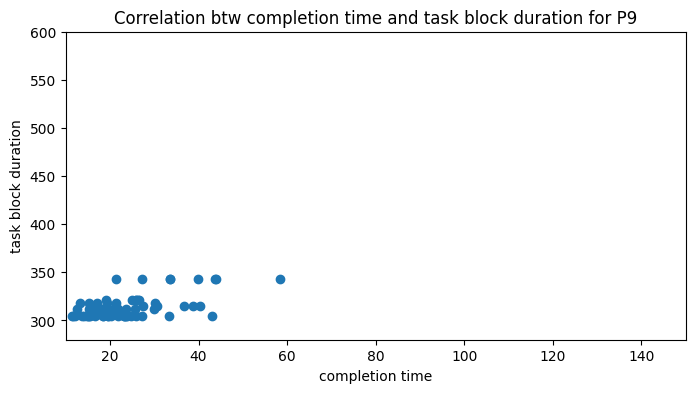

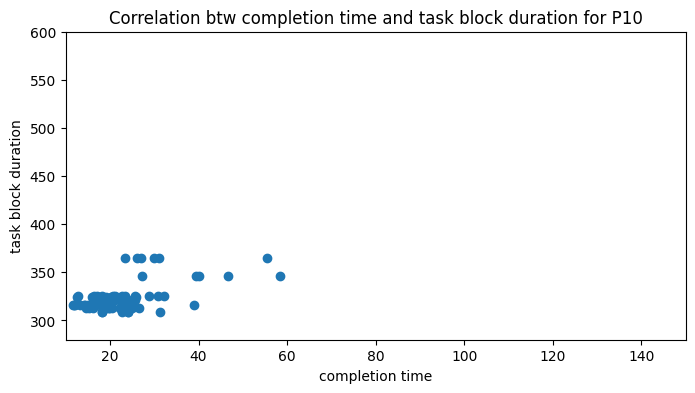

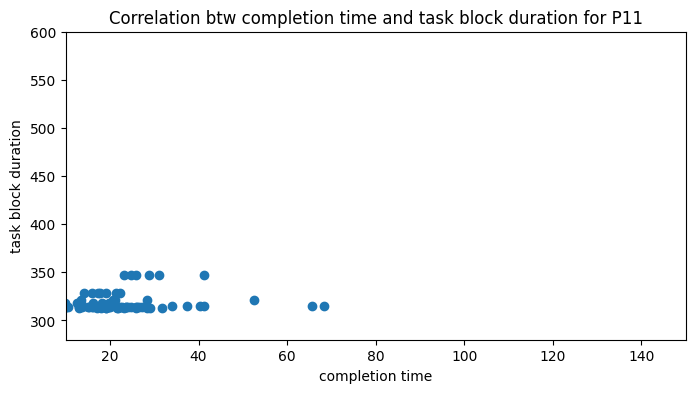

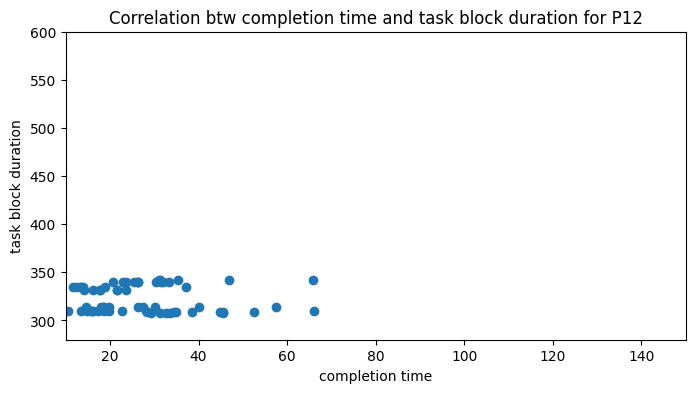

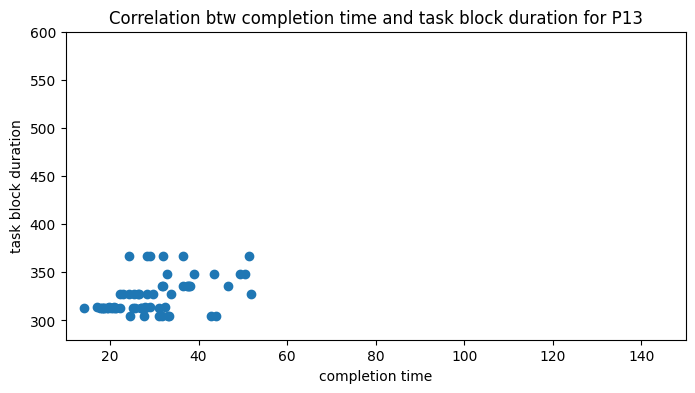

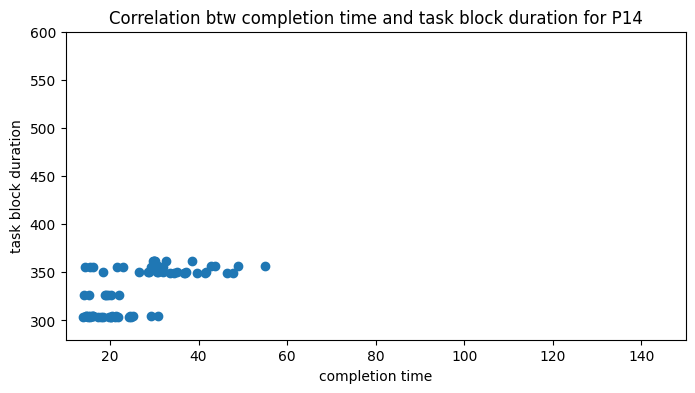

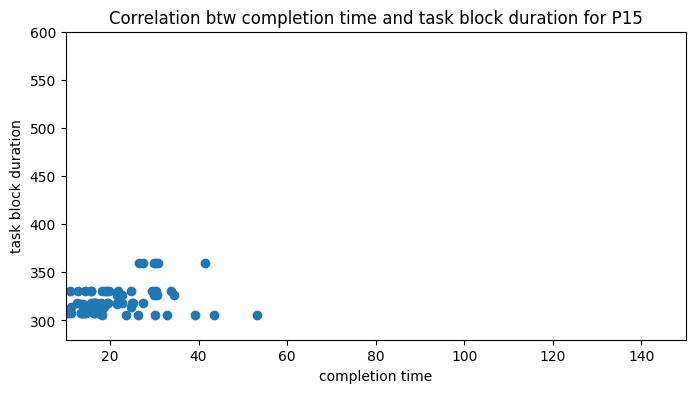

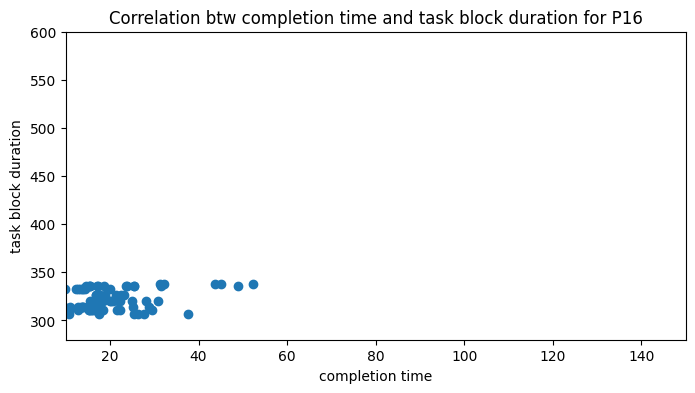

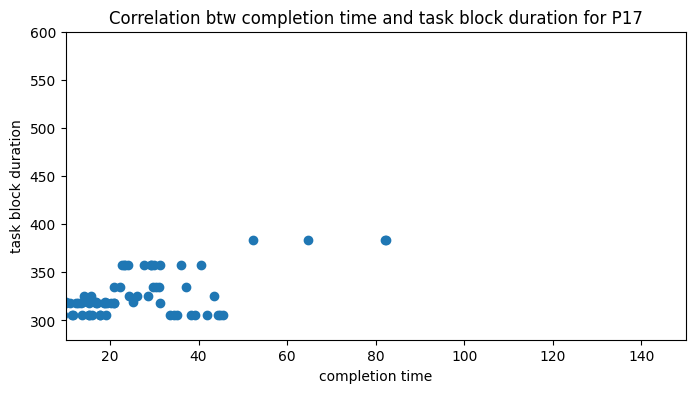

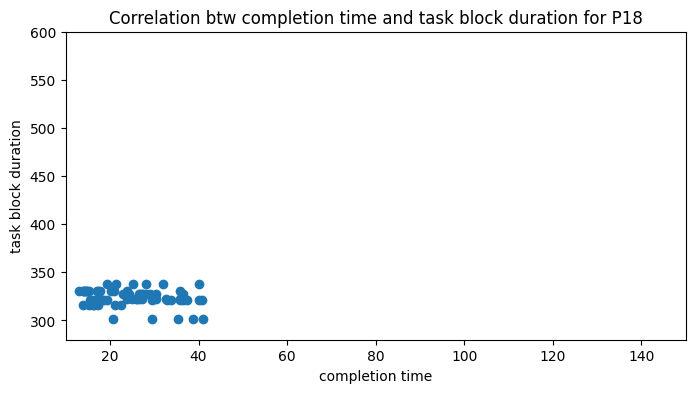

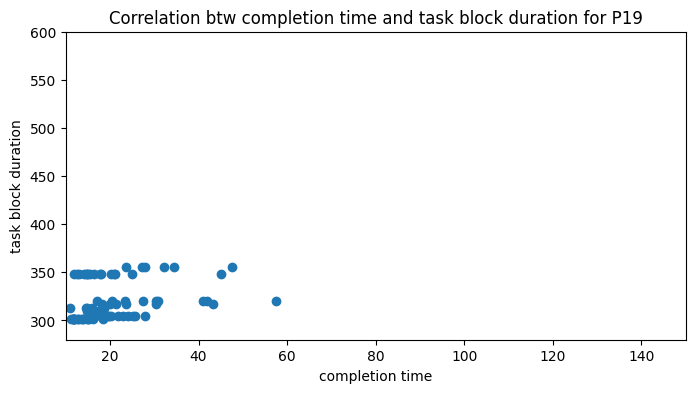

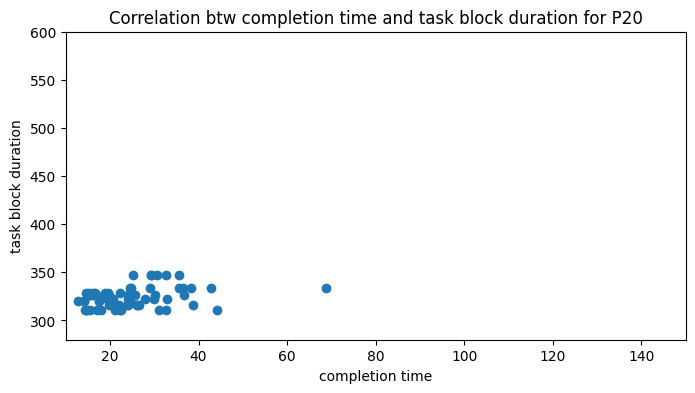

In [12]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}").copy()
    participant_df['block_duration'] = participant_df['block_data'].apply(lambda x: x[1])
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['completion_time'], participant_df['block_duration'])
    plt.title(f'Correlation btw completion time and task block duration for P{pid}')
    plt.xlabel('completion time')
    plt.ylabel('task block duration')
    plt.xlim(10, 150)
    plt.ylim(280,600)
    plt.show()

##### Reaction time-task block duration correlation
- No correlation

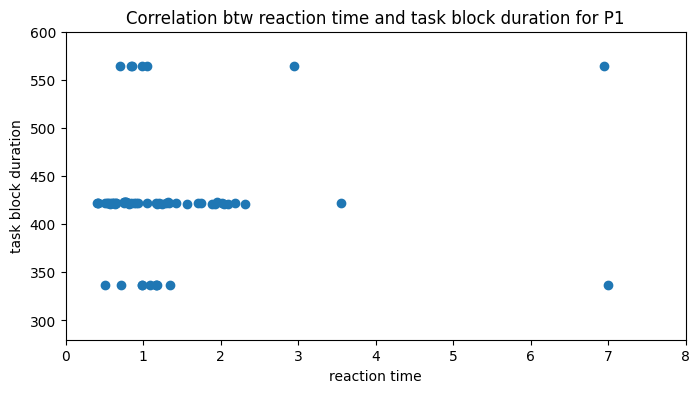

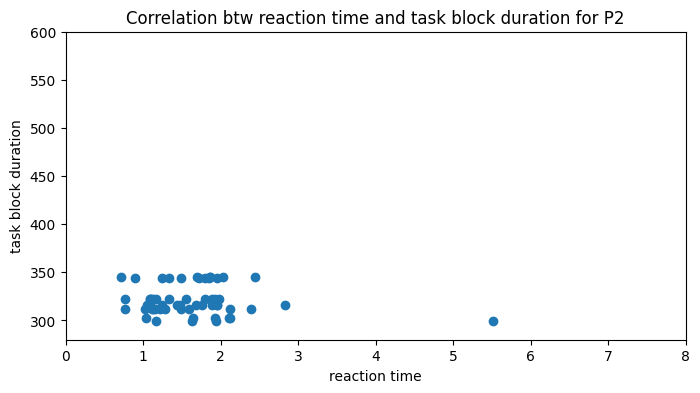

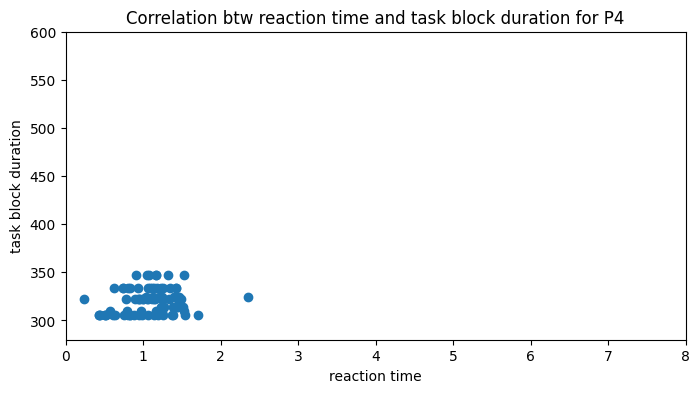

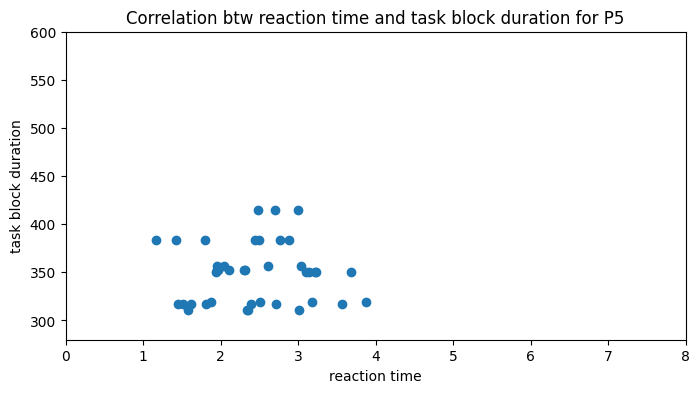

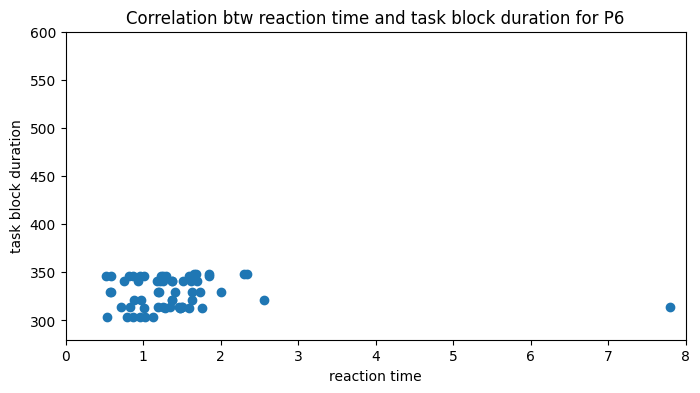

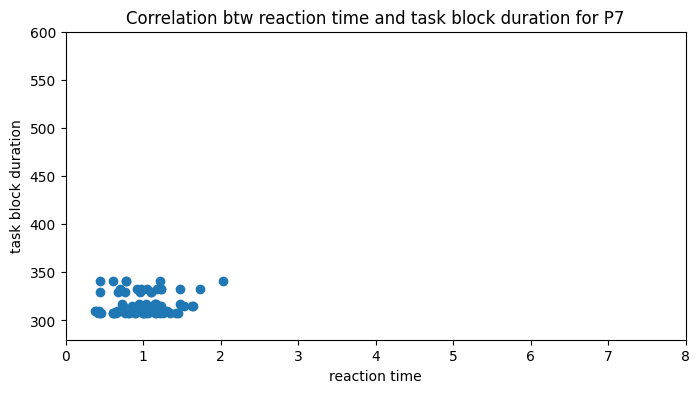

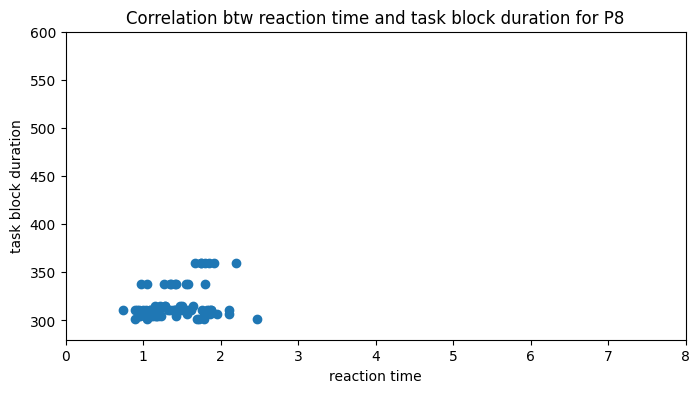

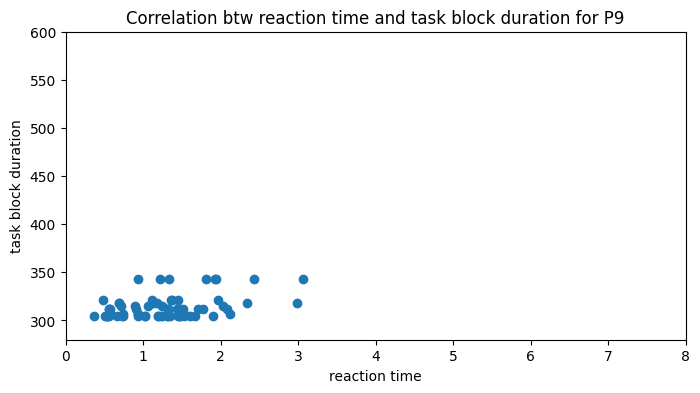

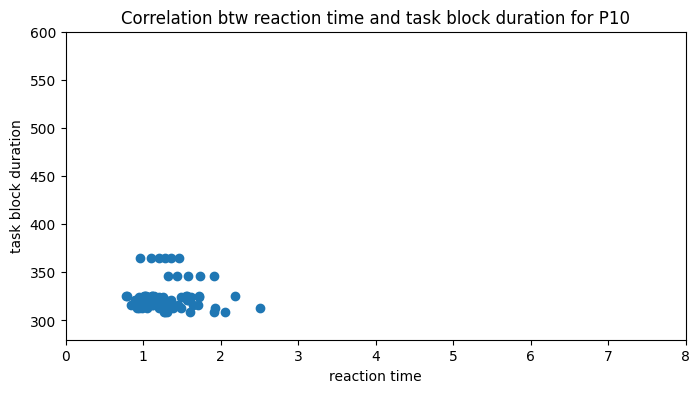

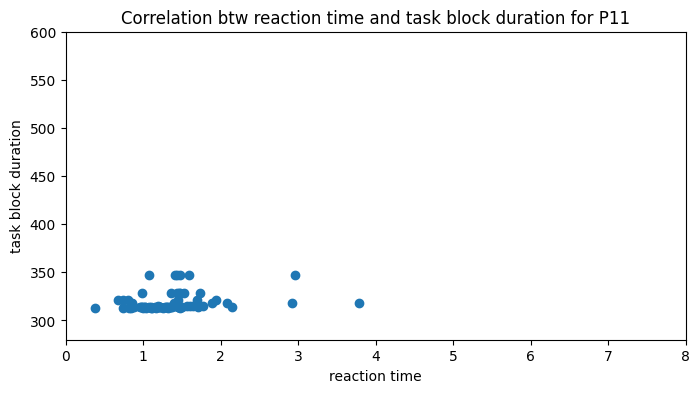

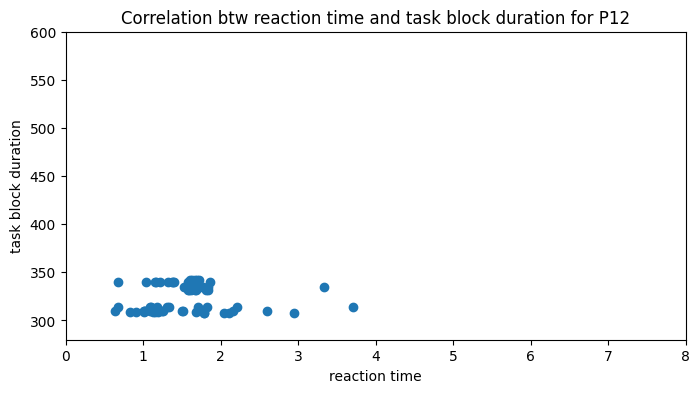

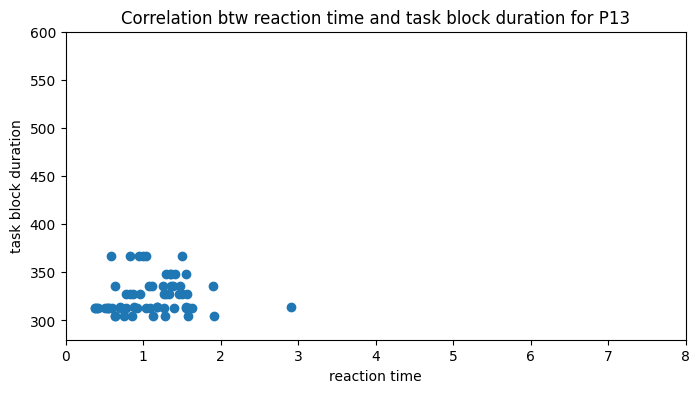

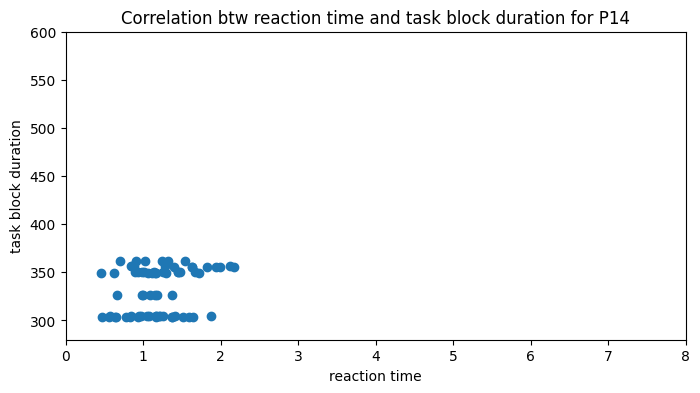

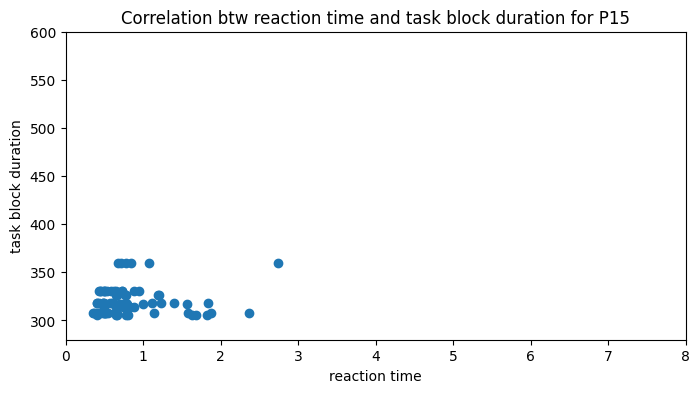

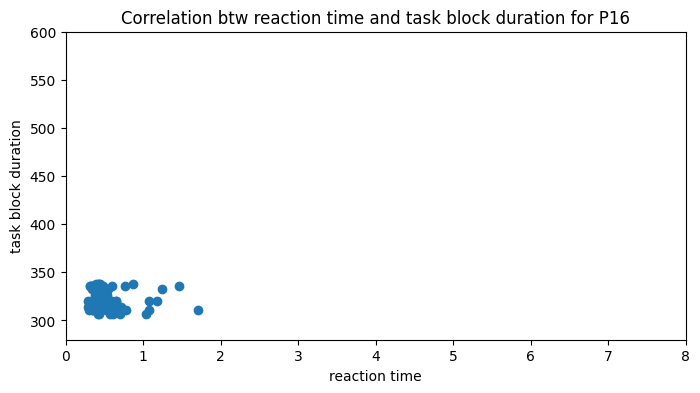

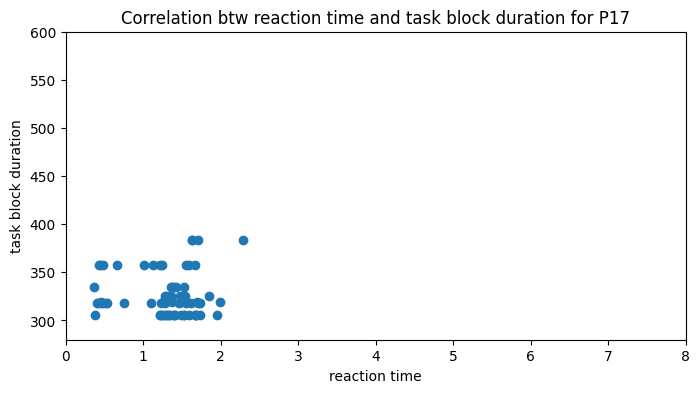

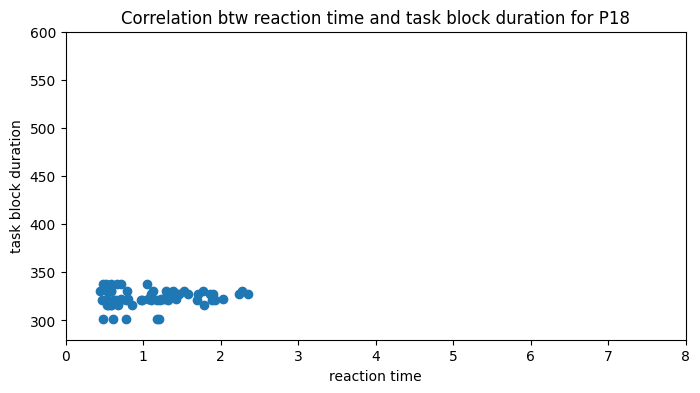

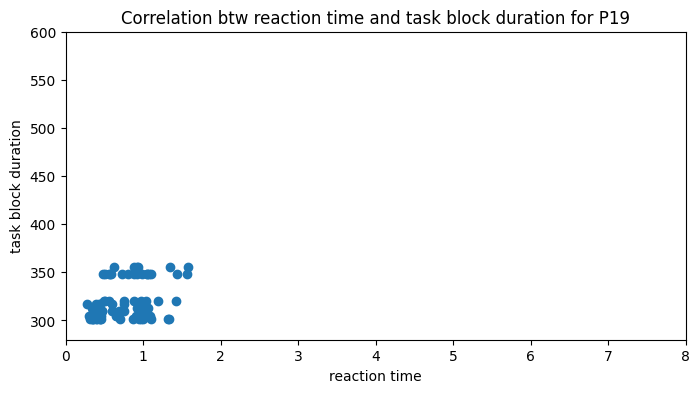

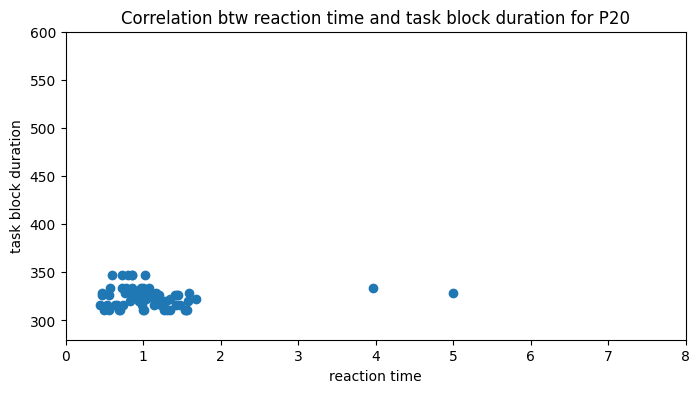

In [13]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}").copy()
    participant_df['block_duration'] = participant_df['block_data'].apply(lambda x: x[1])
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['reaction_time'], participant_df['block_duration'])
    plt.title(f'Correlation btw reaction time and task block duration for P{pid}')
    plt.xlabel('reaction time')
    plt.ylabel('task block duration')
    plt.xlim(0, 8)
    plt.ylim(280,600)
    plt.show()

##### Completion time-reaction time correlation
- No correlation

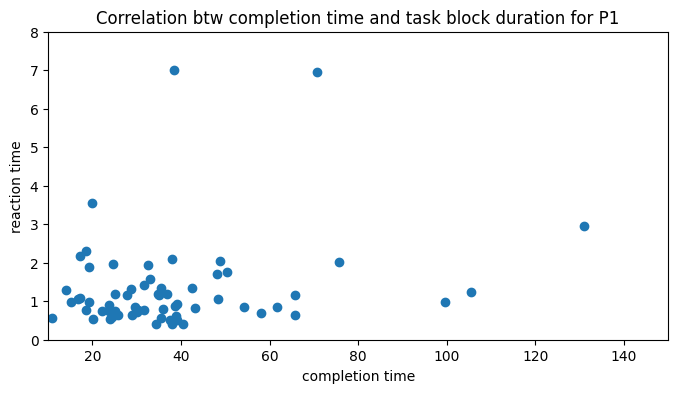

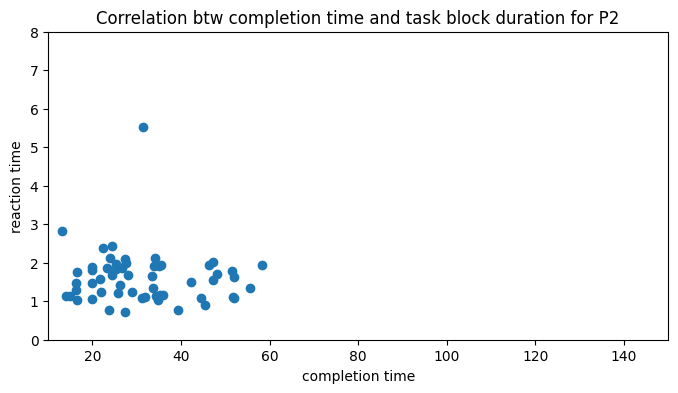

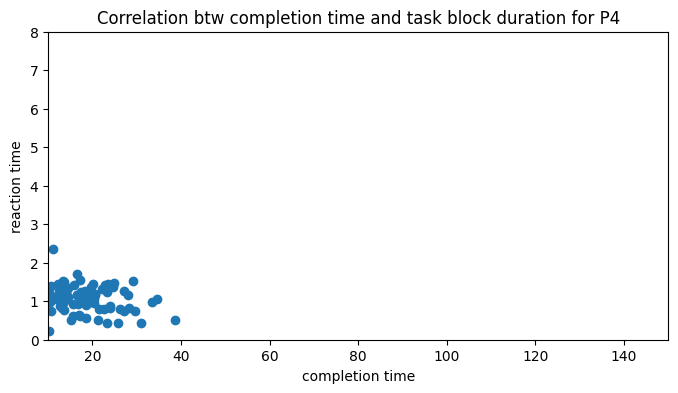

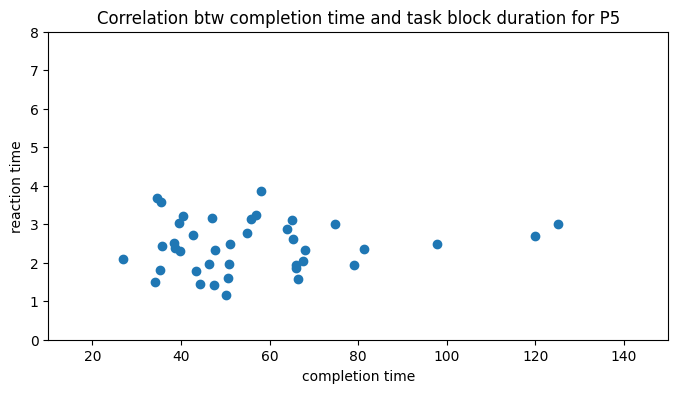

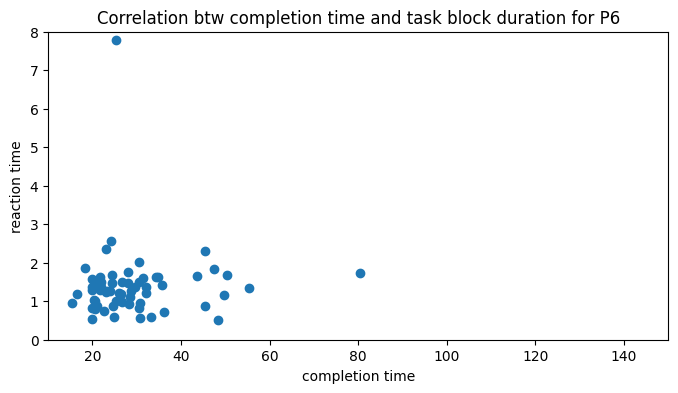

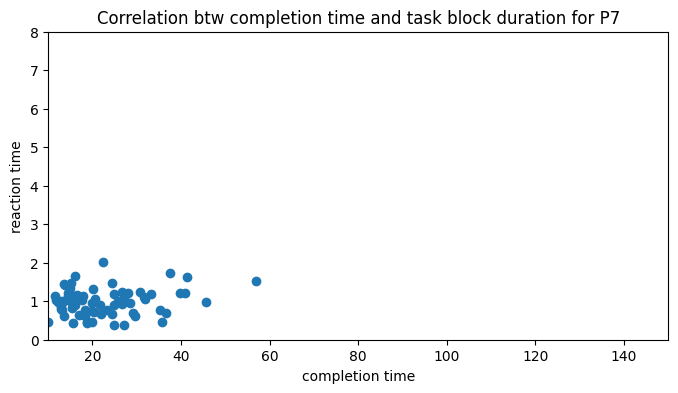

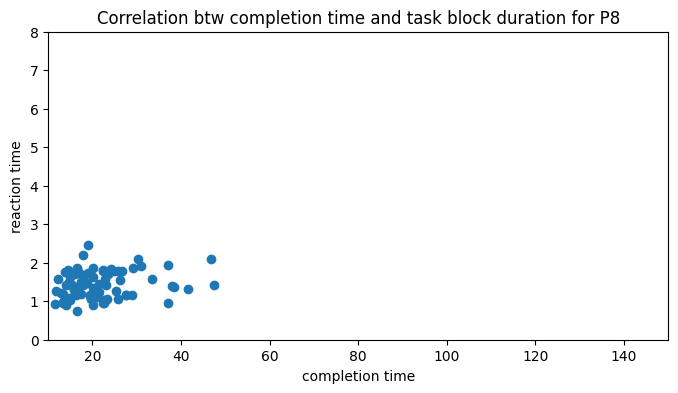

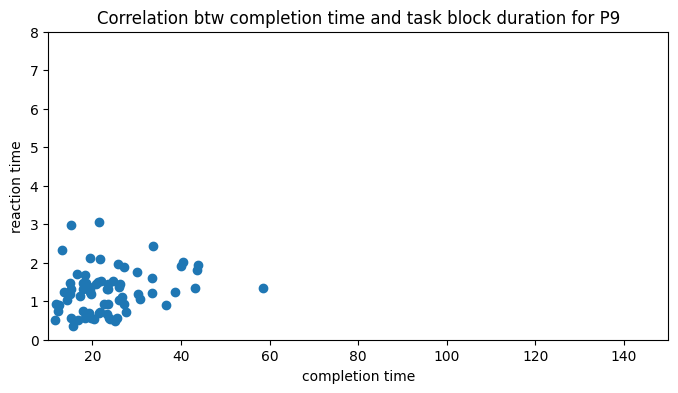

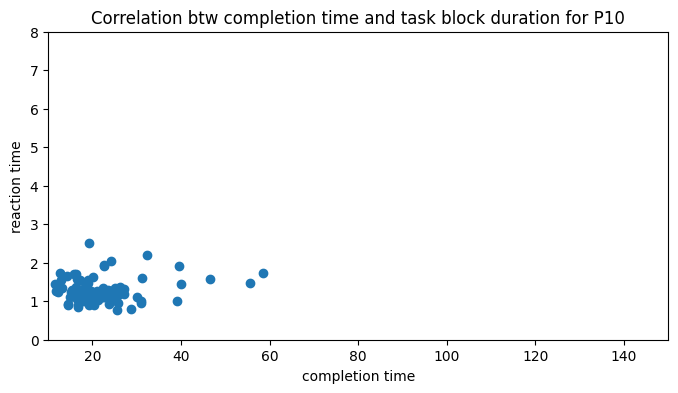

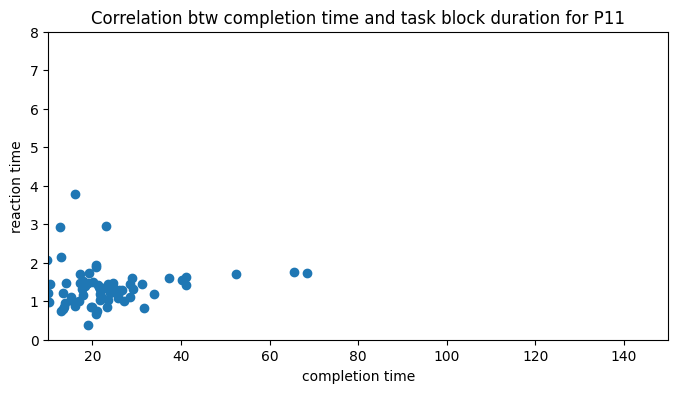

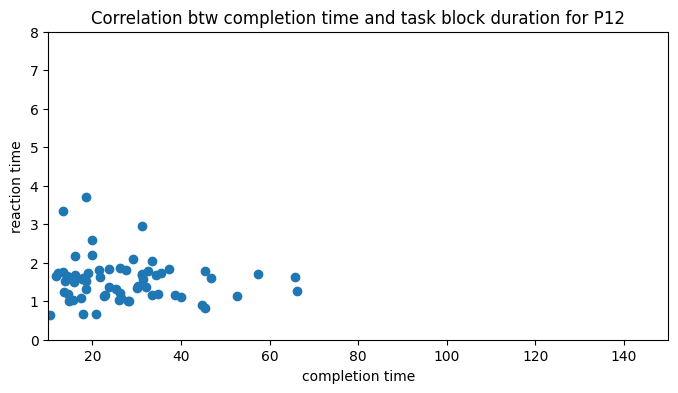

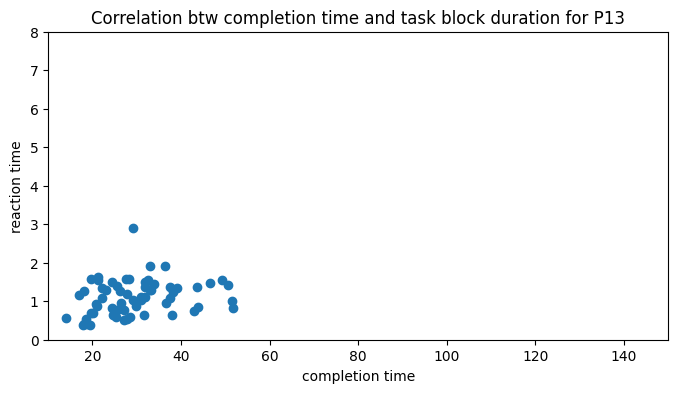

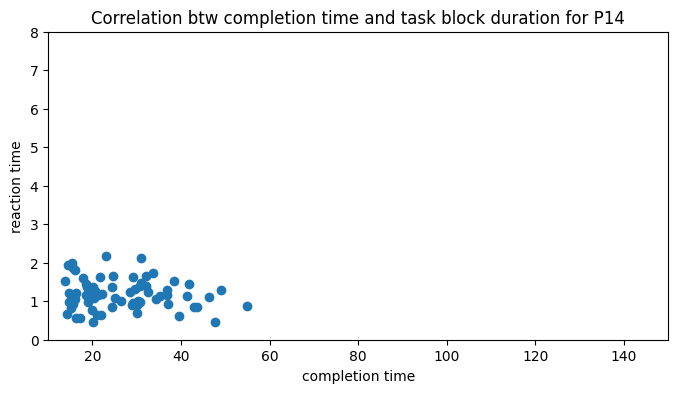

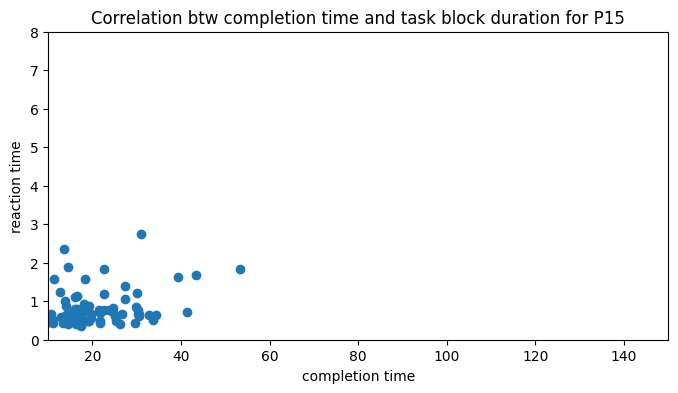

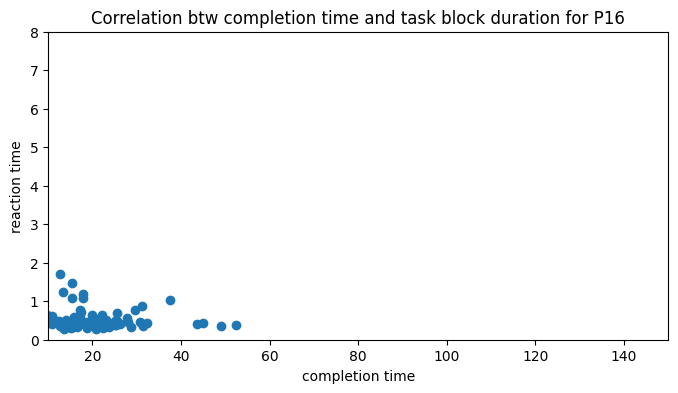

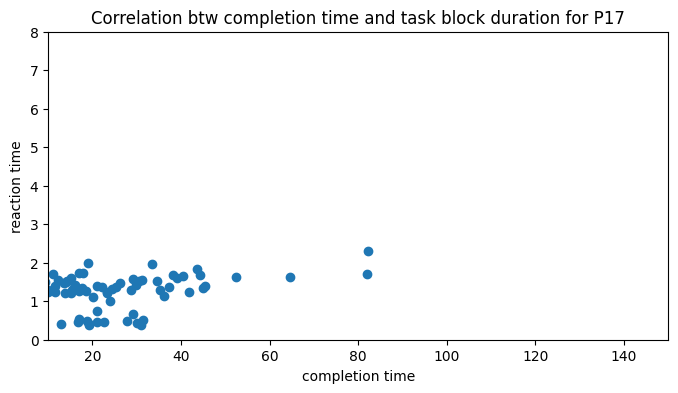

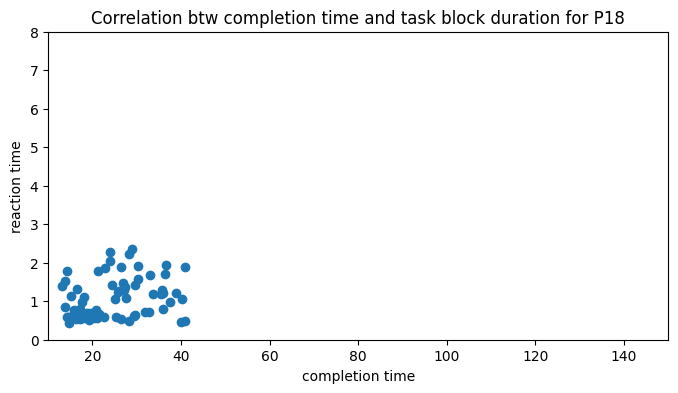

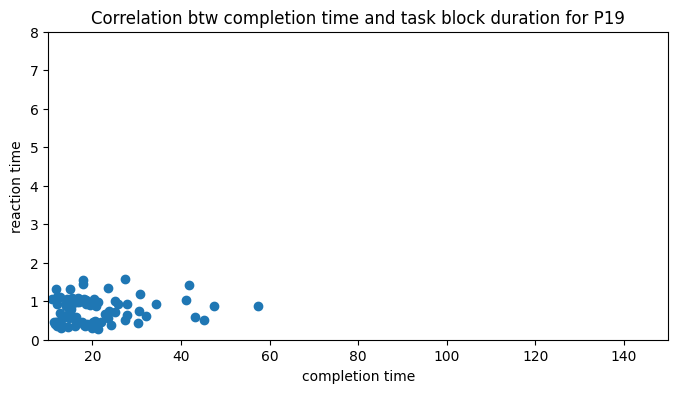

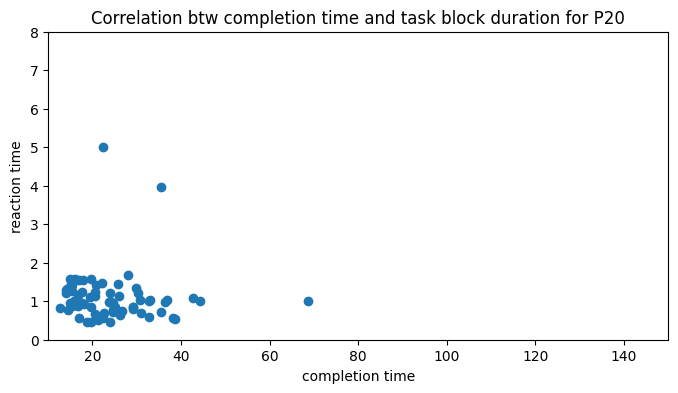

In [14]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['completion_time'], participant_df['reaction_time'])
    plt.title(f'Correlation btw completion time and task block duration for P{pid}')
    plt.xlabel('completion time')
    plt.ylabel('reaction time')
    plt.xlim(10, 150)
    plt.ylim(0, 8)
    plt.show()

##### Task block duration-error correlation
- No correlation

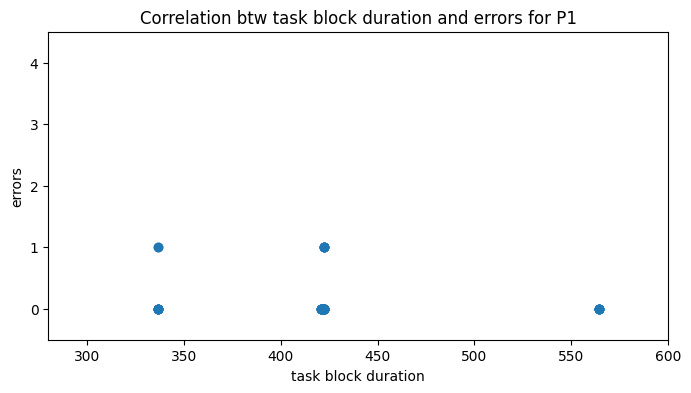

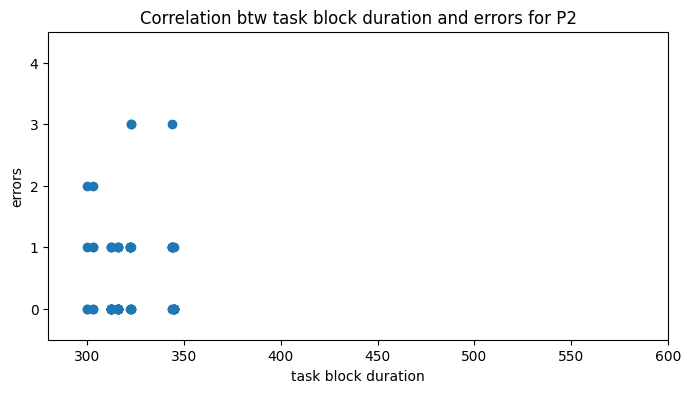

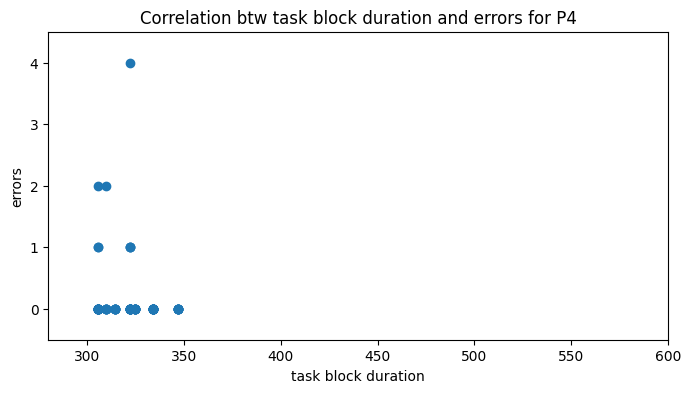

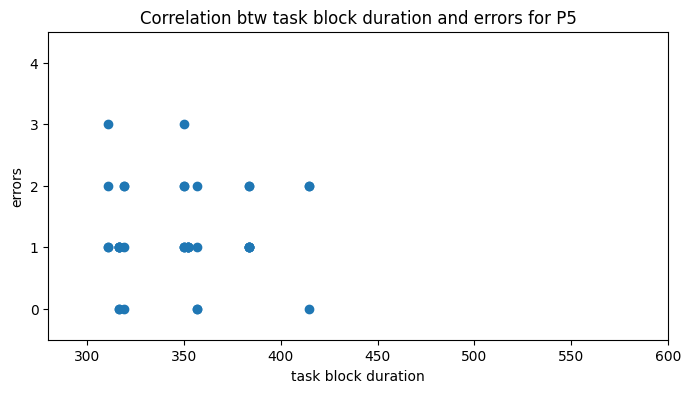

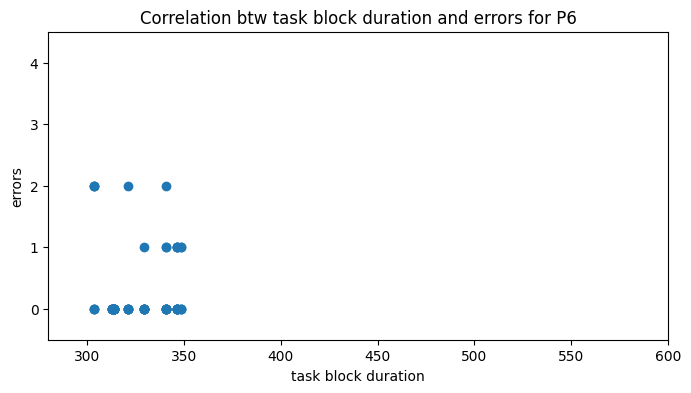

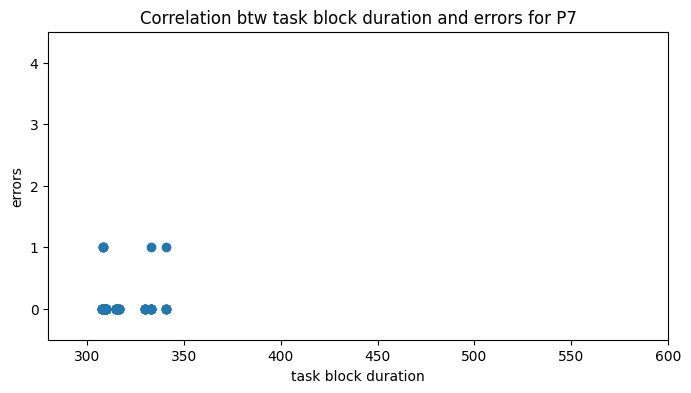

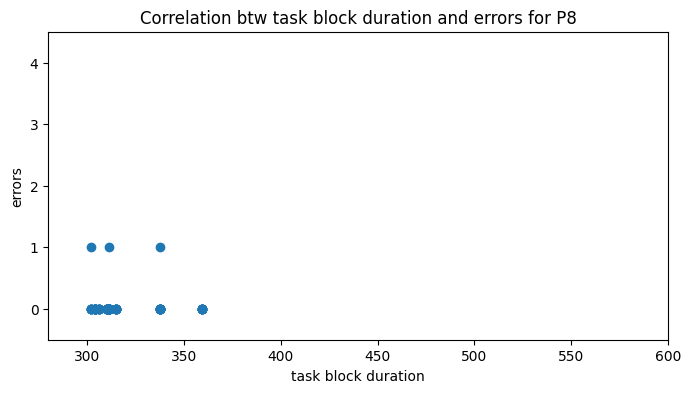

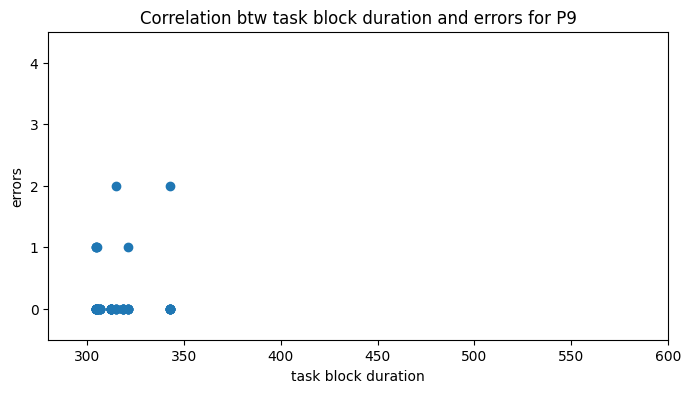

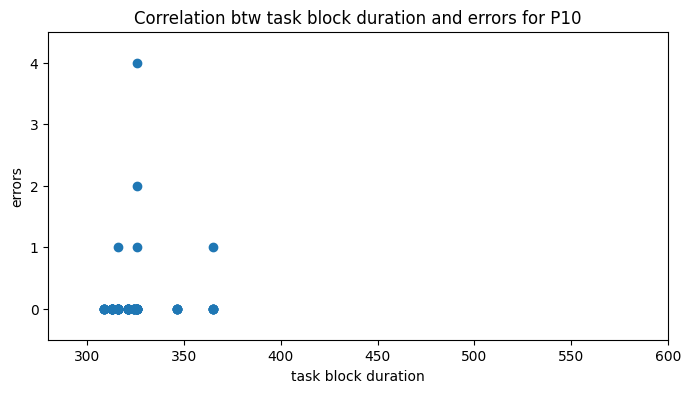

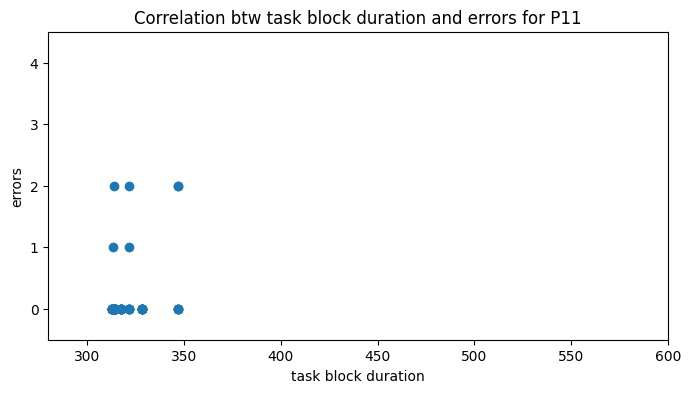

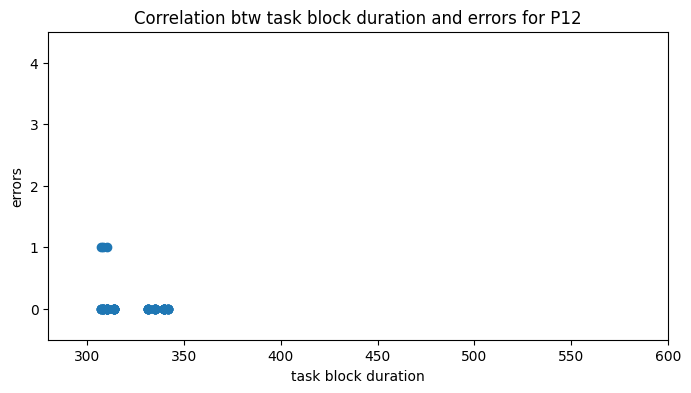

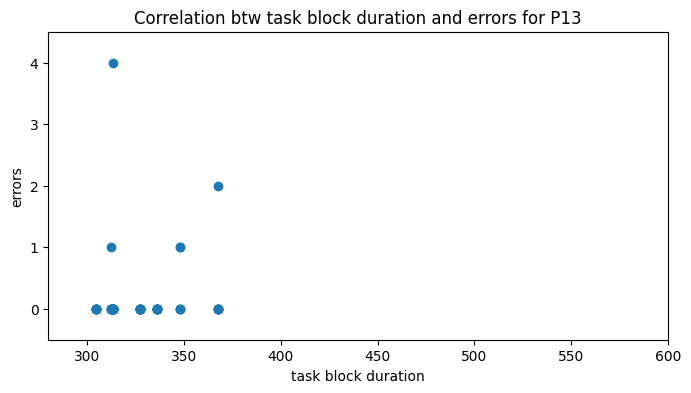

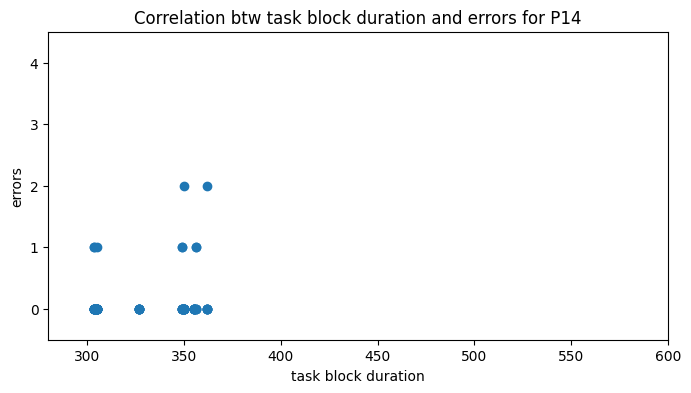

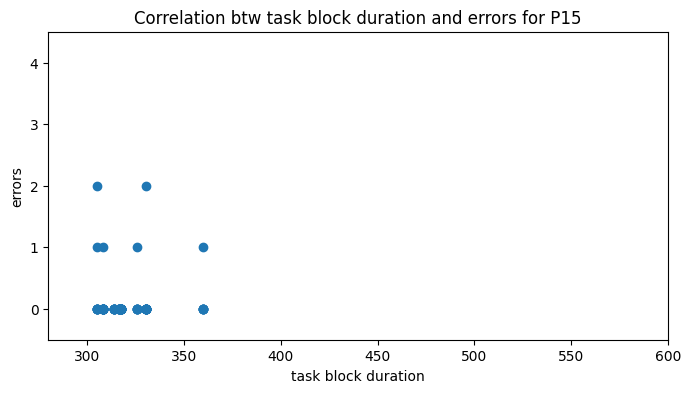

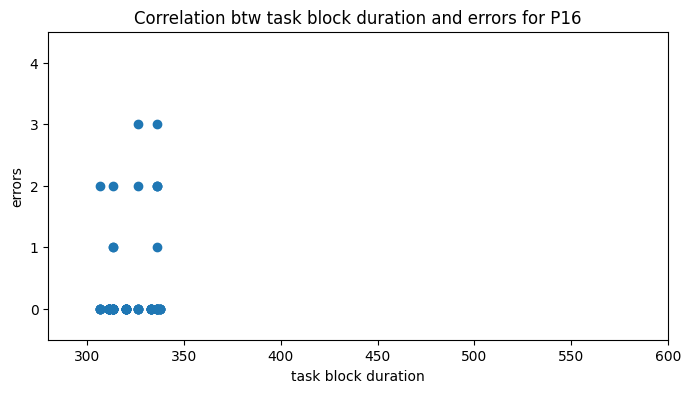

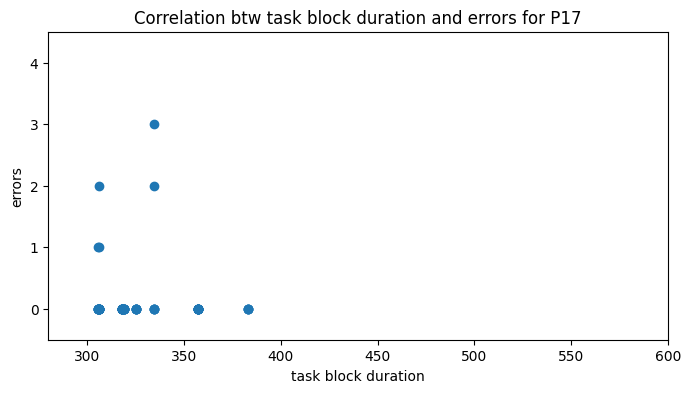

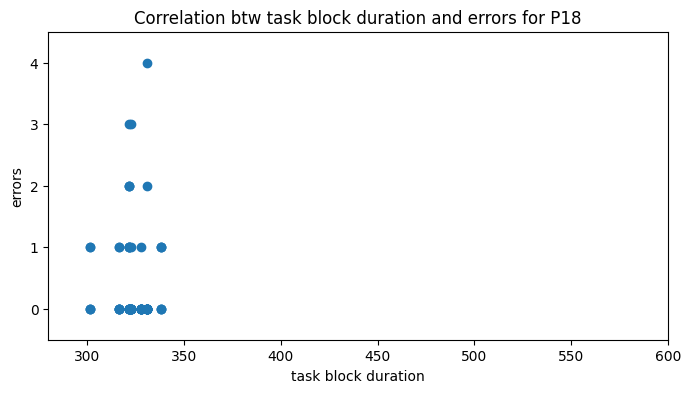

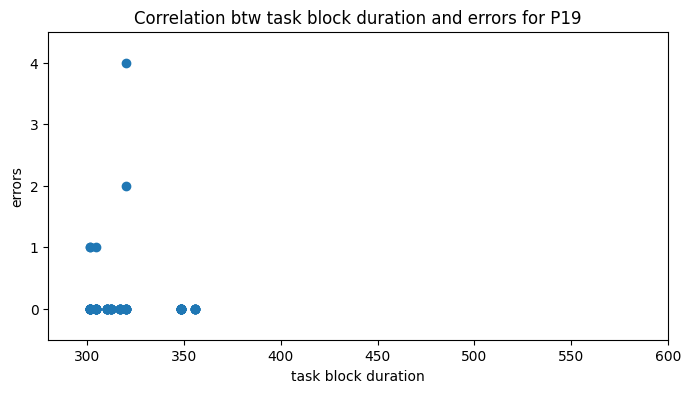

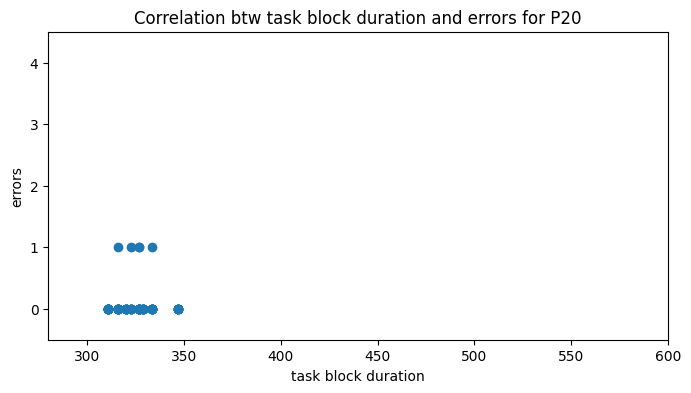

In [15]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}").copy()
    participant_df['block_duration'] = participant_df['block_data'].apply(lambda x: x[1])
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['block_duration'], participant_df['errors'])
    plt.title(f'Correlation btw task block duration and errors for P{pid}')
    plt.xlabel('task block duration')
    plt.ylabel('errors')
    plt.xlim(280,600)
    plt.ylim(-.5, 4.5)
    plt.show()

##### Completion time-errors correlation
- No correlation

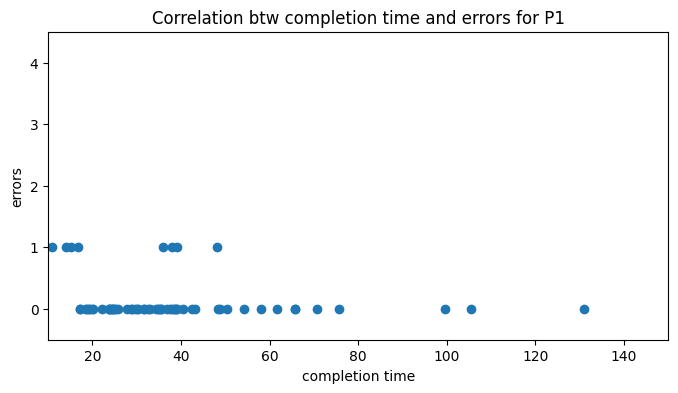

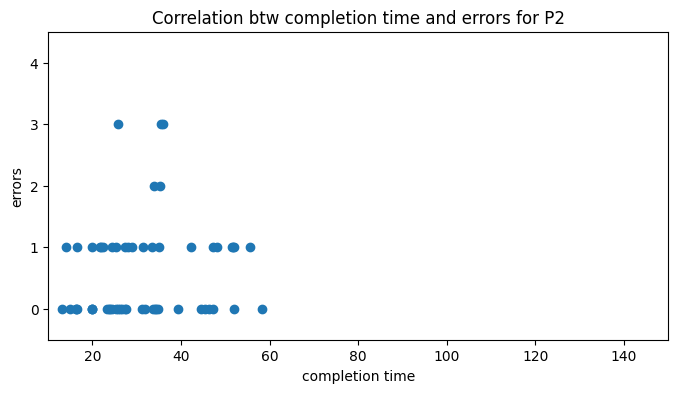

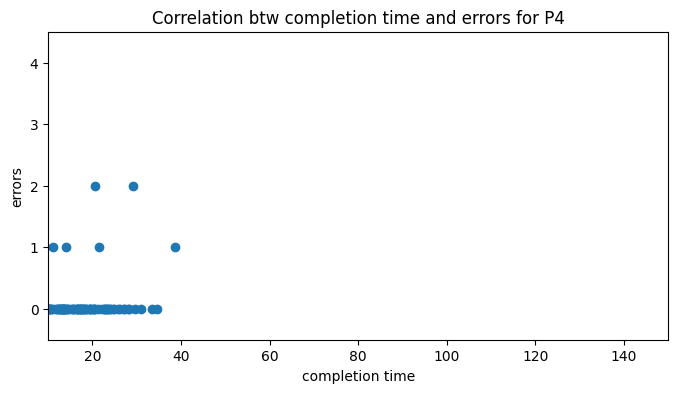

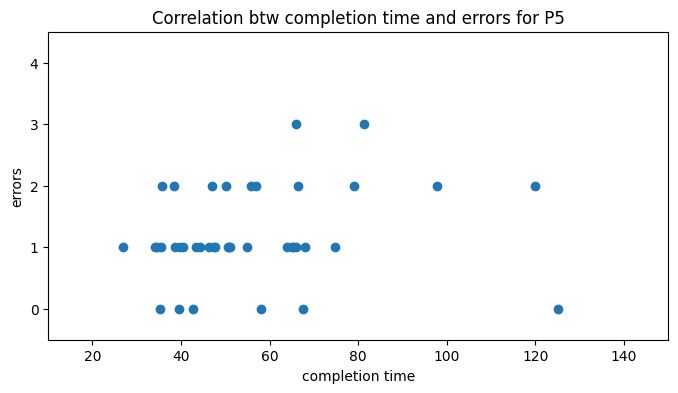

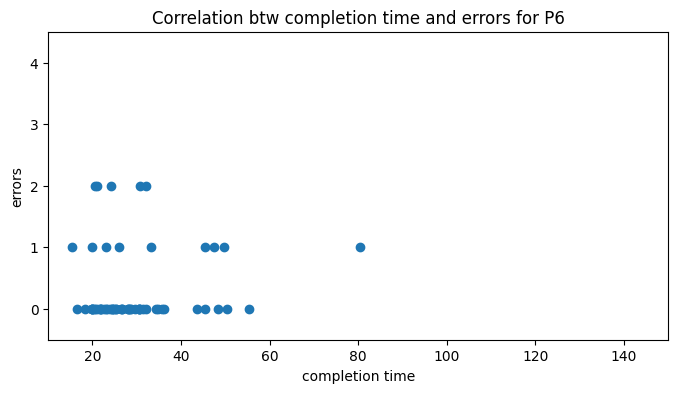

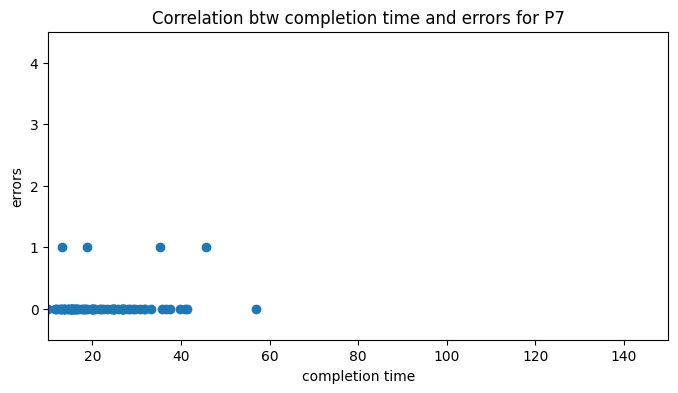

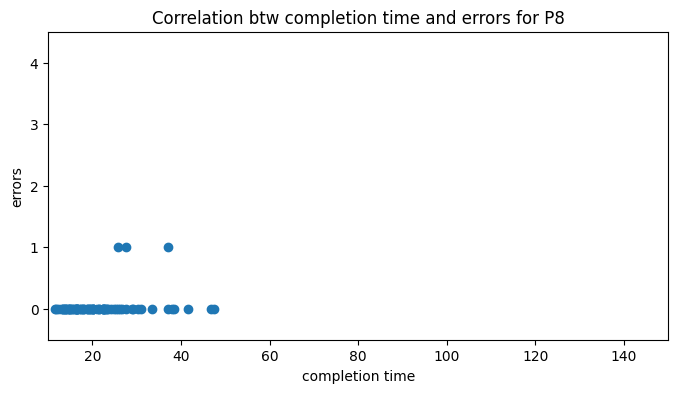

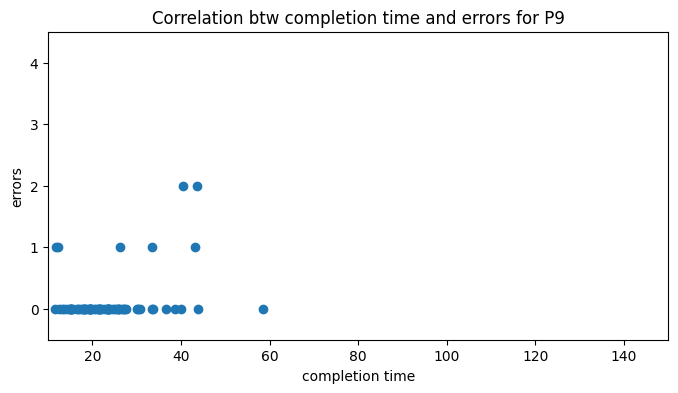

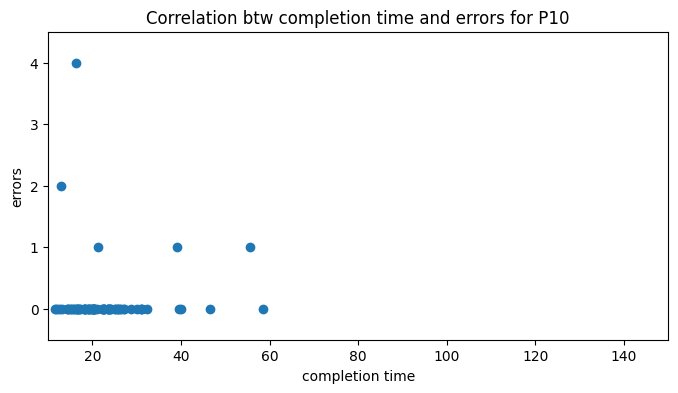

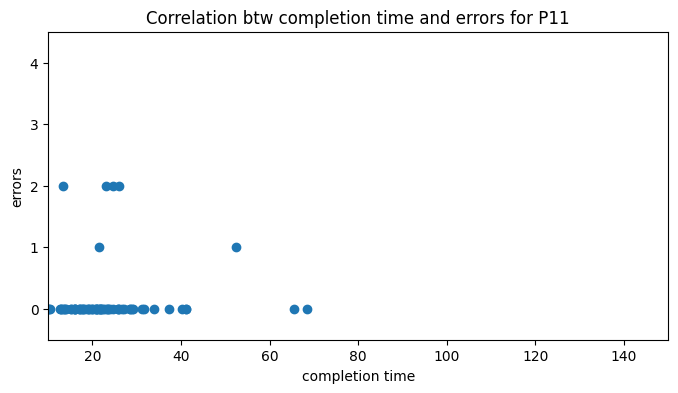

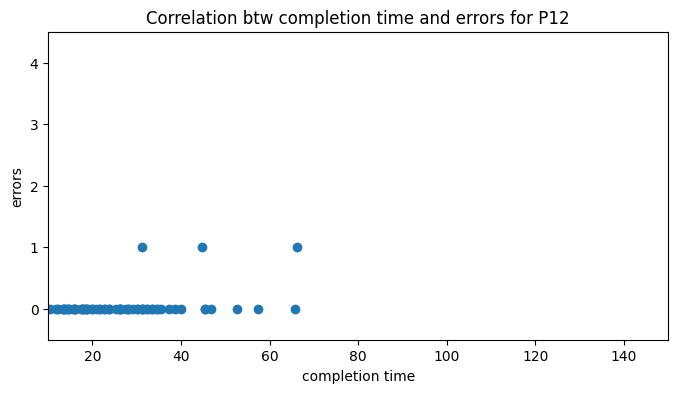

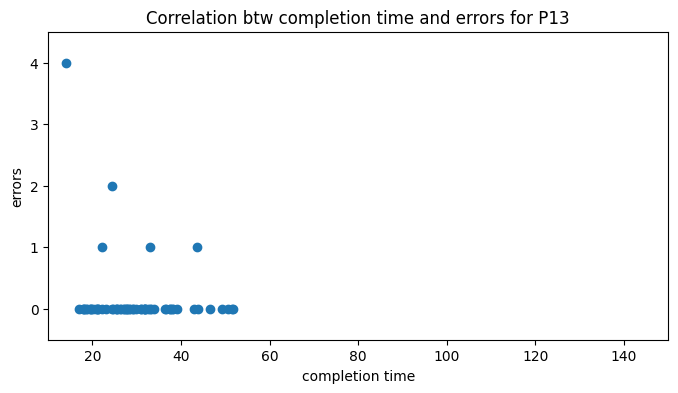

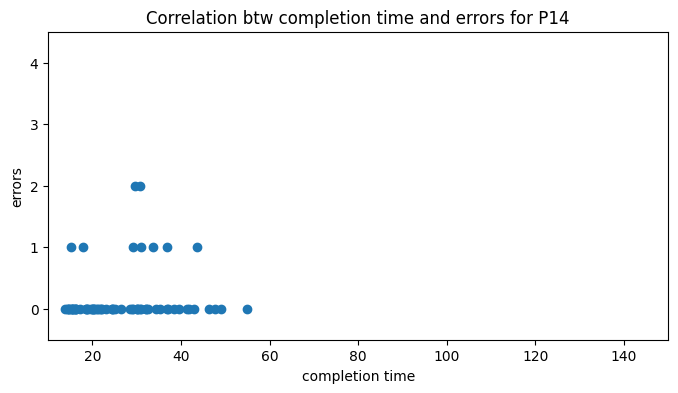

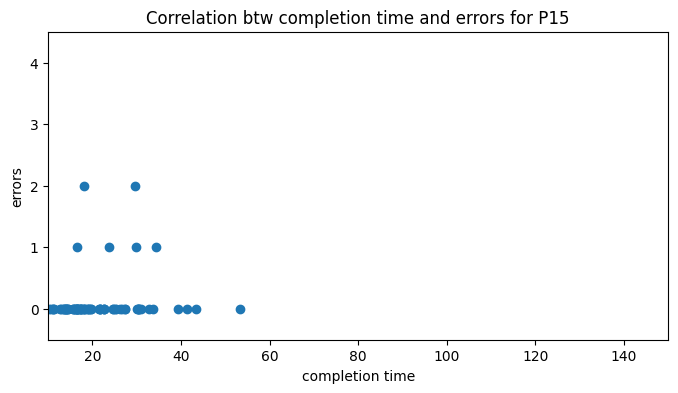

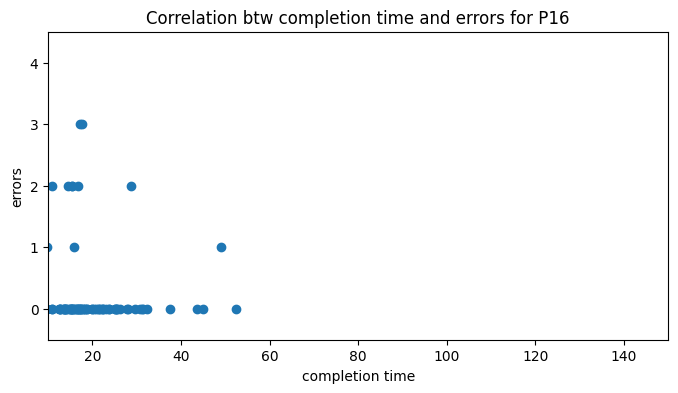

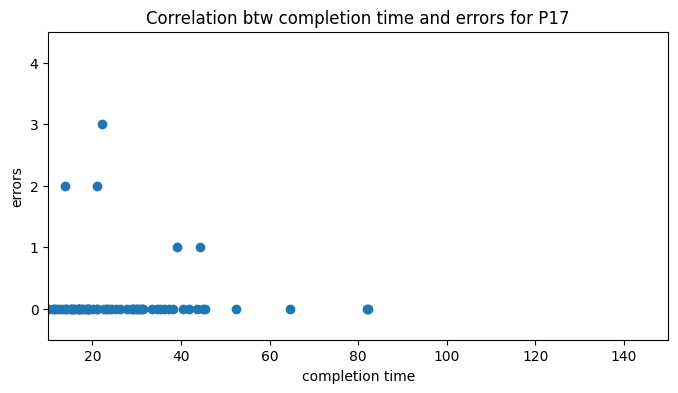

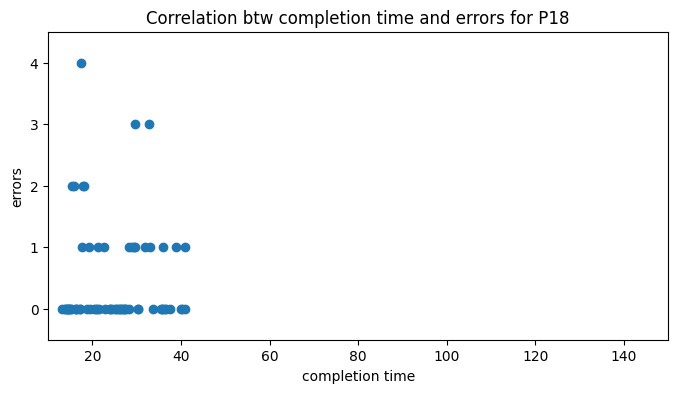

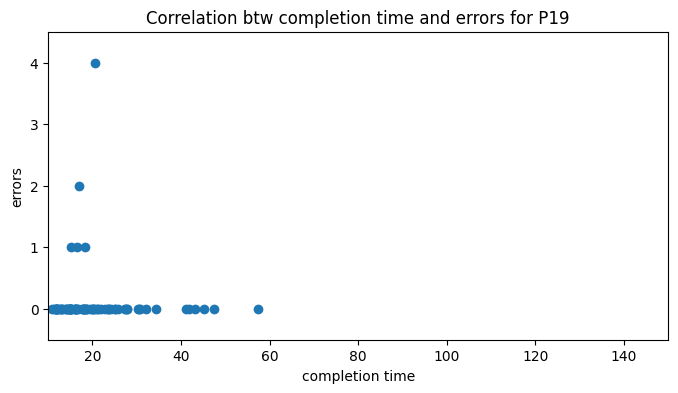

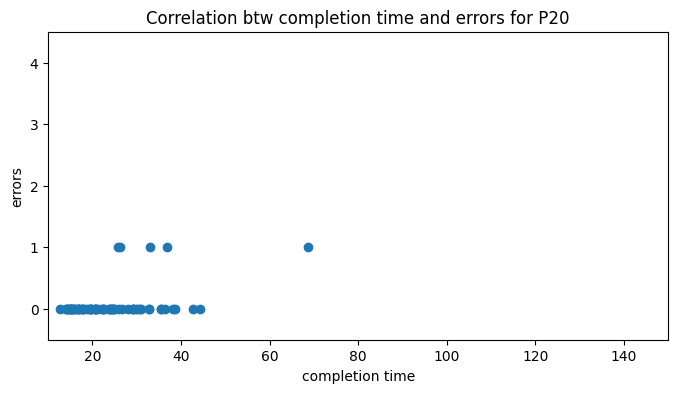

In [16]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['completion_time'], participant_df['errors'])
    plt.title(f'Correlation btw completion time and errors for P{pid}')
    plt.xlabel('completion time')
    plt.ylabel('errors')
    plt.xlim(10, 150)
    plt.ylim(-.5, 4.5)
    plt.show()

##### Reaction time-task block duration correlation
- No correlation

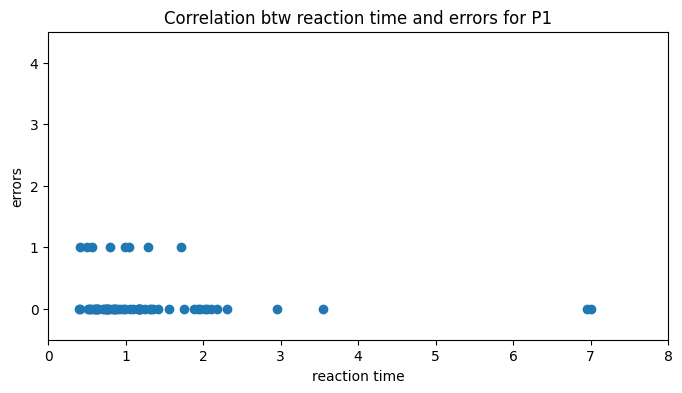

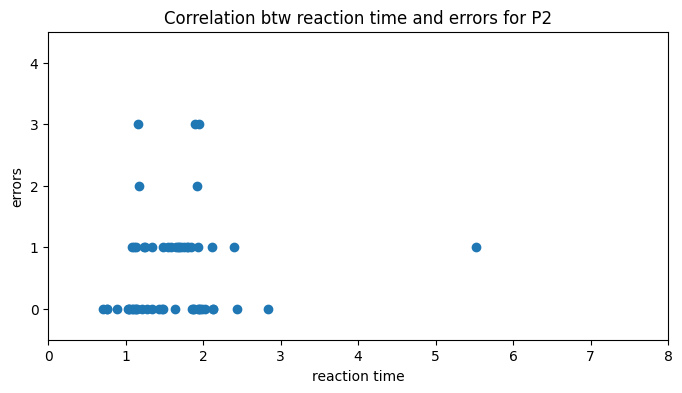

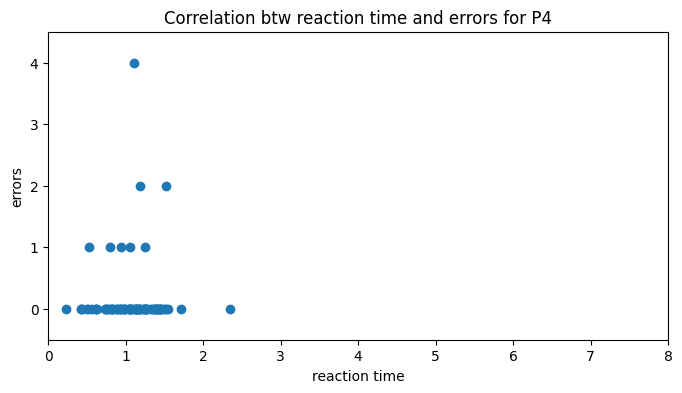

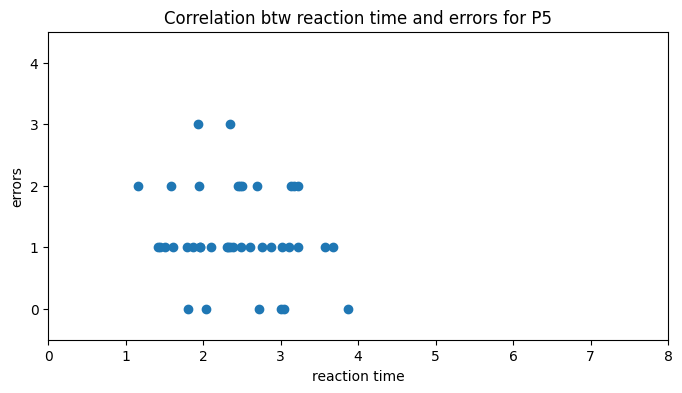

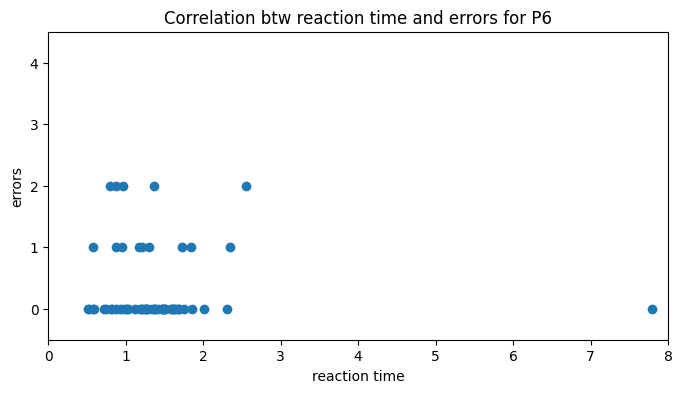

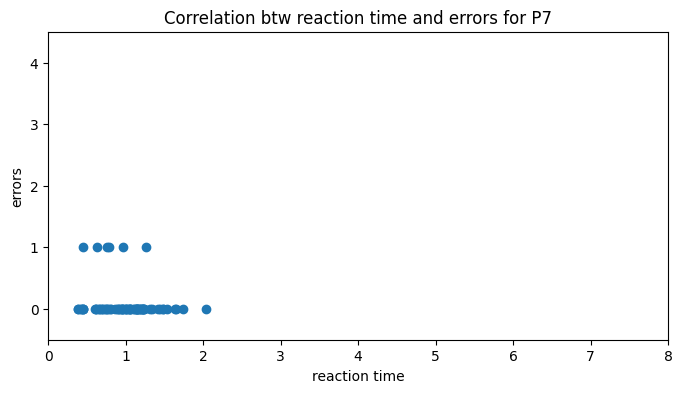

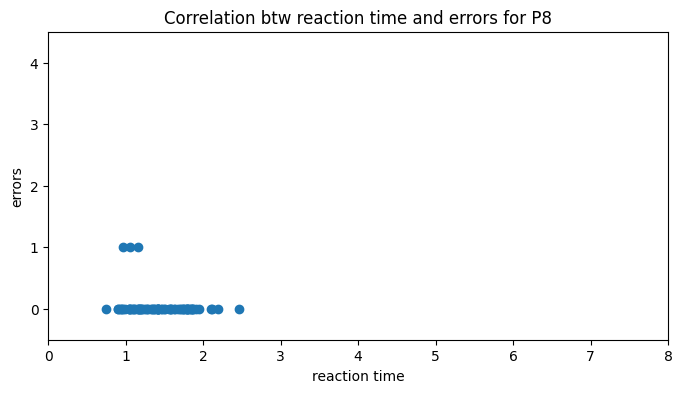

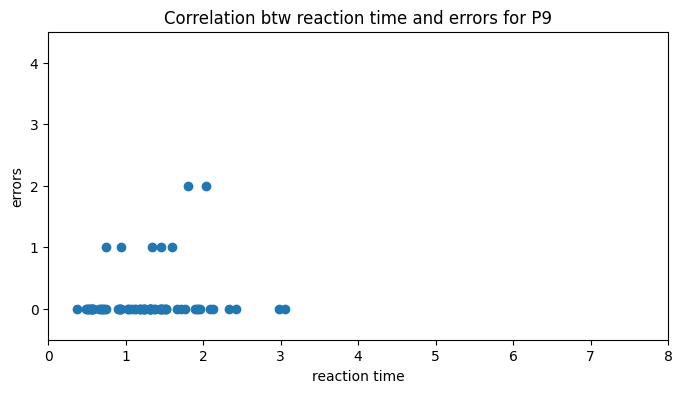

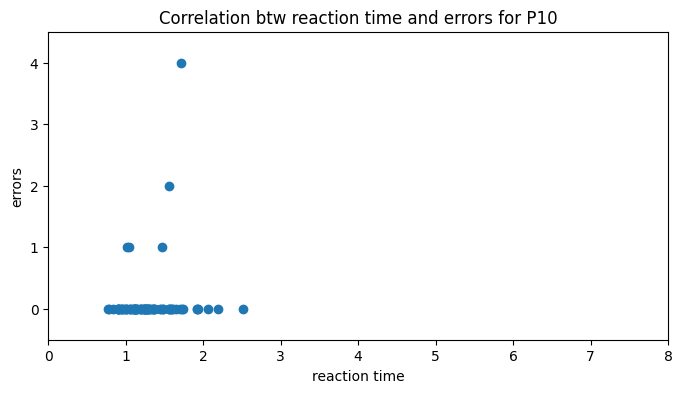

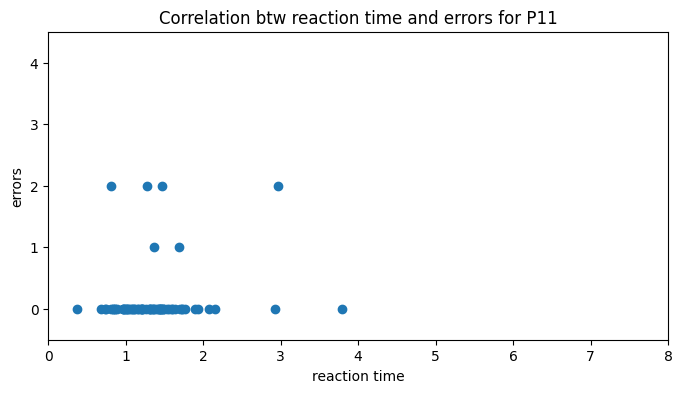

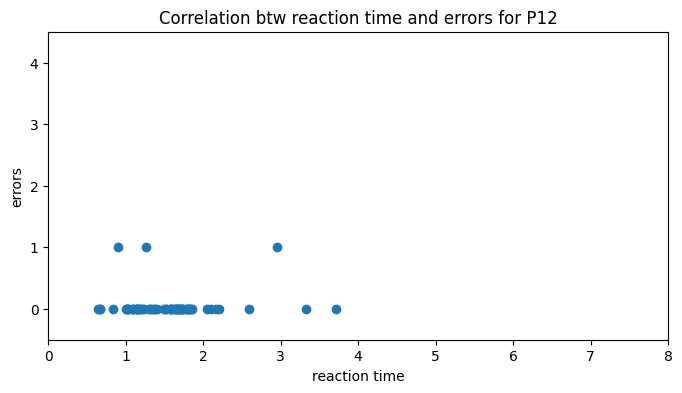

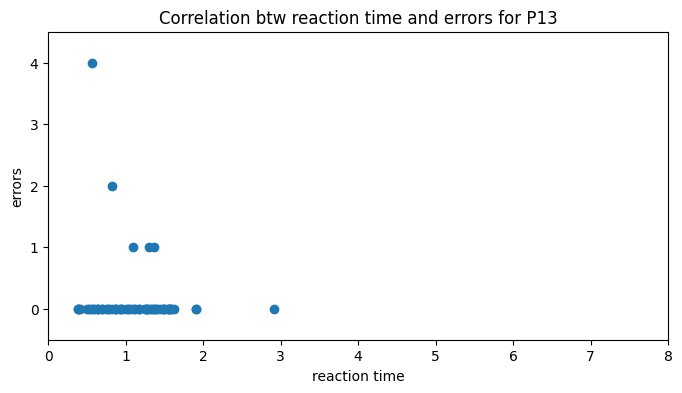

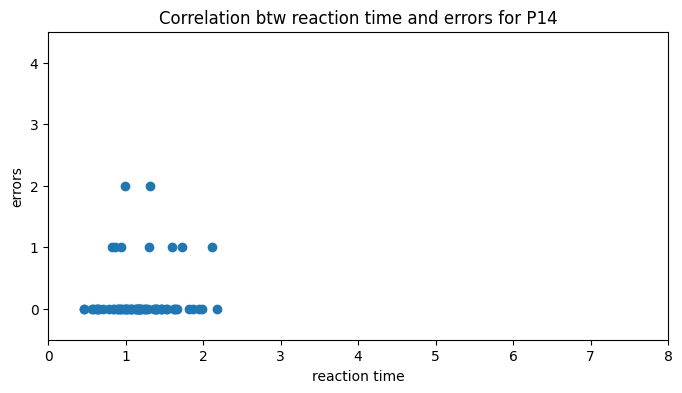

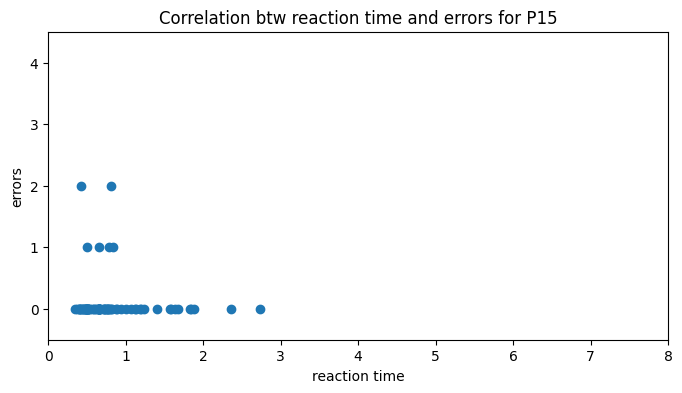

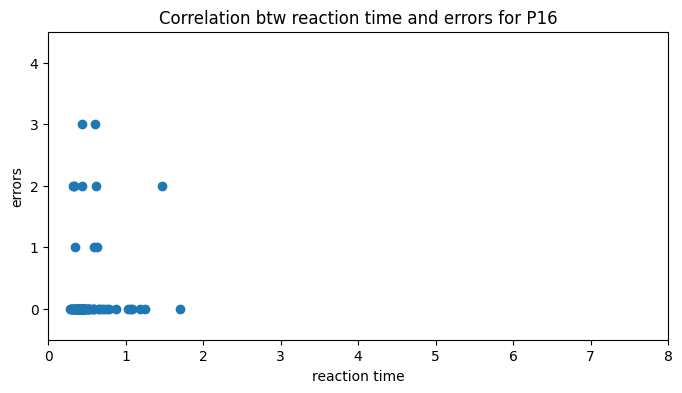

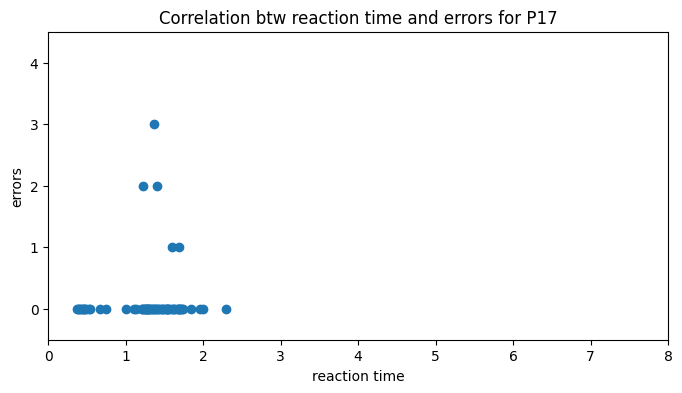

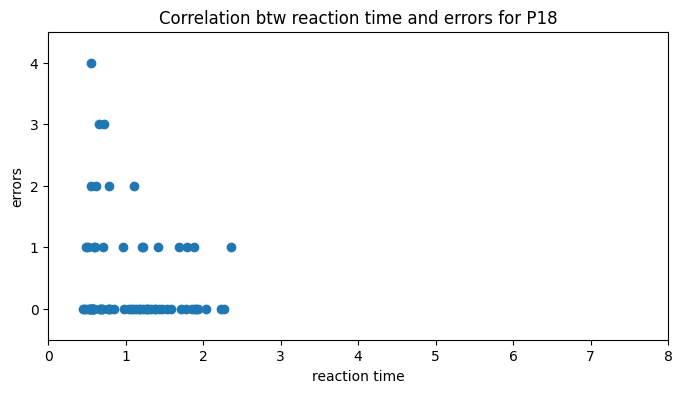

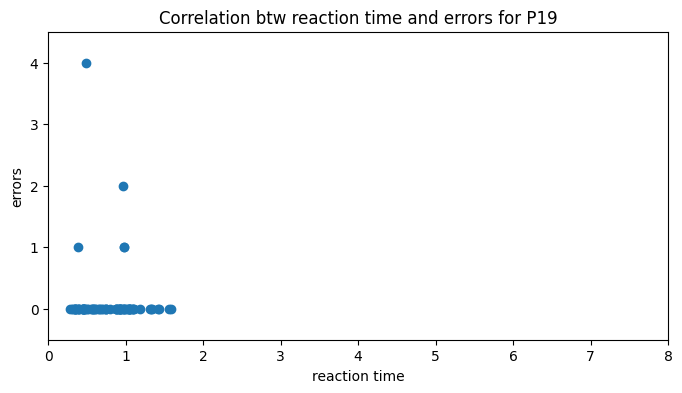

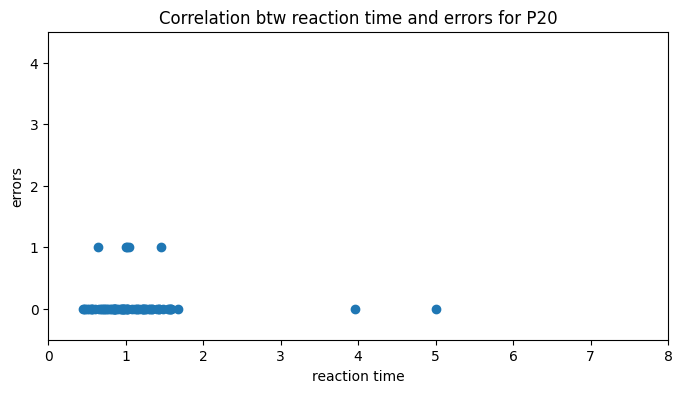

In [17]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(8, 4))
    plt.scatter(participant_df['reaction_time'], participant_df['errors'])
    plt.title(f'Correlation btw reaction time and errors for P{pid}')
    plt.xlabel('reaction time')
    plt.ylabel('errors')
    plt.xlim(0, 8)
    plt.ylim(-.5, 4.5)
    plt.show()

##### Task block duration boxplot
- Higher task block duration in P01 (block 1) --> training?

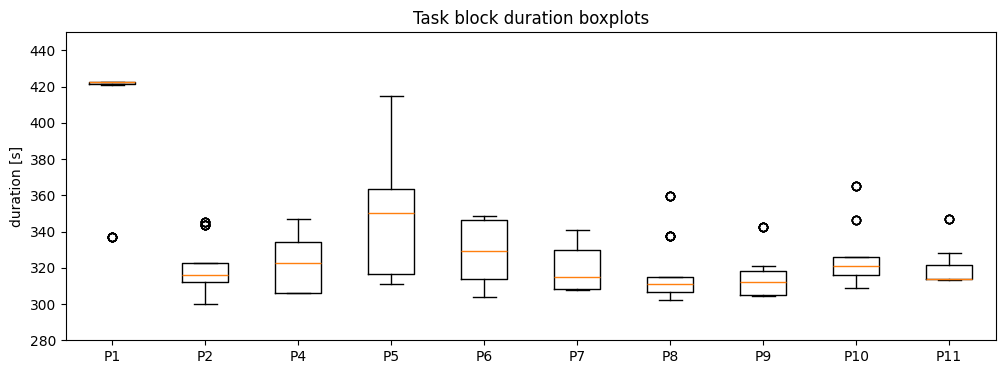

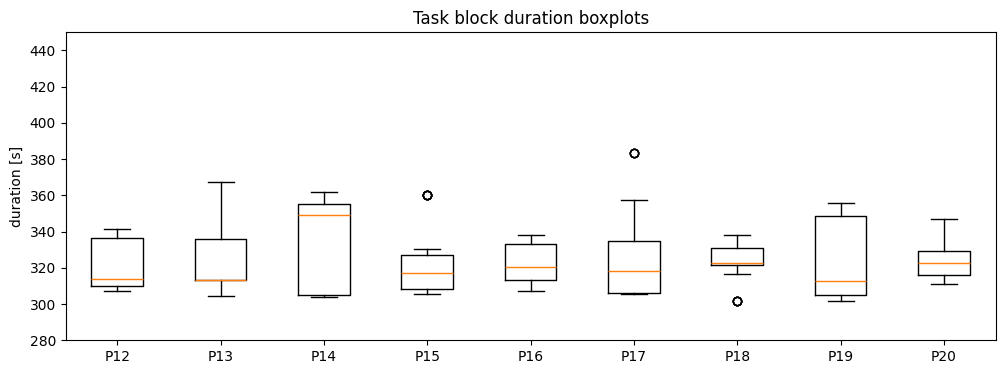

In [36]:
grouped_ids = [participant_ids[i:i+10] for i in range(0, len(participant_ids), 10)] #group ids
for group in grouped_ids: #iterate groups
    participants_block_durations = [df.query(f"participant_id == {pid}")['block_data'].apply(lambda x: x[1]) for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(12, 4))
    plt.boxplot(participants_block_durations, whis = 1.5)
    plt.title(f'Task block duration boxplots')
    plt.ylabel('duration [s]')
    plt.ylim(280, 450)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()
    

##### Completion time boxplot
- Good

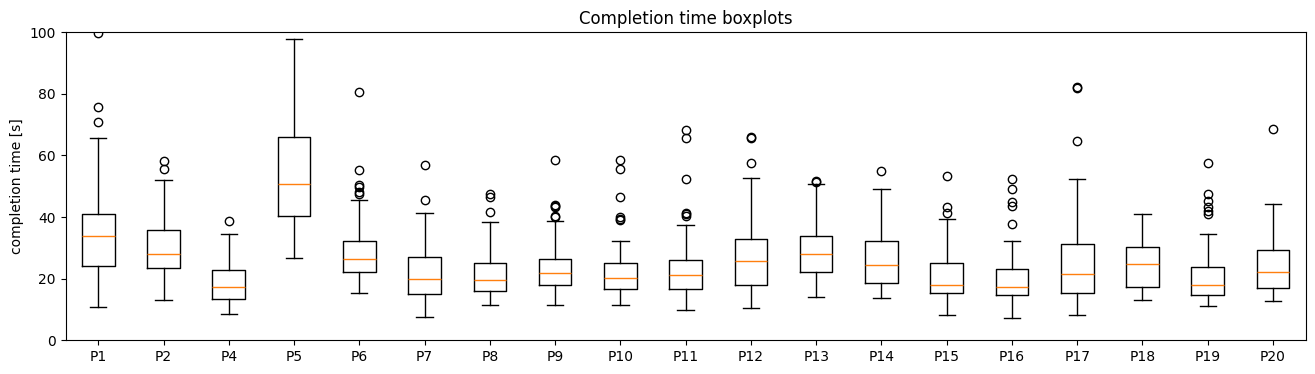

In [4]:
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_df = [df.query(f"participant_id == {pid}")['completion_time'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_df, whis = 1.5)
    plt.title(f'Completion time boxplots')
    plt.ylabel('completion time [s]')
    plt.ylim(0, 100)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()

##### Reaction time boxplot
- Higher RT are outliers (?)

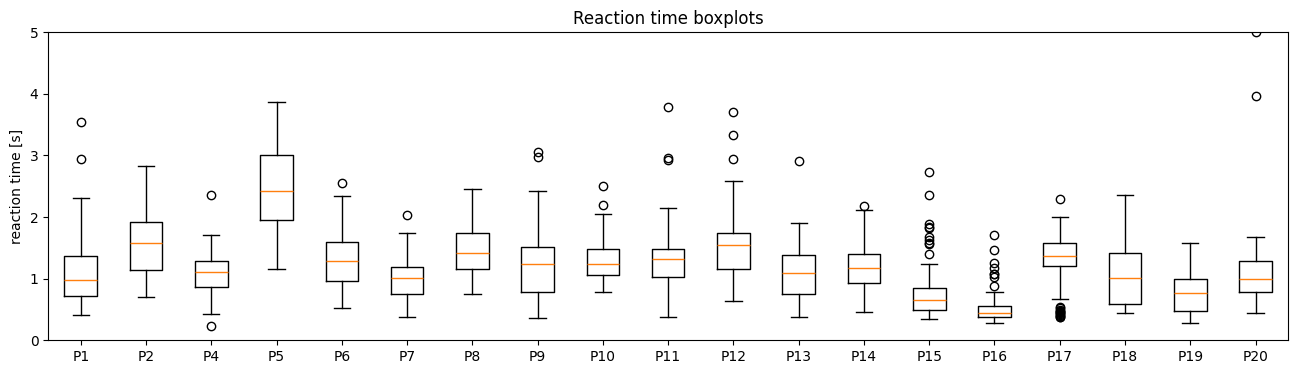

In [7]:
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_df = [df.query(f"participant_id == {pid}")['reaction_time'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_df, whis = 1.5)
    plt.title(f'Reaction time boxplots')
    plt.ylabel('reaction time [s]')
    plt.ylim(0, 5)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()

##### Errors boxplot
- ...

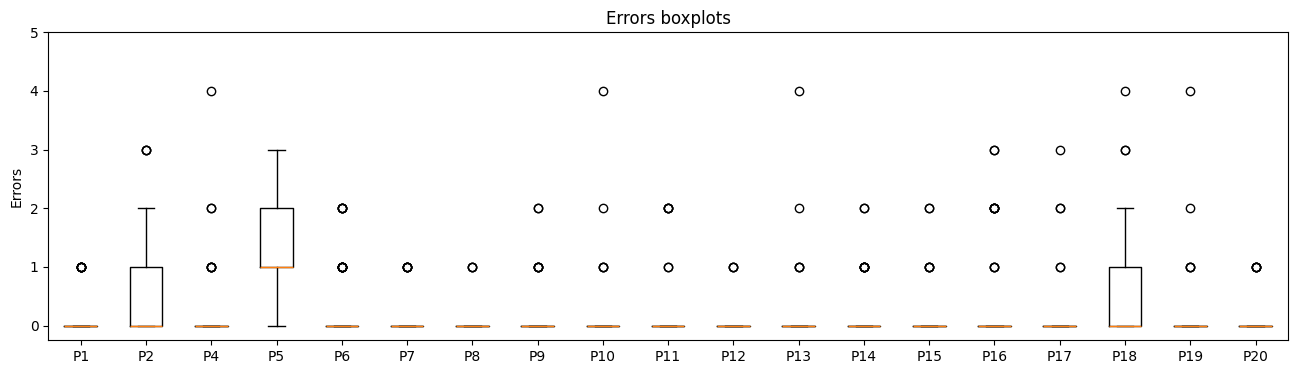

In [8]:
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_df = [df.query(f"participant_id == {pid}")['errors'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_df, whis = 1.5)
    plt.title(f'Errors boxplots')
    plt.ylabel('Errors')
    plt.ylim(-.25, 5)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()

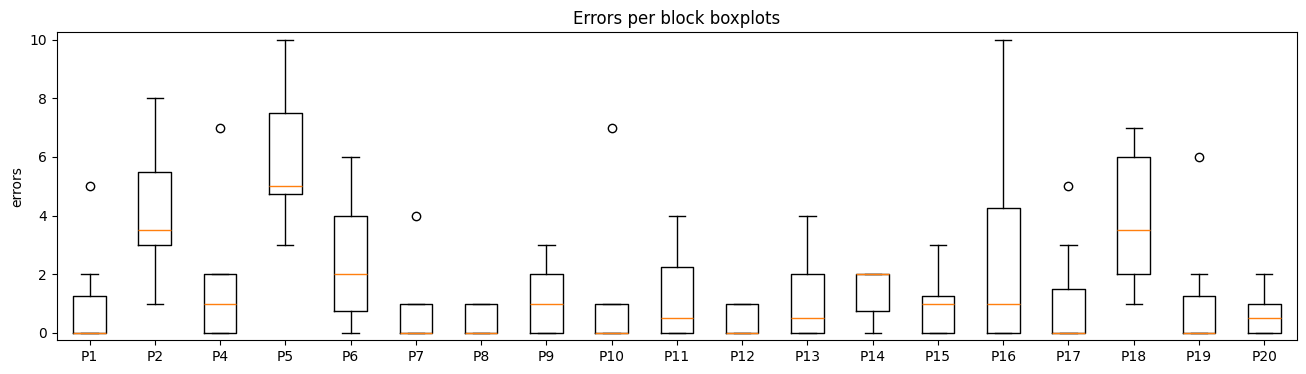

In [10]:
mean_errors_df = df.groupby(['participant_id','block_id'])['errors'].sum().reset_index()
grouped_ids = [participant_ids[i:i+19] for i in range(0, len(participant_ids), 19)] #group ids
for group in grouped_ids: #iterate groups
    participants_df = [mean_errors_df.query(f"participant_id == {pid}")['errors'] for pid in group] #get group's sub-ddfs
    plt.figure(figsize=(16, 4))
    plt.boxplot(participants_df, whis = 1.5)
    plt.title(f'Errors per block boxplots')
    plt.ylabel('errors')
    plt.ylim(-.25, 10.25)
    plt.xticks(range(1, len(group) + 1), [f'P{pid}' for pid in group]) #single boxplots labels
    plt.show()


### 3. Time-Series Assessment
Task Block, Completion time, Reaction time, Errors

##### Task block duration overtime
- Good

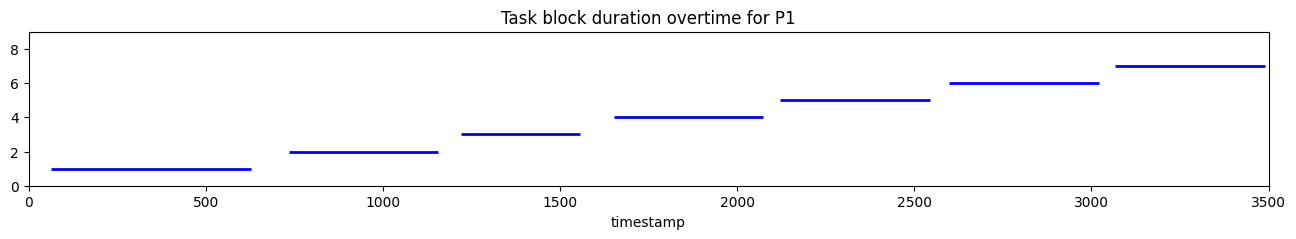

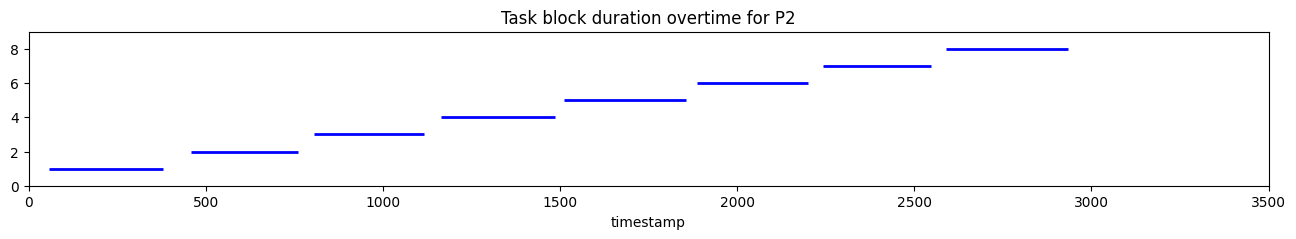

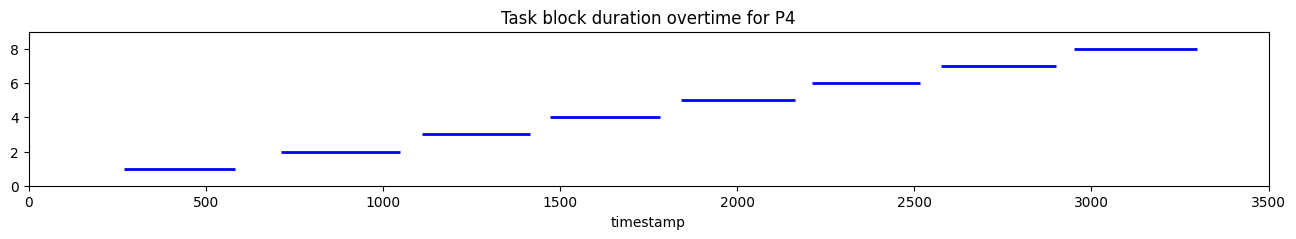

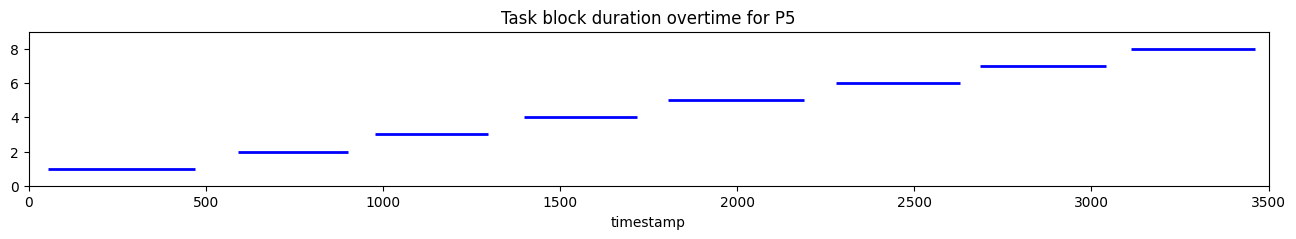

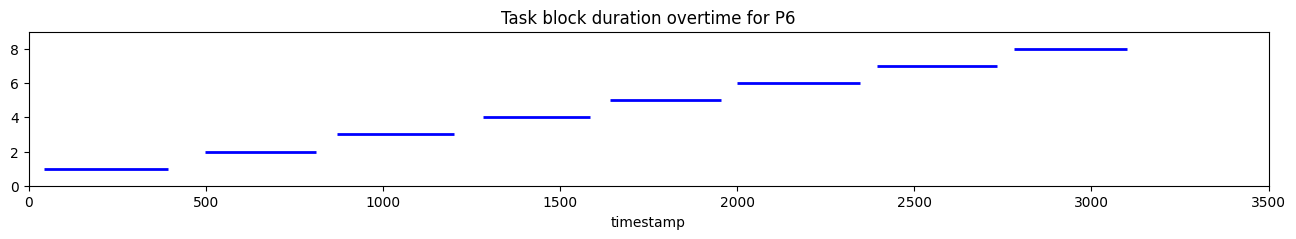

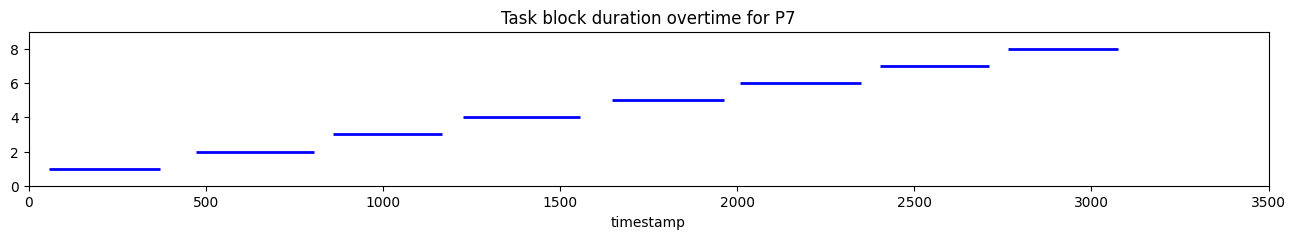

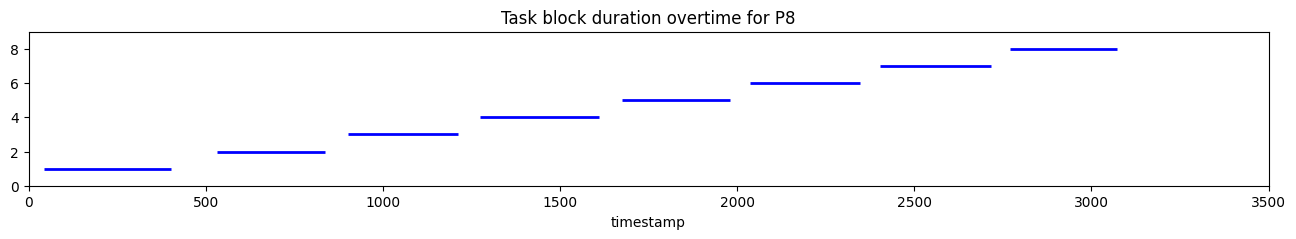

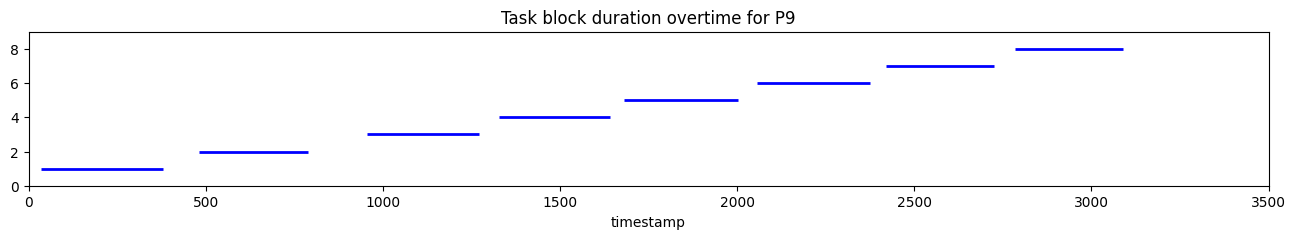

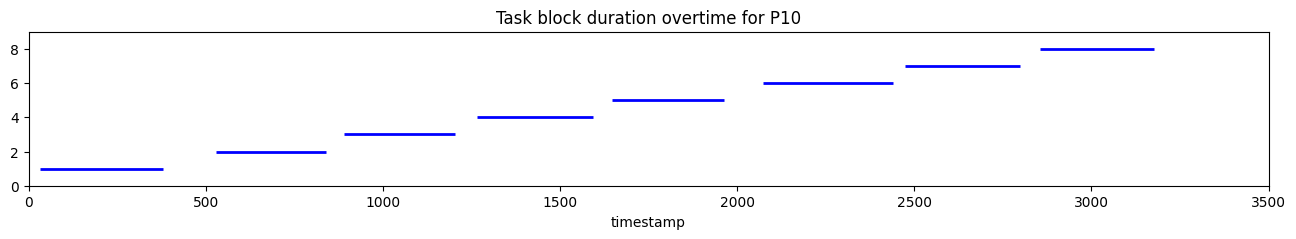

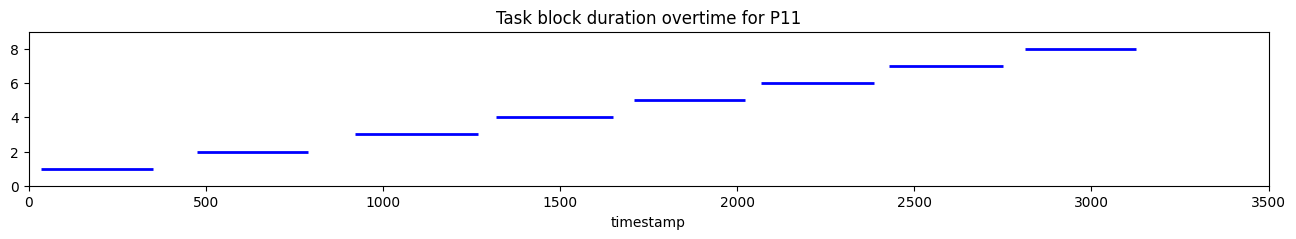

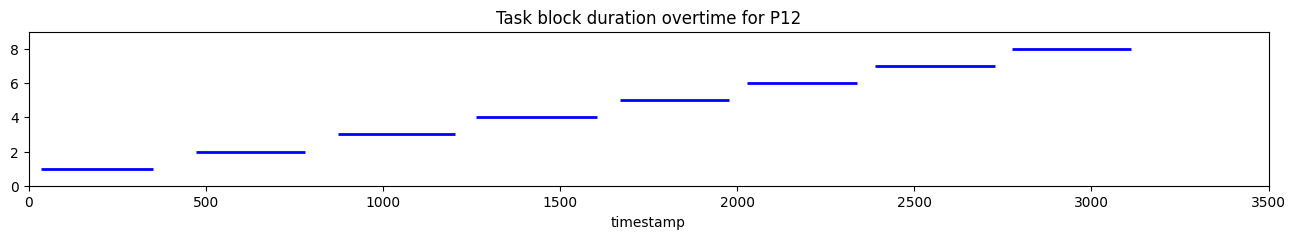

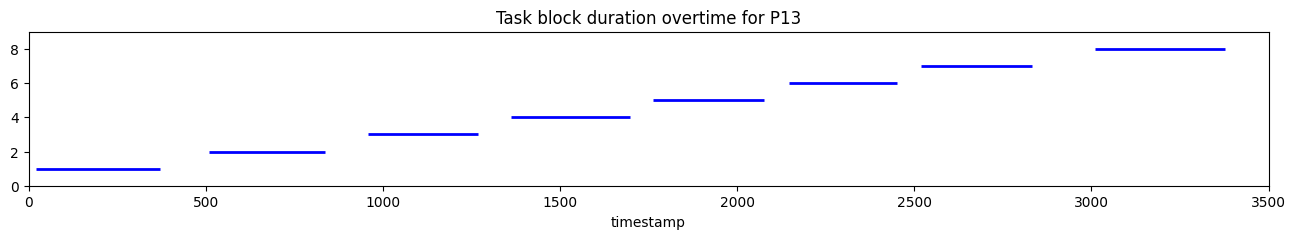

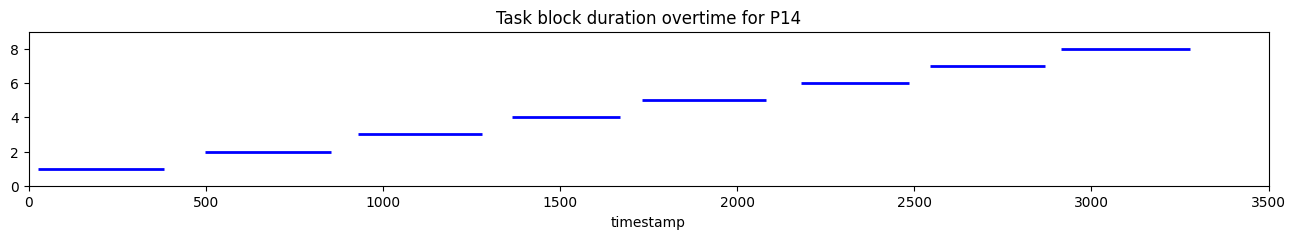

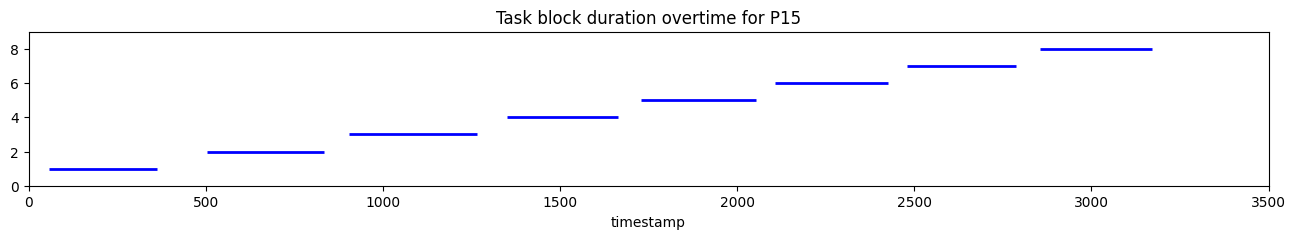

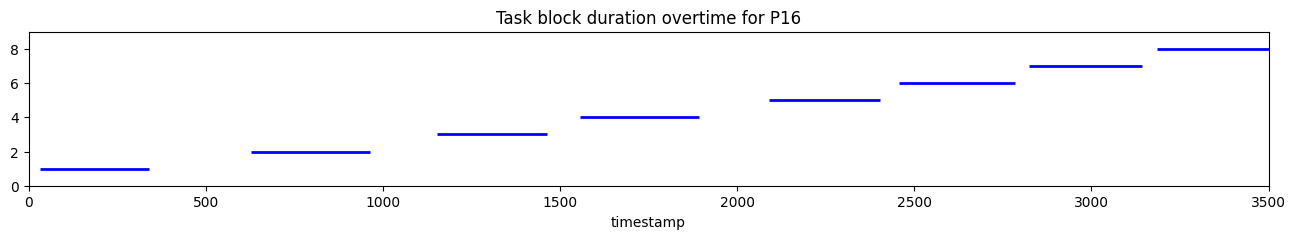

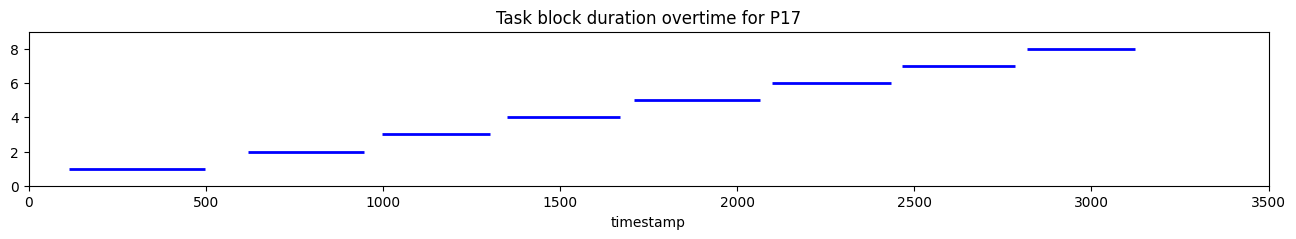

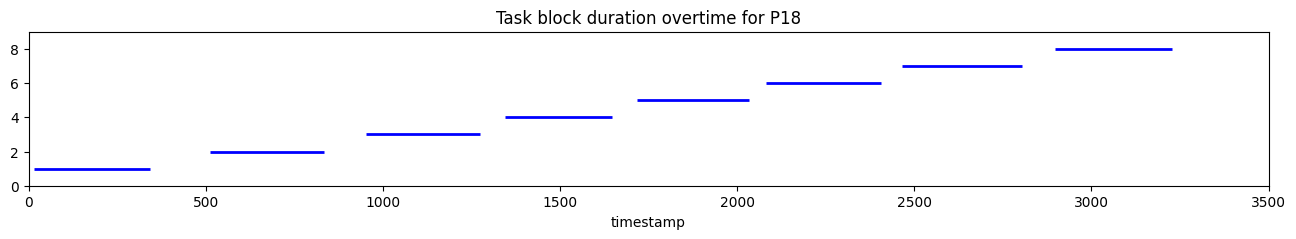

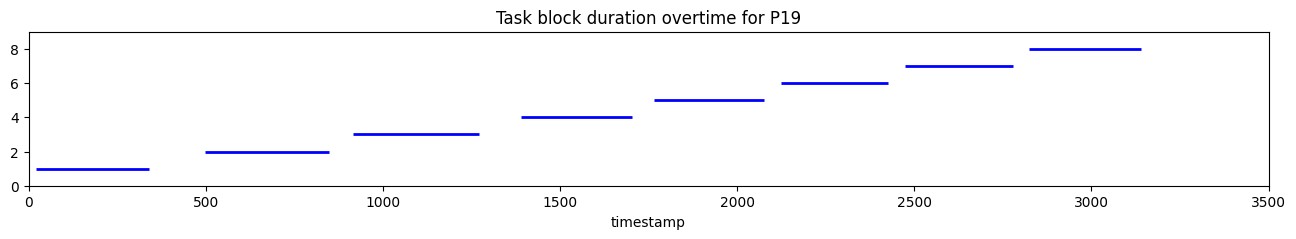

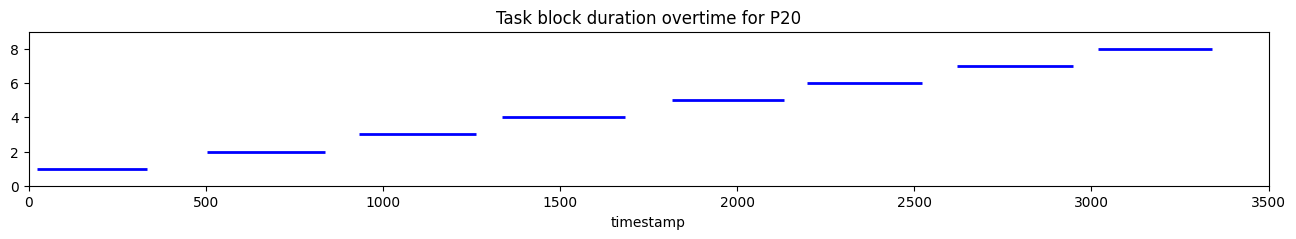

In [21]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    grouped = participant_df.groupby('block_id').agg({'block_data': 'first'}).reset_index()
    ids = grouped['block_id']
    starts = grouped['block_data'].apply(lambda x: x[0])
    ends = grouped['block_data'].apply(lambda x: x[2])
    plt.figure(figsize=(16, 2))
    for i in range (0, len(starts)):
        plt.hlines(y=ids[i], xmin=starts[i], xmax=ends[i], color='b', linewidth=2)
    plt.title(f'Task block duration overtime for P{pid}')
    plt.xlabel('timestamp')
    plt.xlim(0, 3500)
    plt.ylim(0, 9)
    plt.show()

##### Completion time overtime 
- Good

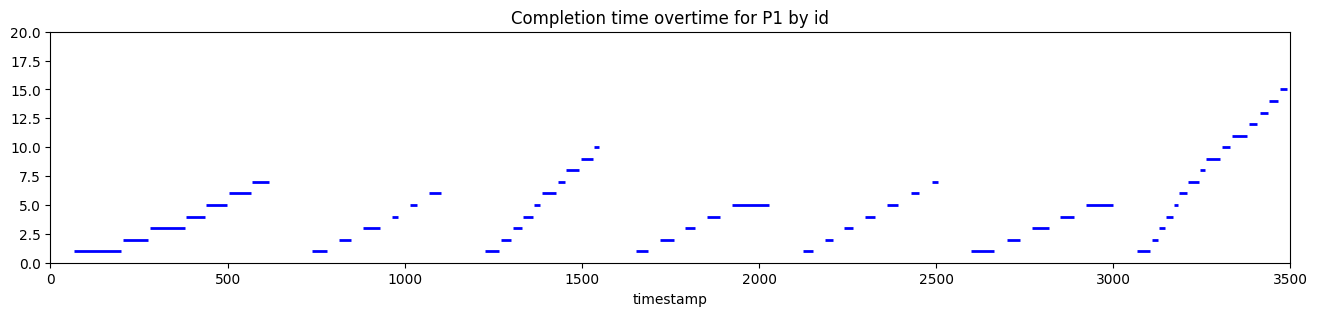

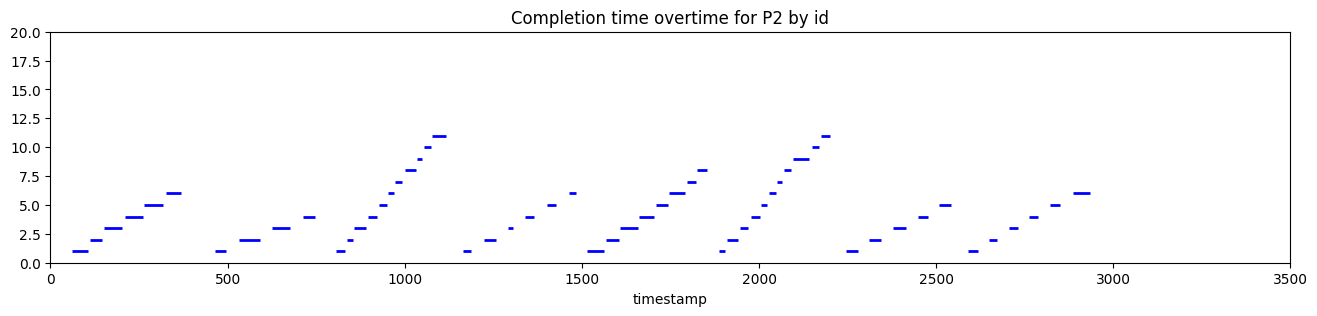

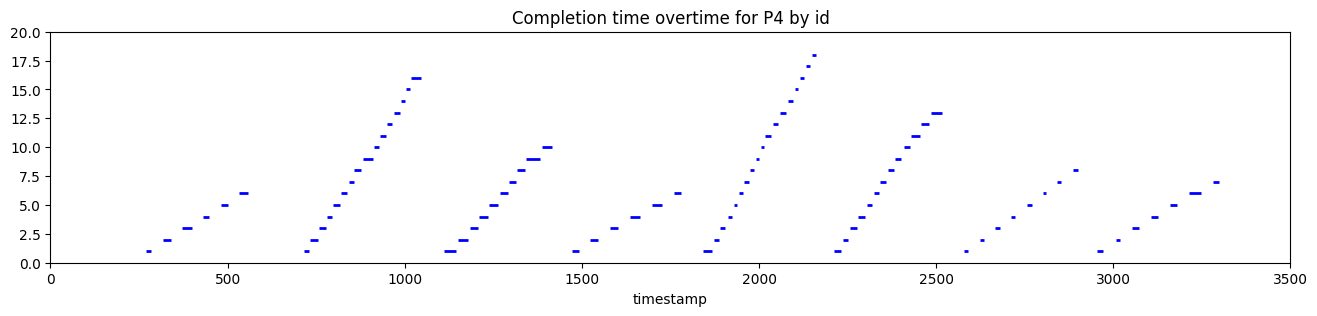

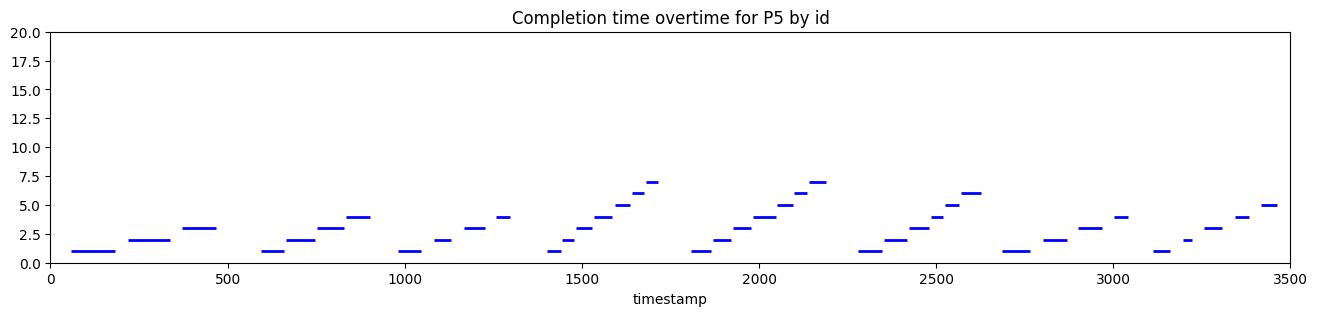

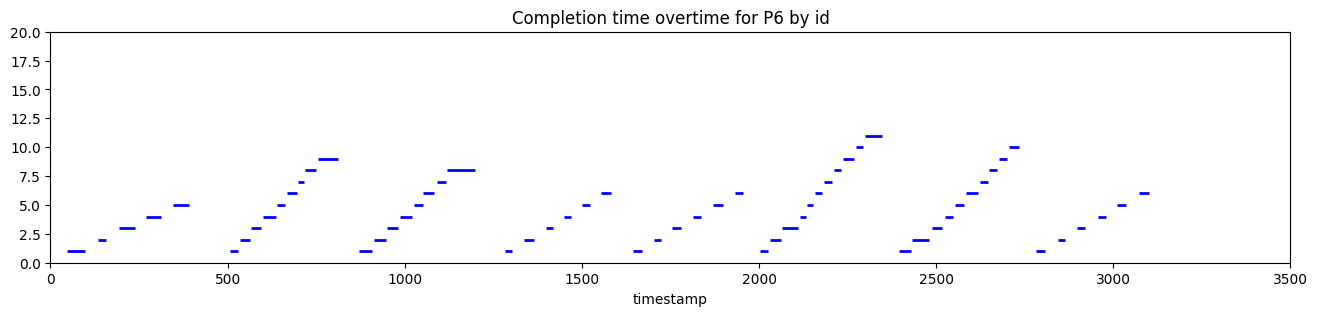

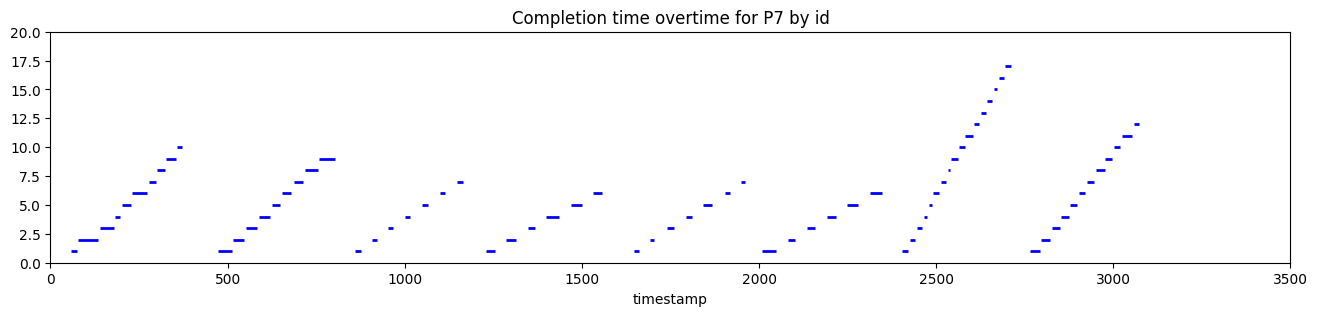

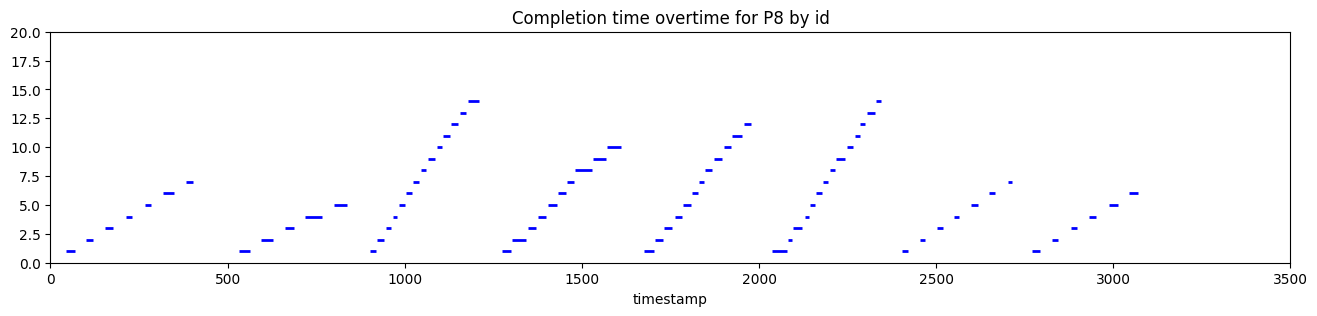

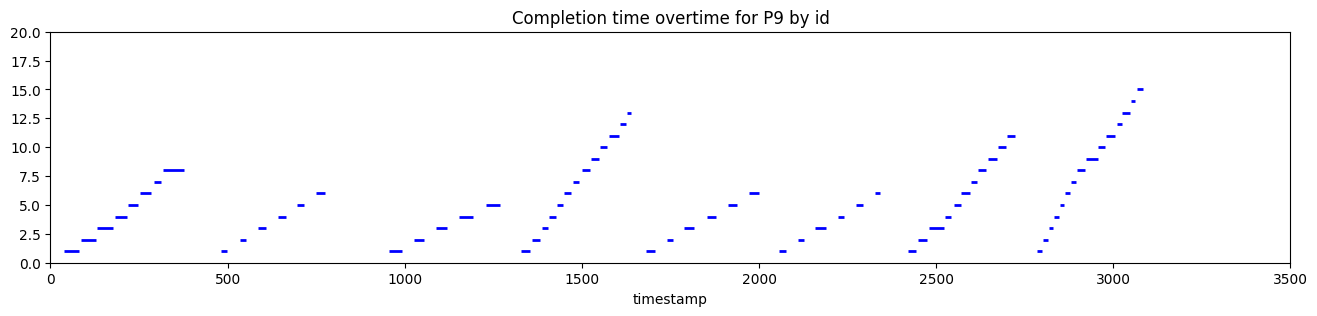

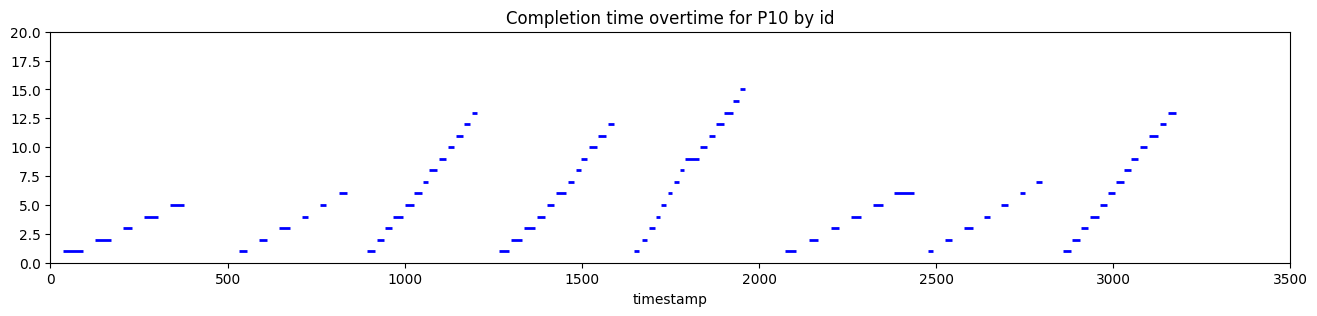

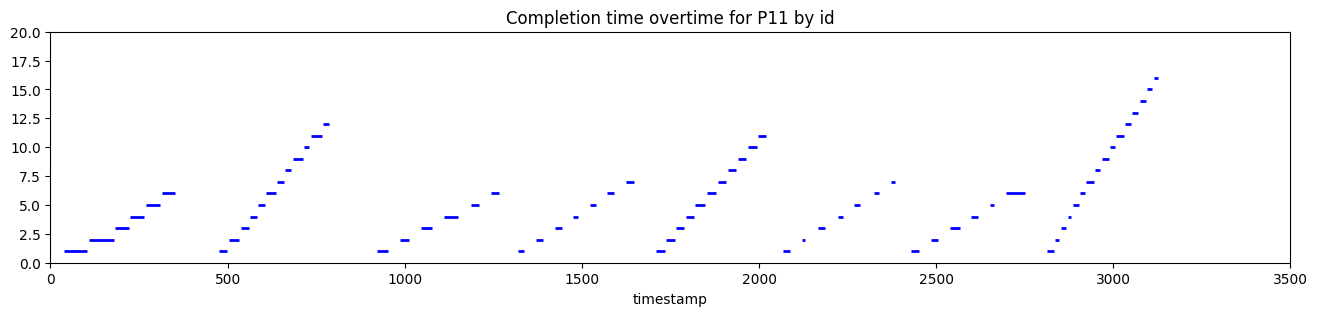

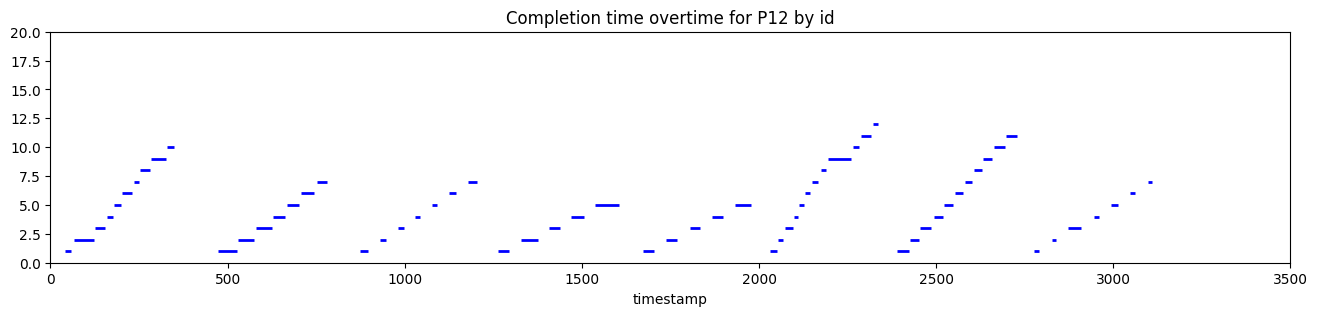

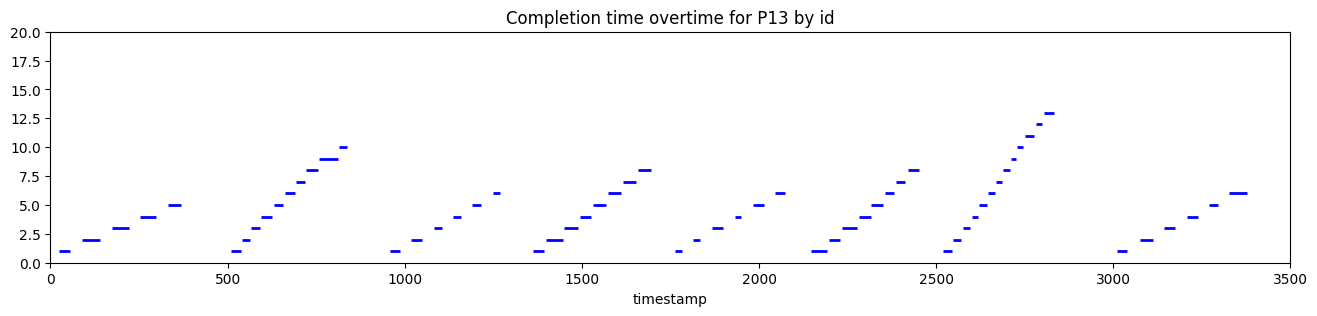

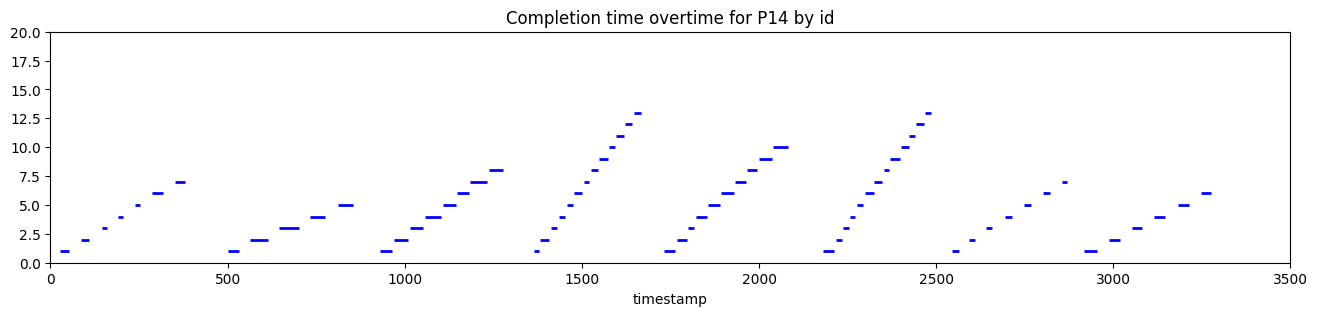

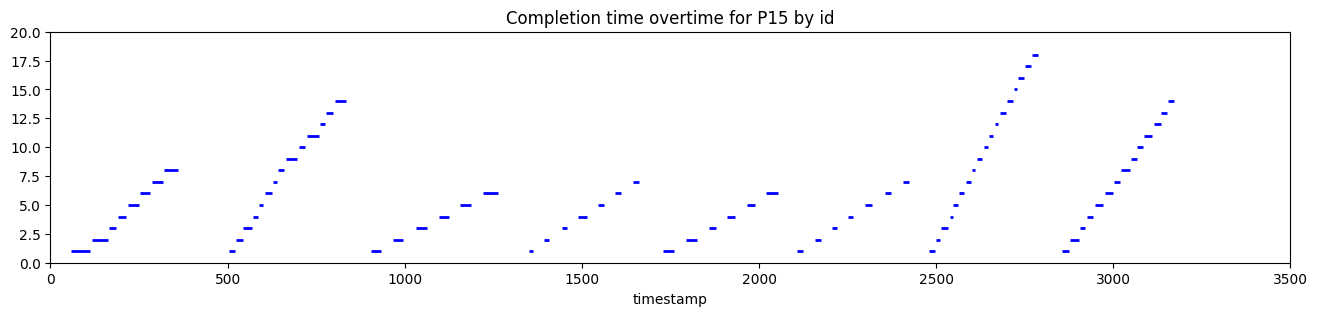

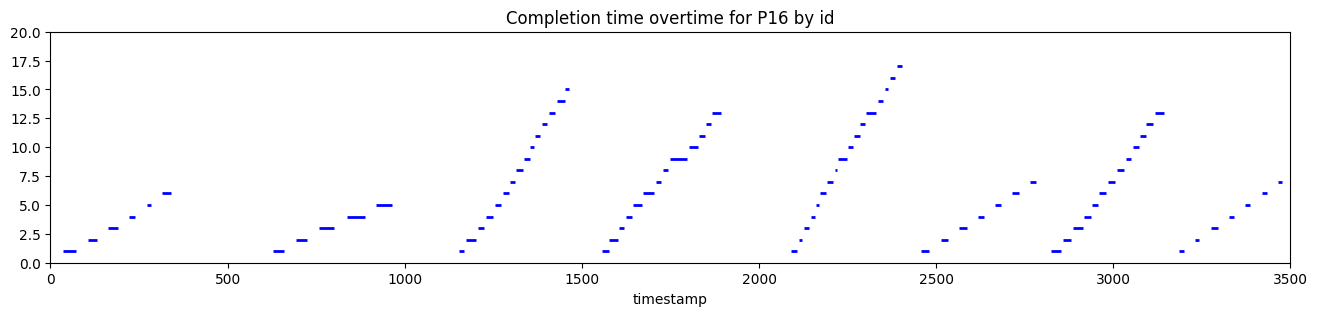

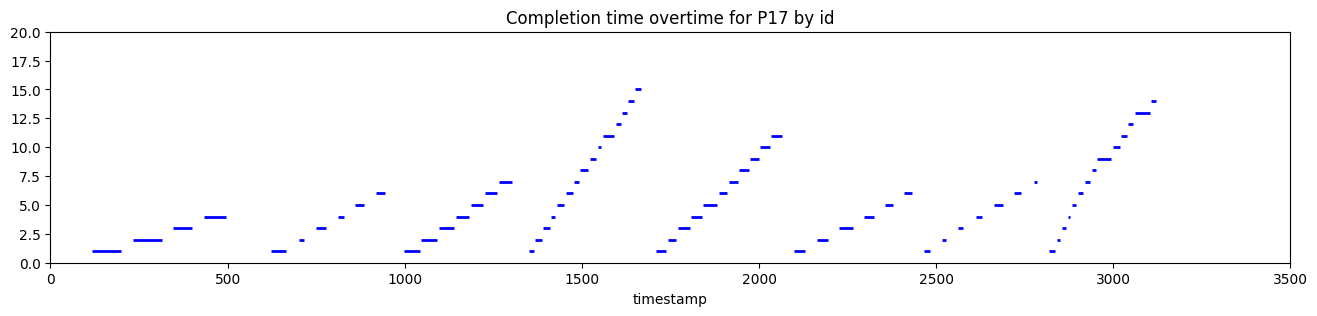

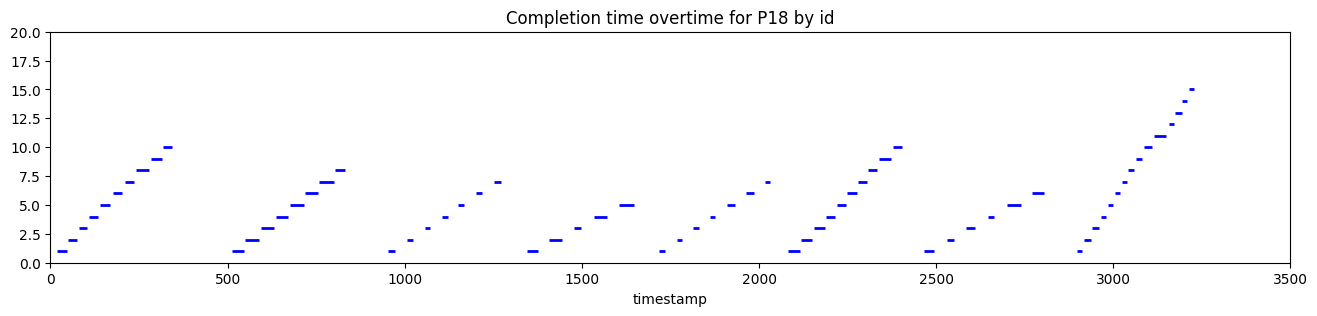

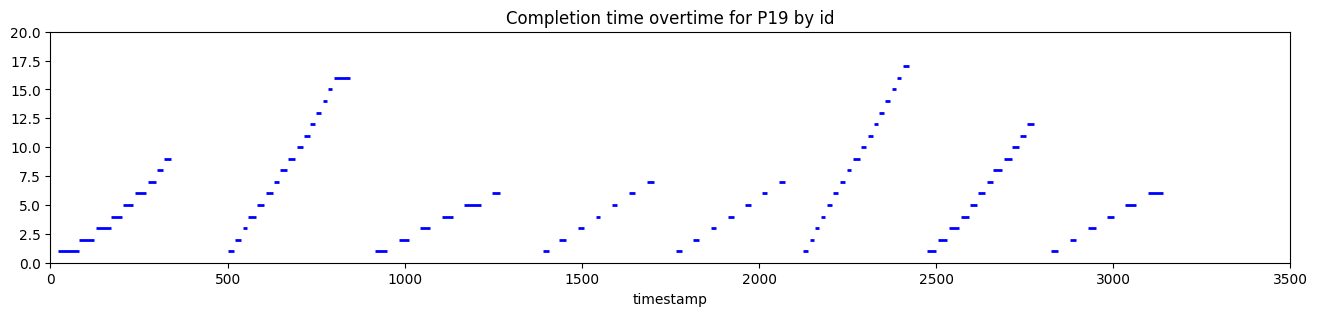

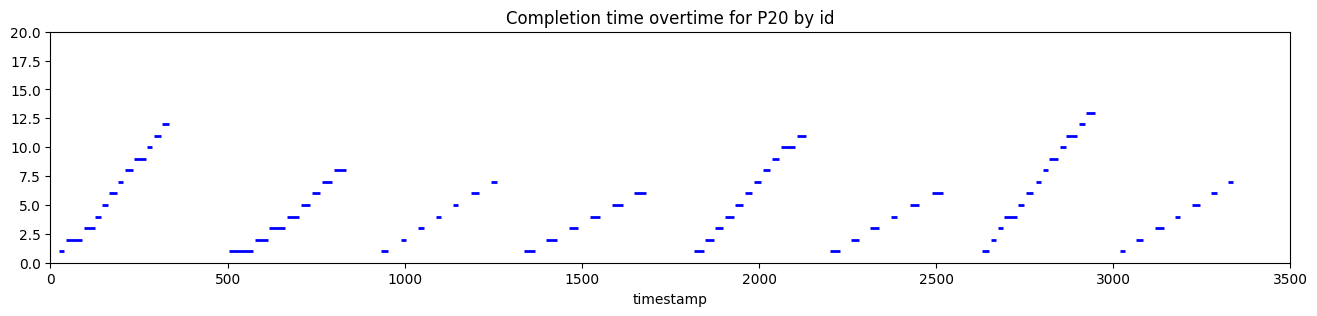

In [22]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(16, 3))
    for _, row in participant_df.iterrows():
        plt.hlines(y=row['task_id'], xmin=row['clicked_timestamp'], xmax=row['end_timestamp'], color='b', linewidth=2)
    plt.title(f'Completion time overtime for P{pid} by id')
    plt.xlabel('timestamp')
    plt.xlim(0, 3500)
    plt.ylim(0, 20)
    plt.show()

##### Reaction time overtime 
- Good

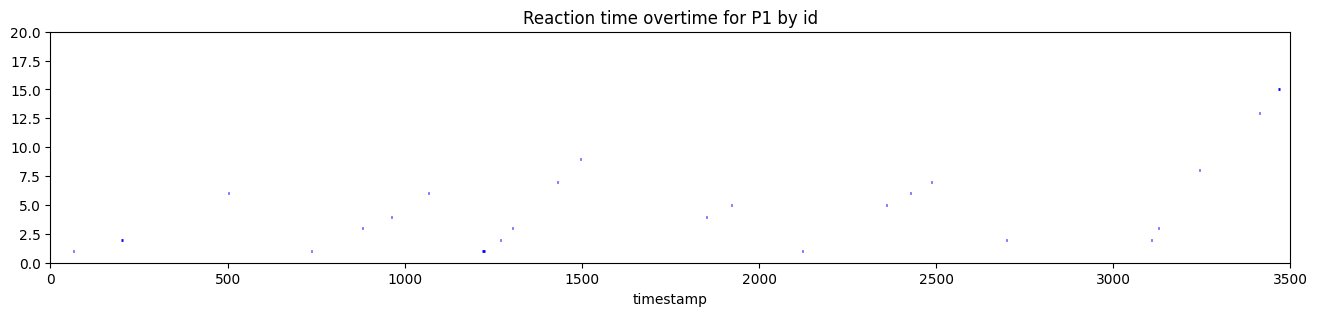

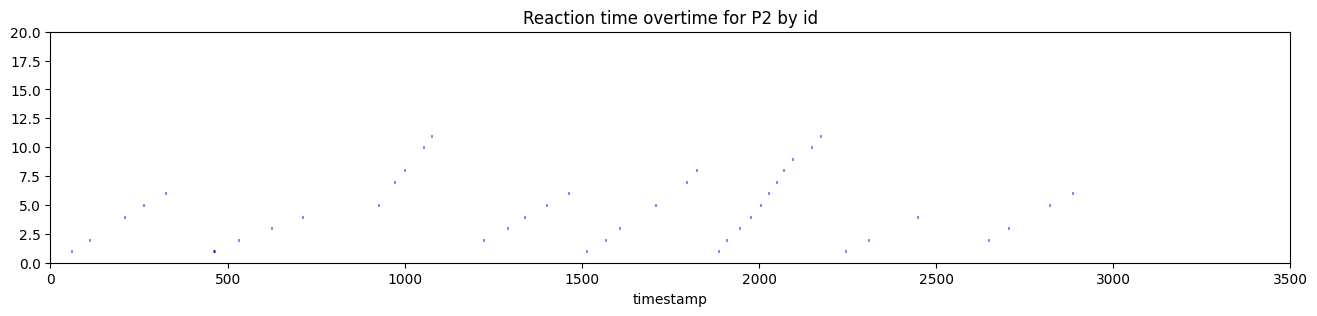

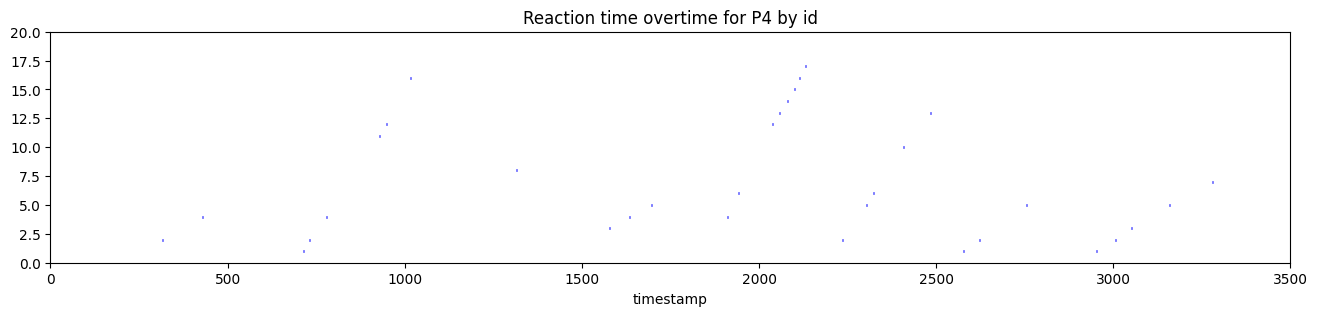

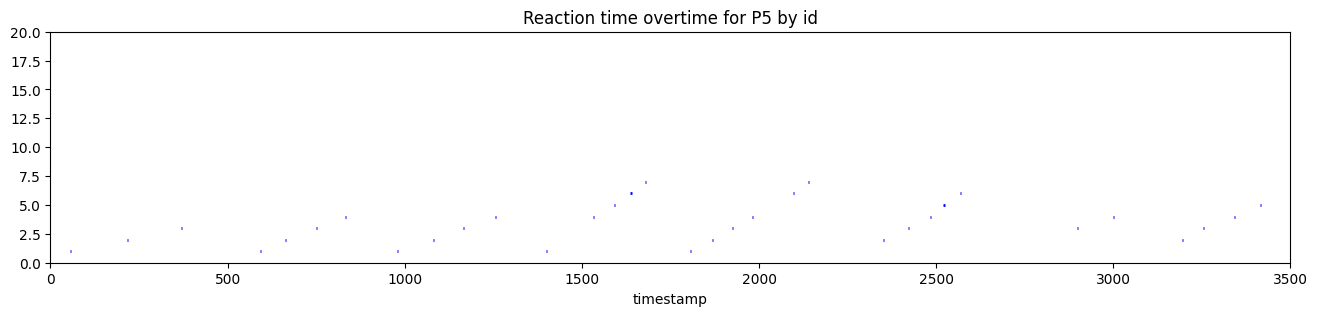

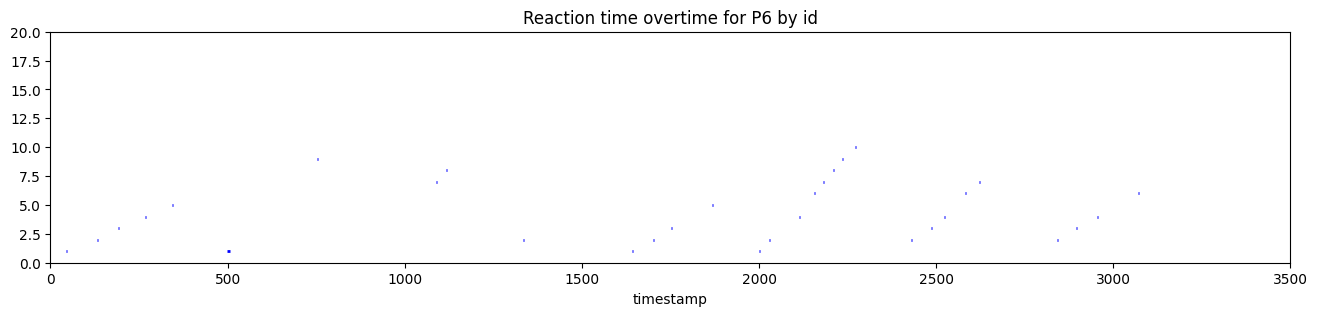

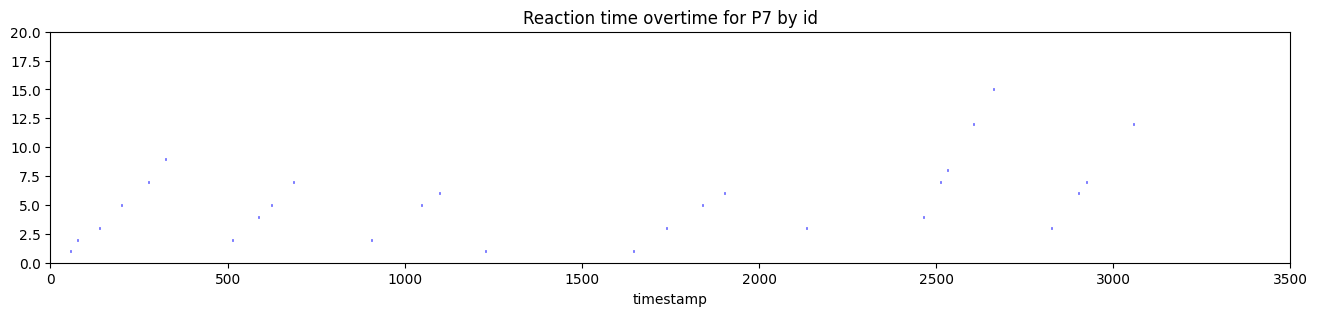

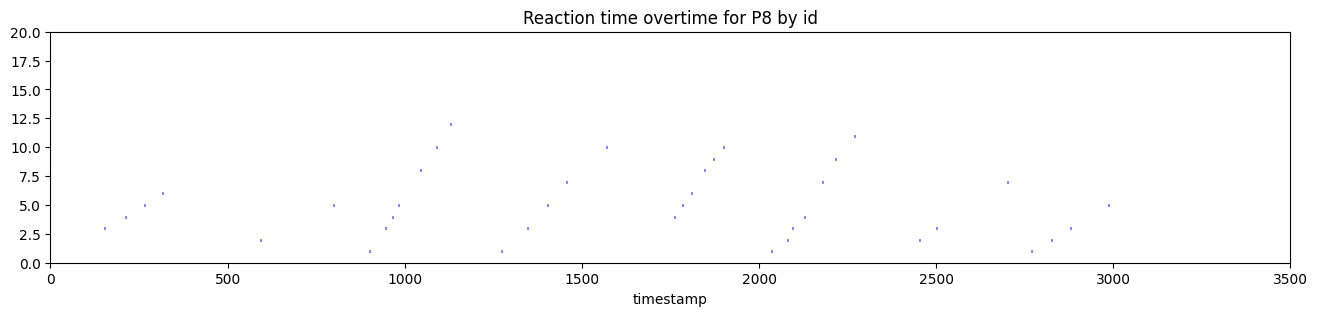

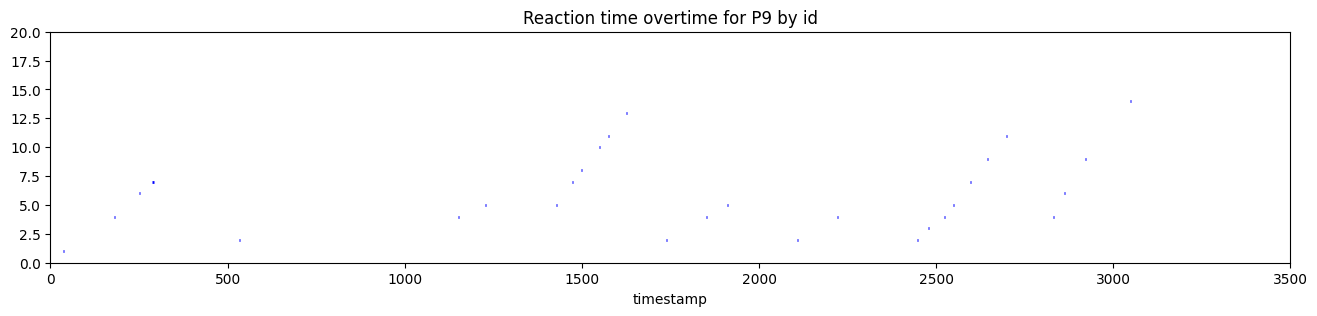

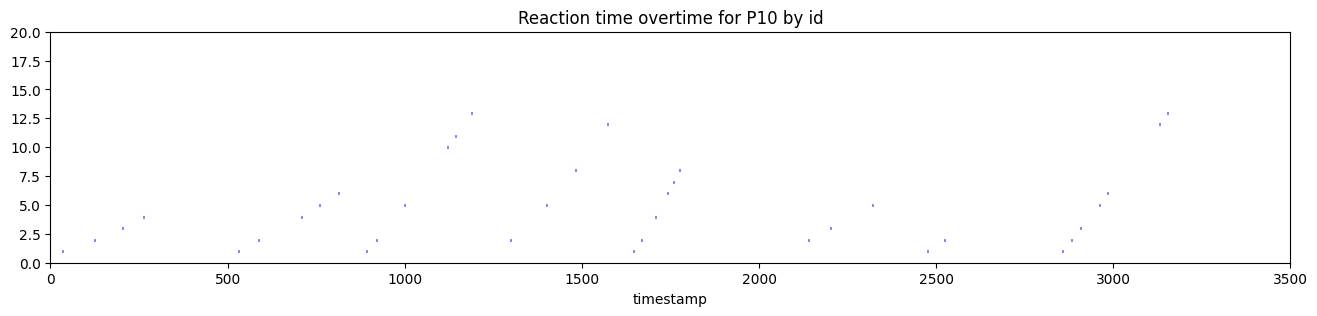

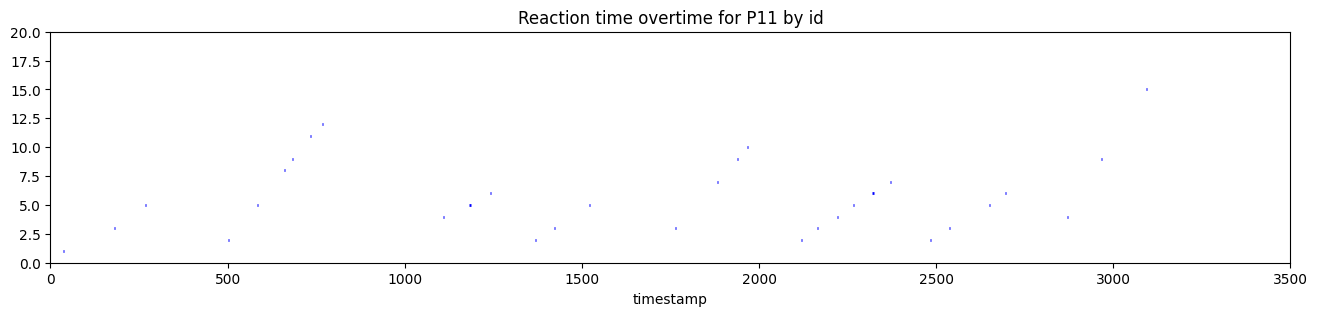

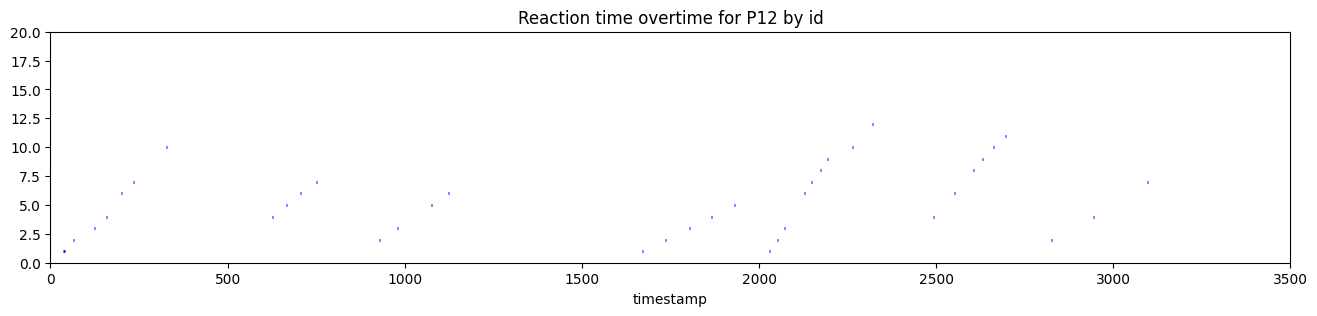

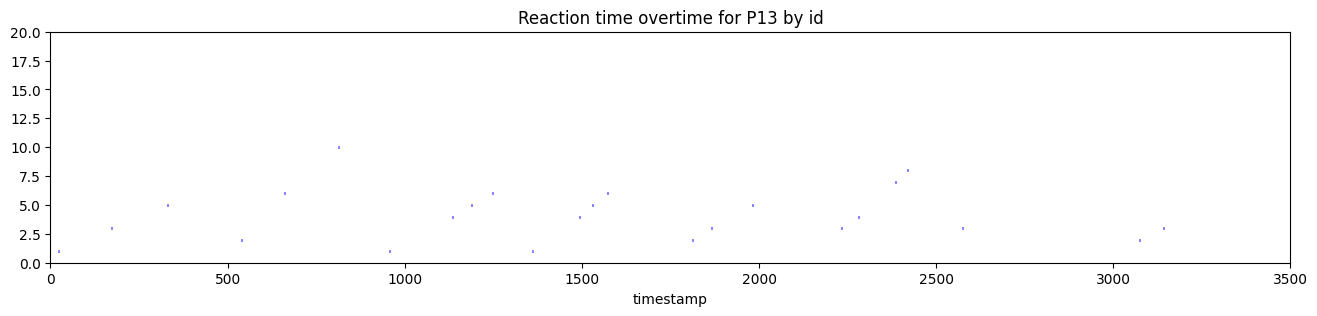

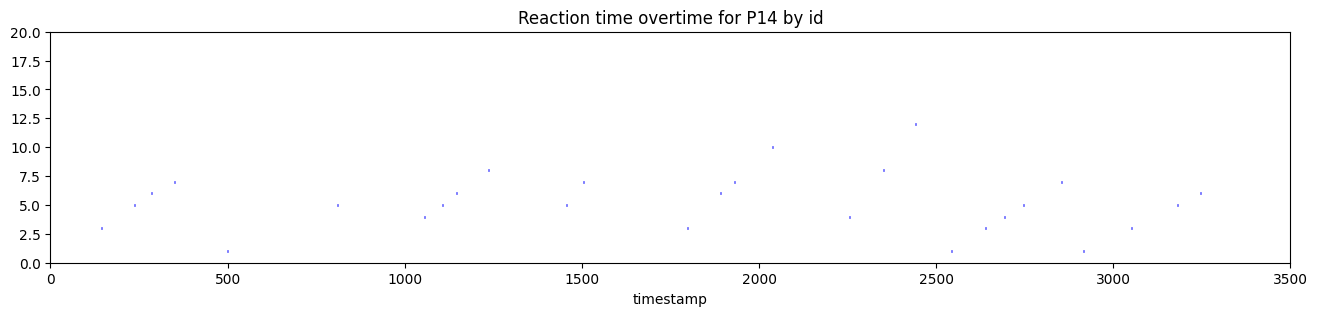

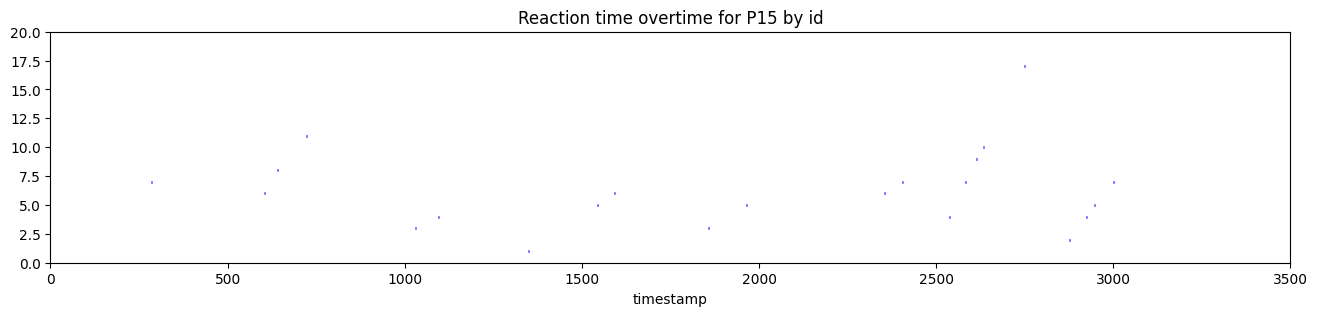

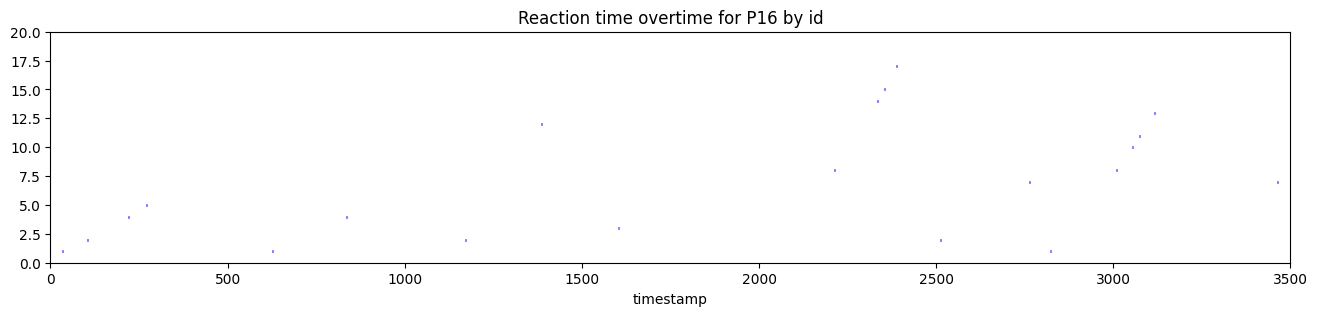

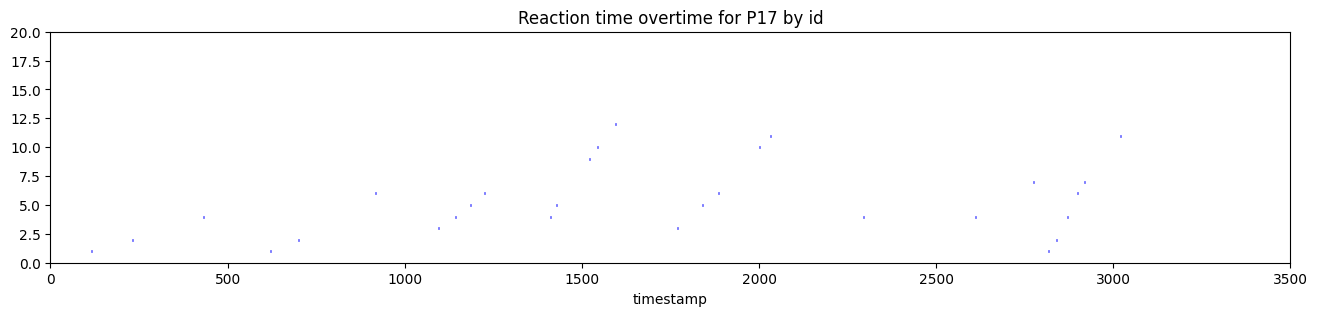

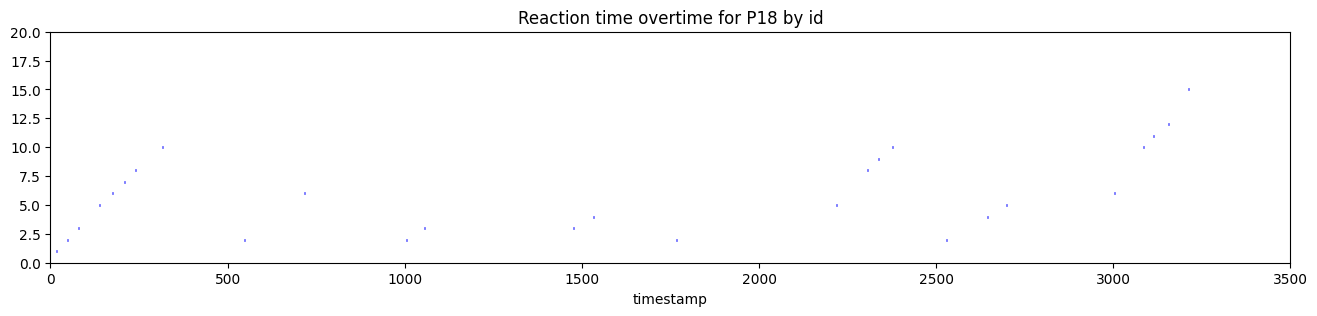

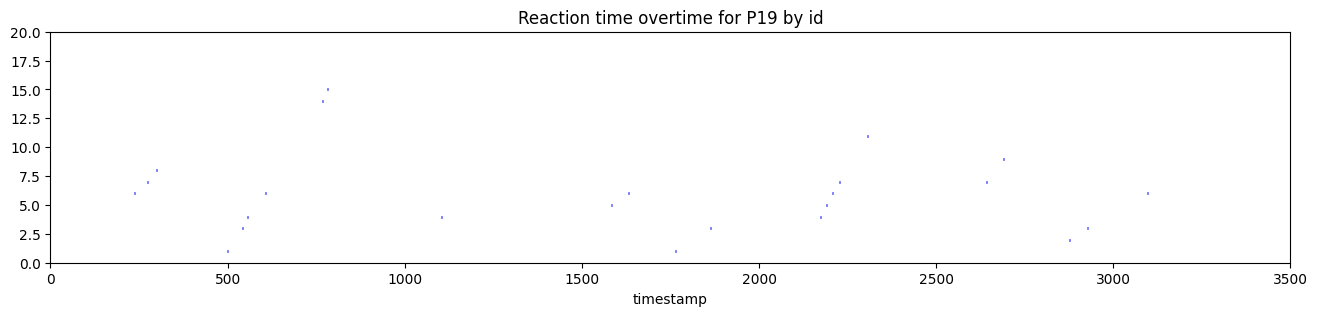

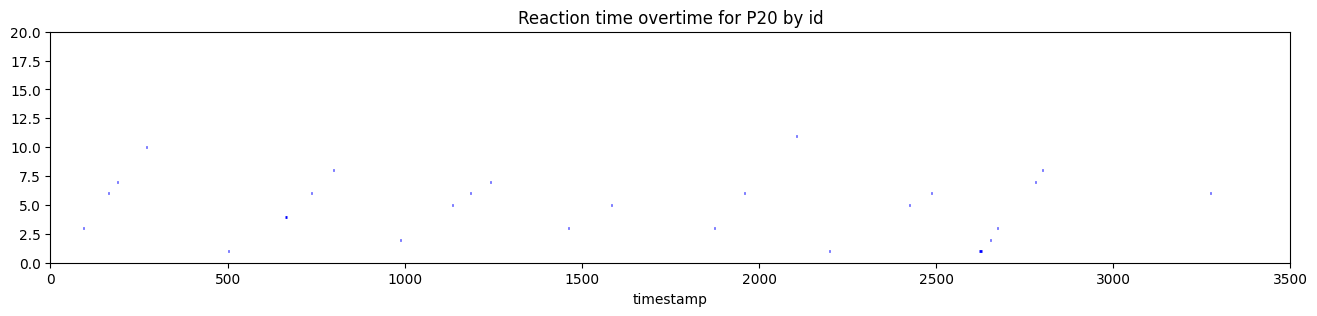

In [23]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(16, 3))
    for _, row in participant_df.iterrows():
        plt.hlines(y=row['task_id'], xmin=row['start_timestamp'], xmax=row['clicked_timestamp'], color='b', linewidth=2)
    plt.title(f'Reaction time overtime for P{pid} by id')
    plt.xlabel('timestamp')
    plt.xlim(0, 3500)
    plt.ylim(0, 20)
    plt.show()

##### Errors overtime 
- Good

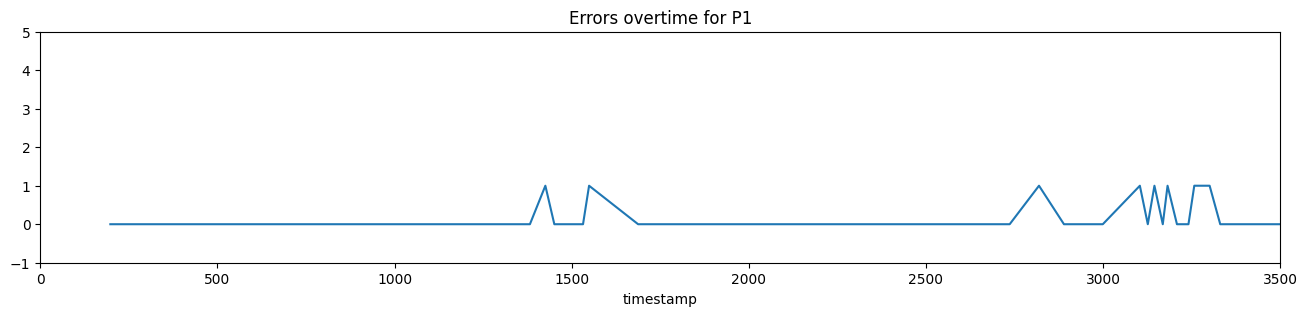

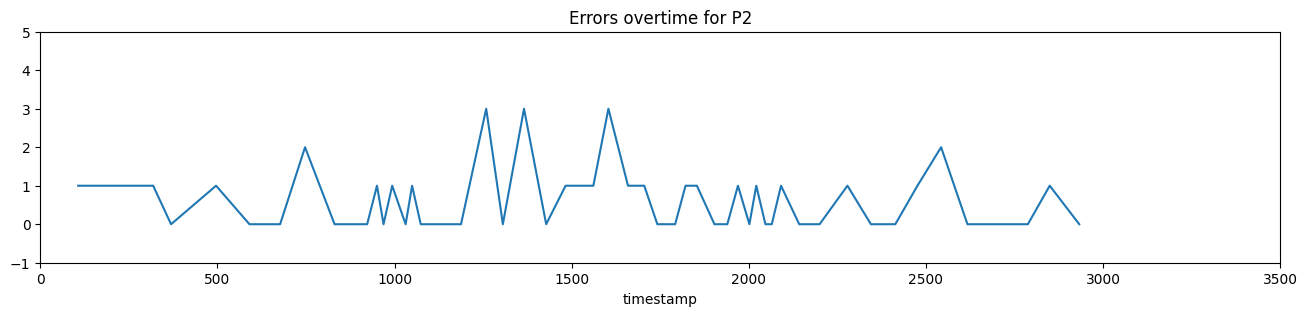

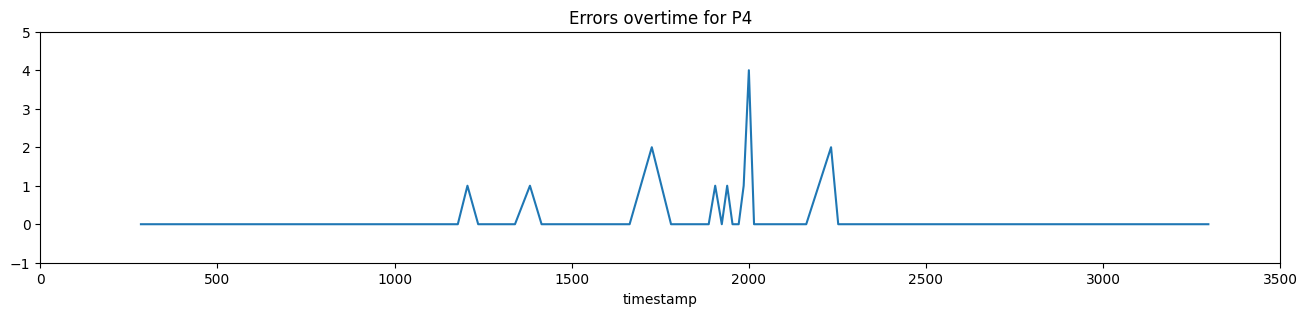

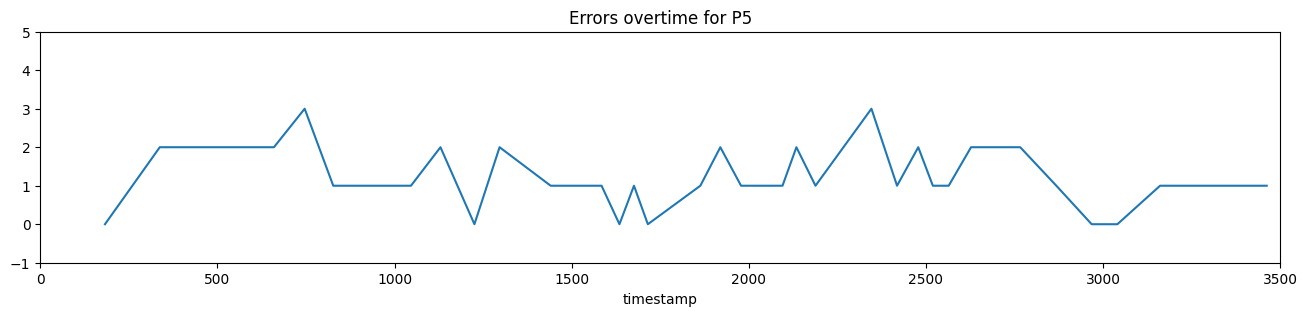

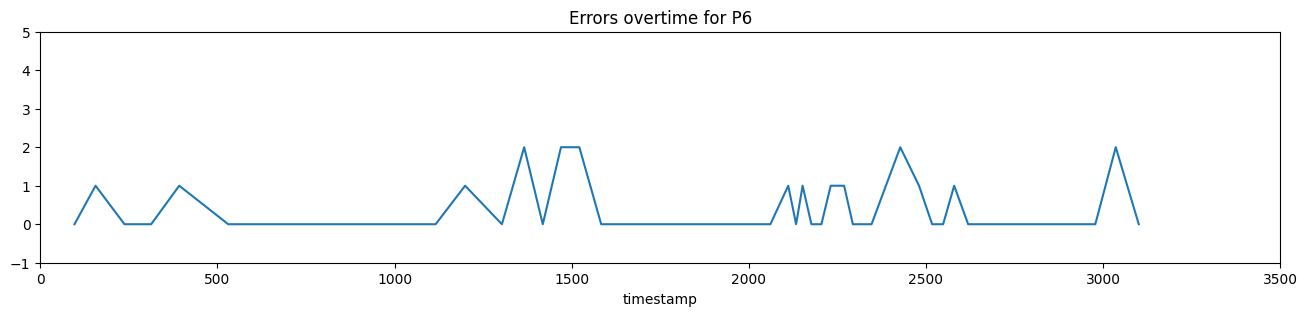

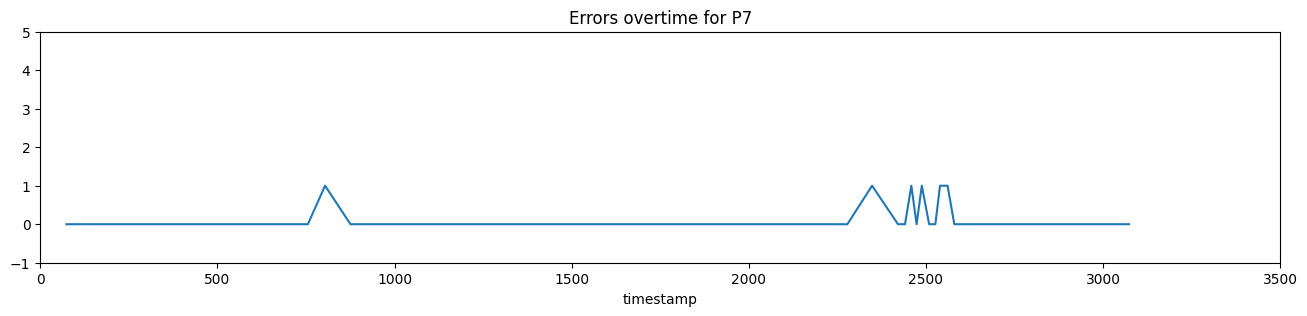

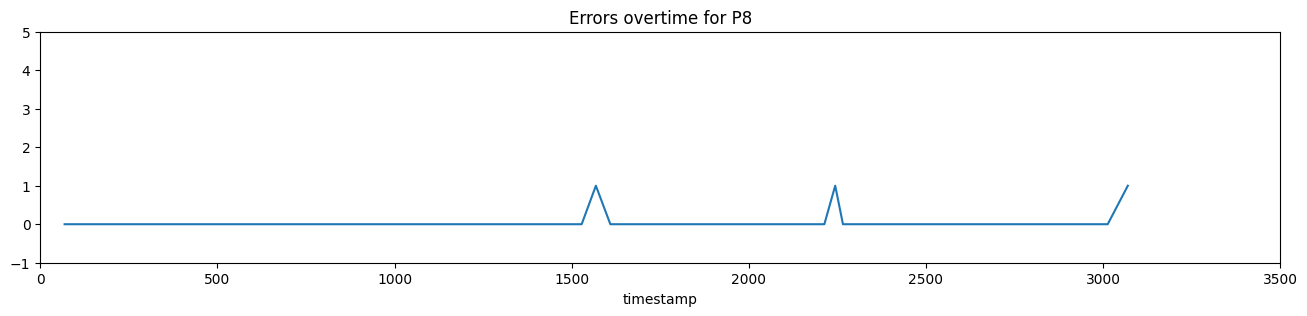

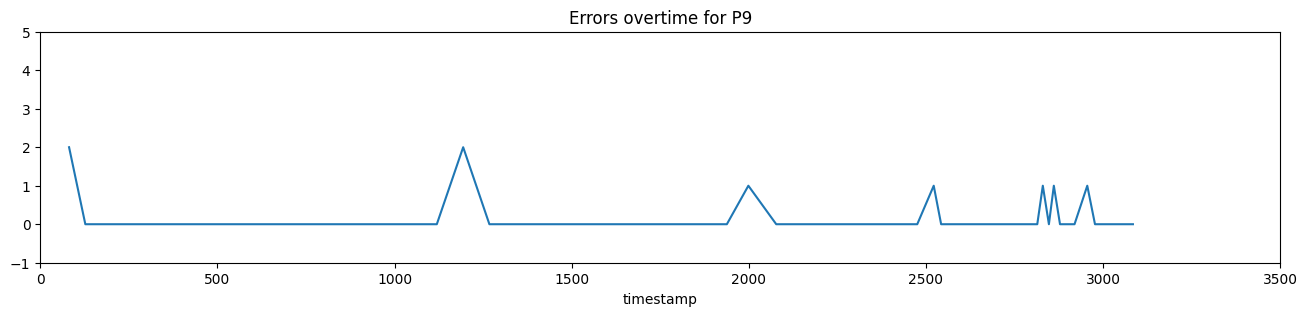

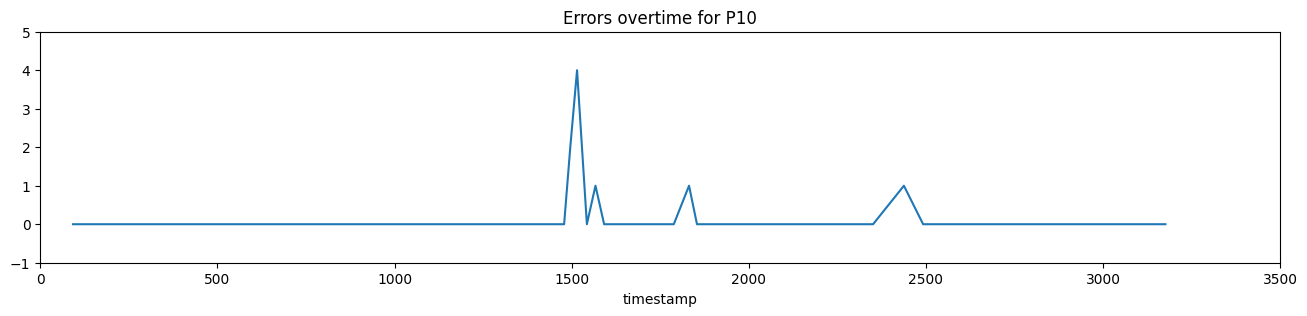

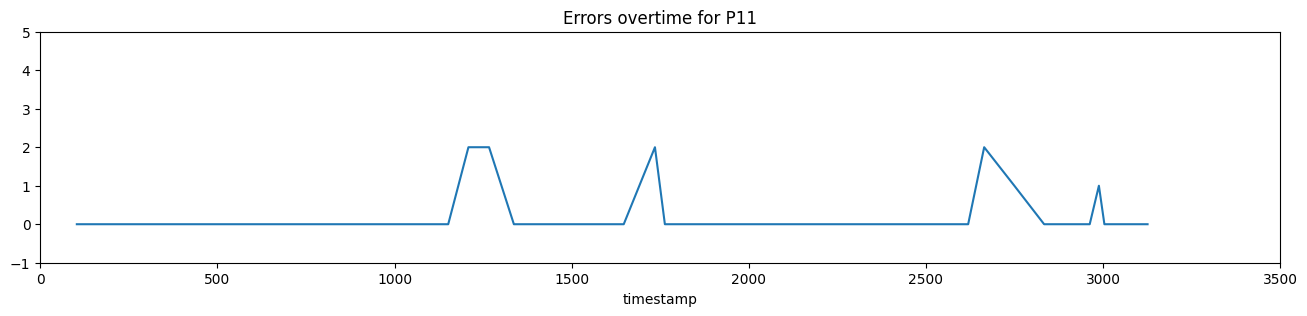

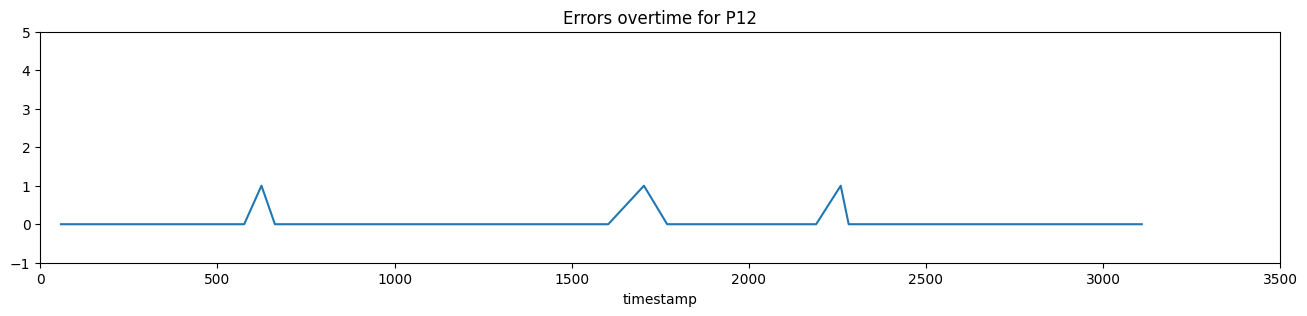

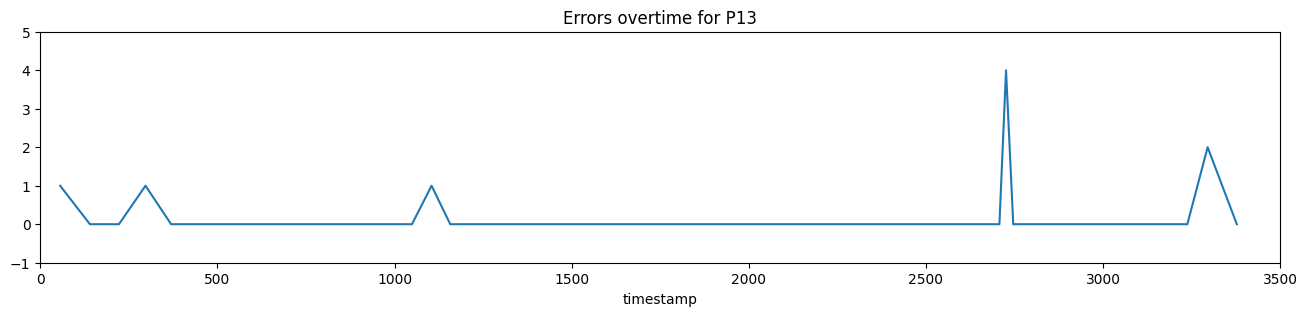

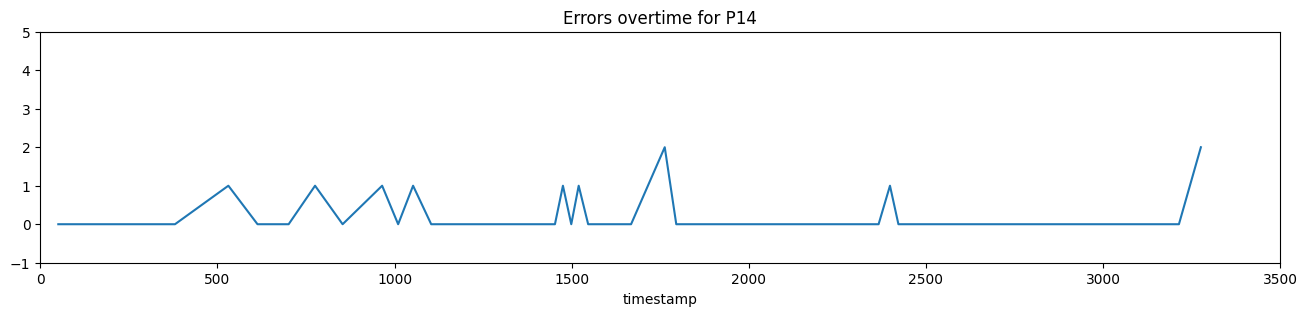

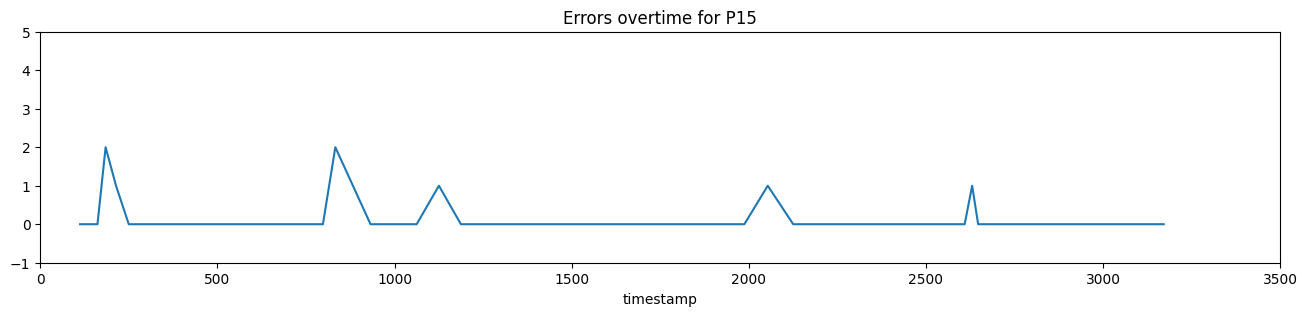

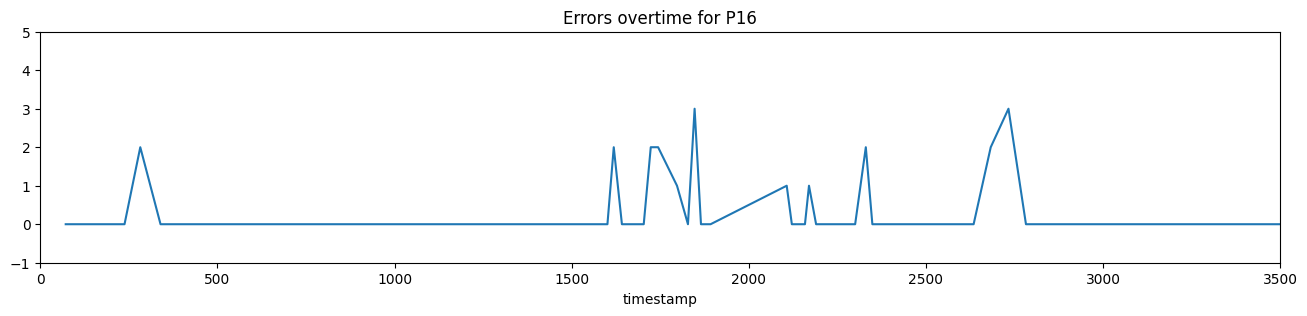

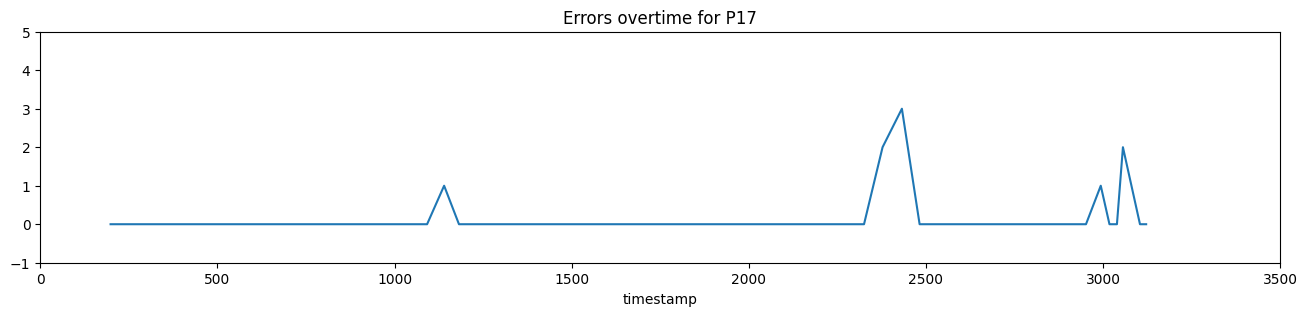

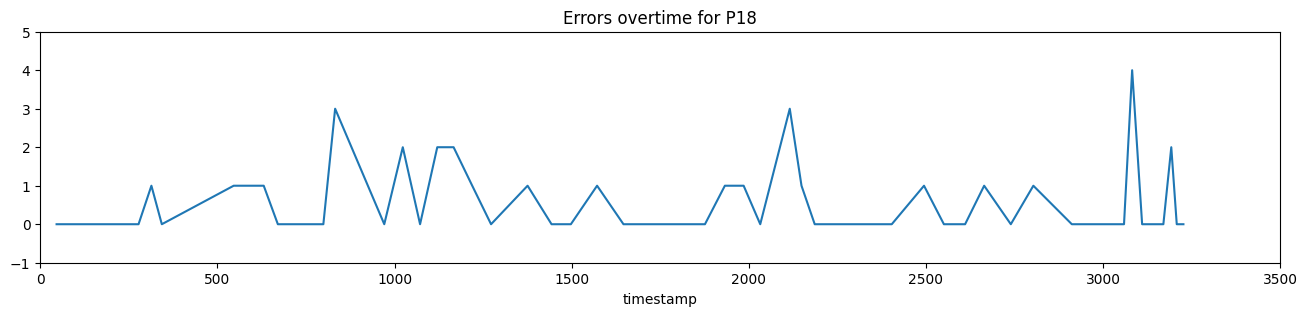

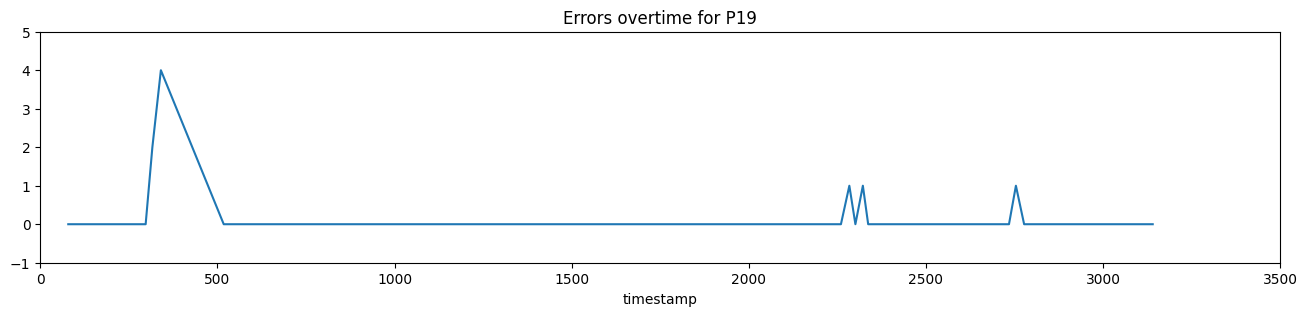

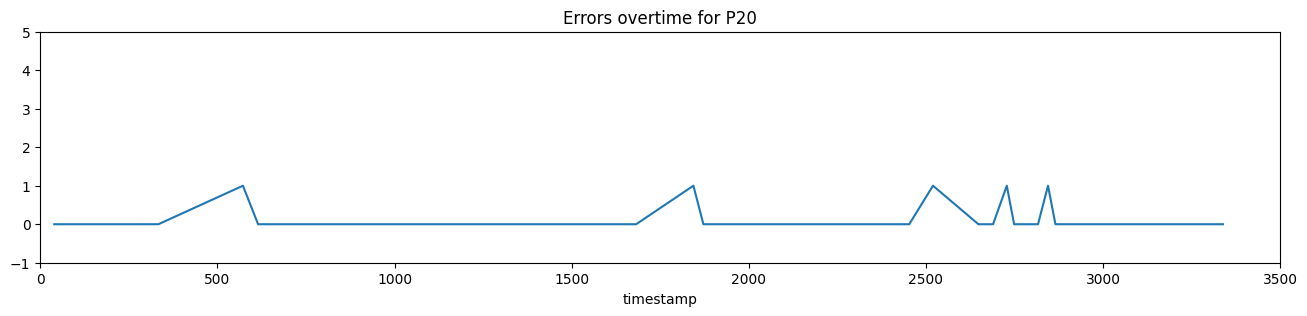

In [24]:
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid}")
    plt.figure(figsize=(16, 3))
    plt.plot(participant_df['end_timestamp'], participant_df['errors'])
    plt.title(f'Errors overtime for P{pid}')
    plt.xlabel('timestamp')
    plt.xlim(0, 3500)
    plt.ylim(-1, 5)
    plt.show()

### 4. Case-Specific Check-Ups
Long reaction time

##### Long reaction time (> 4)
- (...)

In [25]:
# Check how many RT > 4
print("Long reaction times by participant:")
for pid in participant_ids:
    participant_df = df.query(f"participant_id == {pid} and reaction_time >= 4")
    print(f"P{pid}: {len(participant_df)}") if len(participant_df) > 0 else None

Long reaction times by participant:
P1: 2
P2: 1
P6: 1
P20: 2


In [26]:
# Get RT > 4
RT_long = df.query("reaction_time >= 4") [['participant_id', 'block_id', 'task_id', 'reaction_time']]
RT_long

participant_id  block_id  task_id  reaction_time
1                  1         1        2       6.951172
13                 1         3        1       7.002806
70                 2         2        1       5.515906
250                6         2        1       7.796875
1275              20         3        6       5.001354
1300              20         7        1       8.175781

POSSIBLE INTERPRETATION:
- P01_b1_t2: distraction (high freq)
- P01_b3_t1: distraction + mouse slipped
- P02_b2_t1: mouse slipped
- P06_b2_t1: wrong click (right)
- P20_b3_t6: mouse slipped
- P20_b7_t1: distraction + mouse slipped

*slipped: slipped or lost track

FITTS LAW HAS TO BE TAKEN INTO CONSIDERATION, especially if mouse slipped or lost track

### 5. IV Analysis
Difficulty, Frequency, Difficulty+Frequency

Task coding (block_type column):
- easy & slow : 1, 5
- easy & fast : 2, 6
- hard & slow : 3, 7
- hard & fast : 4, 8

In [11]:
# Define variables
# Difficulty
easy_block = [1, 2, 5, 6]
hard_block = [3, 4, 7, 8]

# Frequency
slow_block = [1, 3, 5, 7]
fast_block = [2, 4, 6, 8]

# Difficulty+Frequency
easy_slow_block = [1, 5]
easy_fast_block = [2, 6]
hard_slow_block = [3, 7]
hard_fast_block = [4, 8]

##### Difficulty
- (...)

In [28]:
df_easy = df[df['block_type'].isin(easy_block)]
df_hard = df[df['block_type'].isin(hard_block)]

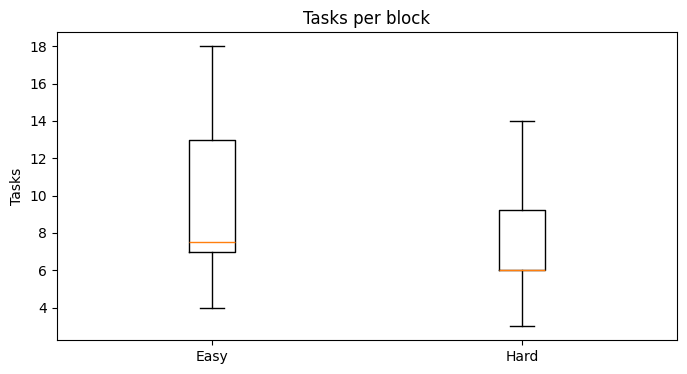

Easy: 9.88 tasks (~3.89)
Hard: 7.49 tasks (~2.68)


In [29]:
# Task per block
df_easy_grouped = df_easy.groupby(['participant_id', 'block_type'])
task_per_block_easy = []

for pid in participant_ids:
    for block_type in easy_block:
        try:
            tasks = df_easy_grouped.get_group((pid, block_type))
            task_per_block_easy.append(len(tasks))
        except KeyError:
            continue

df_hard_grouped = df_hard.groupby(['participant_id', 'block_type'])
task_per_block_hard = []

for pid in participant_ids:
    for block_type in hard_block:
        try:
            tasks = df_hard_grouped.get_group((pid, block_type))
            task_per_block_hard.append(len(tasks))
        except KeyError:
            continue

mean_easy = round(np.mean(task_per_block_easy), 2)
mean_hard = round(np.mean(task_per_block_hard), 2)
std_easy = round(np.std(task_per_block_easy), 2)
std_hard = round(np.std(task_per_block_hard), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([task_per_block_easy, task_per_block_hard], whis = 1.5)
plt.title(f'Tasks per block')
plt.xticks([1, 2], ['Easy', 'Hard'])
plt.ylabel('Tasks')
plt.show()

print(f"Easy: {np.mean(mean_easy)} tasks (~{std_easy})")
print(f"Hard: {np.mean(mean_hard)} tasks (~{std_hard})")

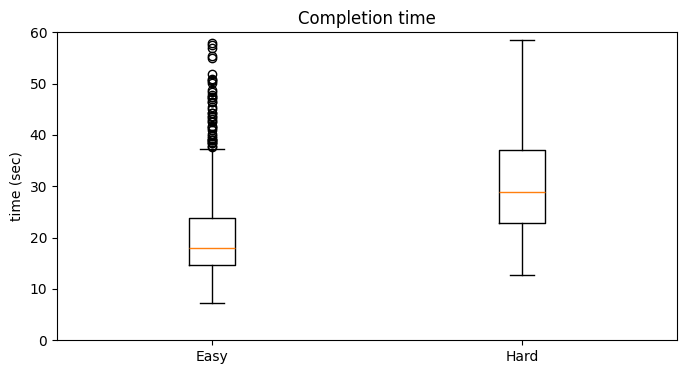

Easy: 20.46 seconds (~8.99)
Hard: 32.16 seconds (~15.0)


In [30]:
# Completion time
mean_easy = round(np.mean(df_easy['completion_time']), 2)
mean_hard = round(np.mean(df_hard['completion_time']), 2)
std_easy = round(np.std(df_easy['completion_time']), 2)
std_hard = round(np.std(df_hard['completion_time']), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([df_easy['completion_time'], df_hard['completion_time']], whis = 1.5)
plt.title(f'Completion time')
plt.xticks([1, 2], ['Easy', 'Hard'])
plt.ylabel('time (sec)')
plt.ylim(0, 60)
plt.show()

print(f"Easy: {np.mean(mean_easy)} seconds (~{std_easy})")
print(f"Hard: {np.mean(mean_hard)} seconds (~{std_hard})")



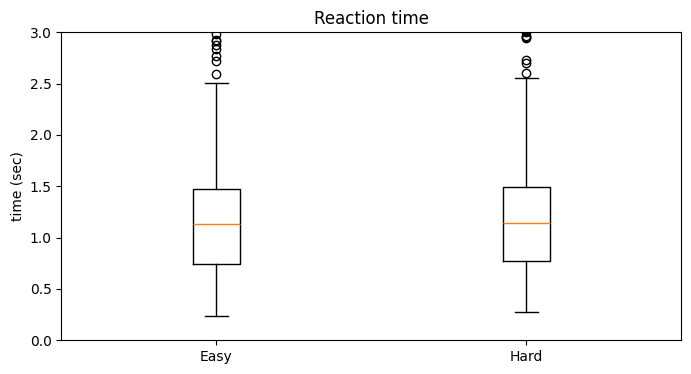

Easy: 1.19 seconds (~0.71)
Hard: 1.21 seconds (~0.65)


In [31]:
# Reaction time
mean_easy = round(np.mean(df_easy['reaction_time']), 2)
mean_hard = round(np.mean(df_hard['reaction_time']), 2)
std_easy = round(np.std(df_easy['reaction_time']), 2)
std_hard = round(np.std(df_hard['reaction_time']), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([df_easy['reaction_time'], df_hard['reaction_time']], whis = 1.5)
plt.title(f'Reaction time')
plt.xticks([1, 2], ['Easy', 'Hard'])
plt.ylabel('time (sec)')
plt.ylim(0, 3)
plt.show()

print(f"Easy: {np.mean(mean_easy)} seconds (~{std_easy})")
print(f"Hard: {np.mean(mean_hard)} seconds (~{std_hard})")

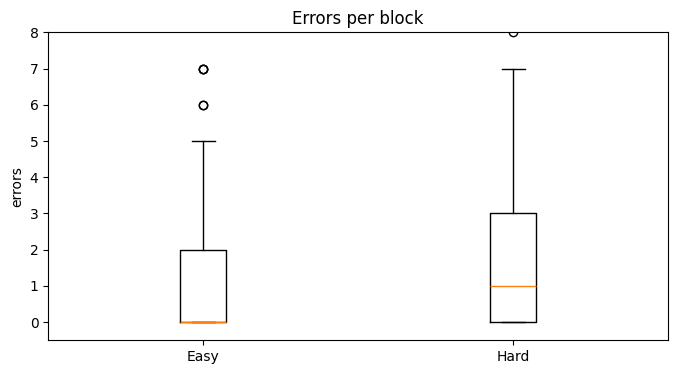

Easy: 1.49 errors (~2.2)
Hard: 2.0 errors (~2.32)


In [32]:
# Errors per block
df_easy_grouped = df_easy.groupby(['participant_id', 'block_type'])
error_per_block_easy = []

for pid in participant_ids:
    for block_type in easy_block:
        try:
            errors = df_easy_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_easy.append(errors)
        except KeyError:
            continue

df_hard_grouped = df_hard.groupby(['participant_id', 'block_type'])
error_per_block_hard = []

for pid in participant_ids:
    for block_type in hard_block:
        try:
            errors = df_hard_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_hard.append(errors)
        except KeyError:
            continue

mean_easy = round(np.mean(error_per_block_easy), 2)
mean_hard = round(np.mean(error_per_block_hard), 2)
std_easy = round(np.std(error_per_block_easy), 2)
std_hard = round(np.std(error_per_block_hard), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([error_per_block_easy, error_per_block_hard], whis = 1.5)
plt.title(f'Errors per block')
plt.xticks([1, 2], ['Easy', 'Hard'])
plt.ylabel('errors')
plt.ylim(-.5, 8)
plt.show()

print(f"Easy: {np.mean(mean_easy)} errors (~{std_easy})")
print(f"Hard: {np.mean(mean_hard)} errors (~{std_hard})")

##### Frequency
- (...)

In [33]:
df_slow = df[df['block_type'].isin(slow_block)]
df_fast = df[df['block_type'].isin(fast_block)]

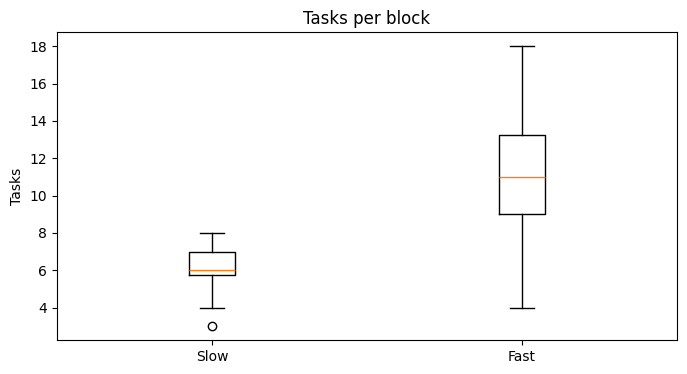

Slow: 6.03 tasks (~0.96)
Fast: 11.34 tasks (~3.19)


In [34]:
# Task per block
df_slow_grouped = df_slow.groupby(['participant_id', 'block_type'])
task_per_block_slow = []

for pid in participant_ids:
    for block_type in slow_block:
        try:
            tasks = df_slow_grouped.get_group((pid, block_type))
            task_per_block_slow.append(len(tasks))
        except KeyError:
            continue

df_fast_grouped = df_fast.groupby(['participant_id', 'block_type'])
task_per_block_fast = []

for pid in participant_ids:
    for block_type in fast_block:
        try:
            tasks = df_fast_grouped.get_group((pid, block_type))
            task_per_block_fast.append(len(tasks))
        except KeyError:
            continue

mean_slow = round(np.mean(task_per_block_slow), 2)
mean_fast = round(np.mean(task_per_block_fast), 2)
std_slow = round(np.std(task_per_block_slow), 2)
std_fast = round(np.std(task_per_block_fast), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([task_per_block_slow, task_per_block_fast], whis = 1.5)
plt.title(f'Tasks per block')
plt.xticks([1, 2], ['Slow', 'Fast'])
plt.ylabel('Tasks')
plt.show()

print(f"Slow: {np.mean(mean_slow)} tasks (~{std_slow})")
print(f"Fast: {np.mean(mean_fast)} tasks (~{std_fast})")

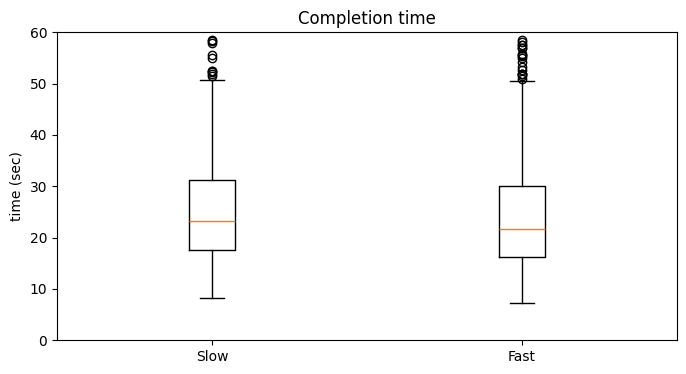

Slow: 26.85 seconds (~14.58)
Fast: 24.79 seconds (~12.48)


In [35]:
# Completion time
mean_slow = round(np.mean(df_slow['completion_time']), 2)
mean_fast = round(np.mean(df_fast['completion_time']), 2)
std_slow = round(np.std(df_slow['completion_time']), 2)
std_fast = round(np.std(df_fast['completion_time']), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([df_slow['completion_time'], df_fast['completion_time']], whis = 1.5)
plt.title(f'Completion time')
plt.xticks([1, 2], ['Slow', 'Fast'])
plt.ylabel('time (sec)')
plt.ylim(0, 60)
plt.show()

print(f"Slow: {np.mean(mean_slow)} seconds (~{std_slow})")
print(f"Fast: {np.mean(mean_fast)} seconds (~{std_fast})")



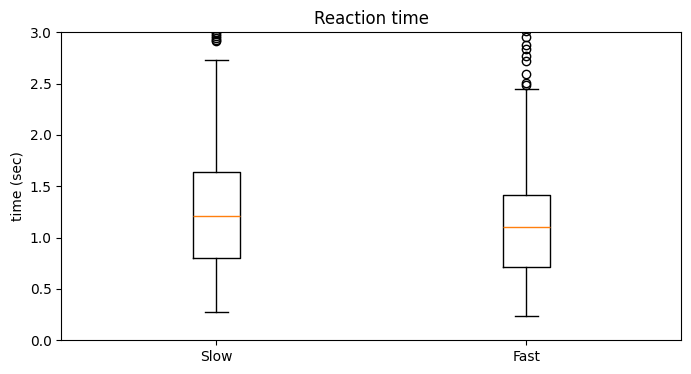

Slow: 1.29 seconds (~0.65)
Fast: 1.15 seconds (~0.69)


In [36]:
# Reaction time
mean_slow = round(np.mean(df_slow['reaction_time']), 2)
mean_fast = round(np.mean(df_fast['reaction_time']), 2)
std_slow = round(np.std(df_slow['reaction_time']), 2)
std_fast = round(np.std(df_fast['reaction_time']), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([df_slow['reaction_time'], df_fast['reaction_time']], whis = 1.5)
plt.title(f'Reaction time')
plt.xticks([1, 2], ['Slow', 'Fast'])
plt.ylabel('time (sec)')
plt.ylim(0, 3)
plt.show()

print(f"Slow: {np.mean(mean_slow)} seconds (~{std_slow})")
print(f"Fast: {np.mean(mean_fast)} seconds (~{std_fast})")

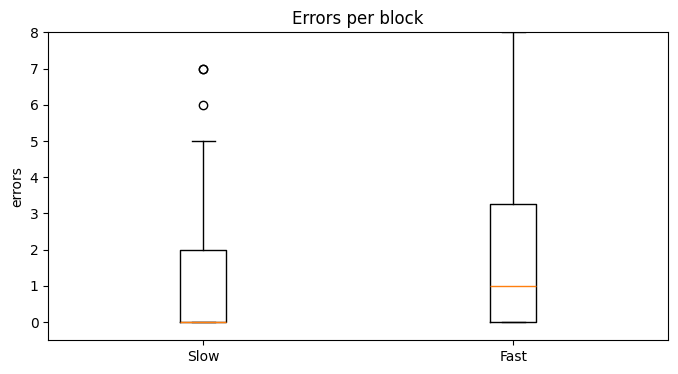

Slow: 1.28 errors (~1.81)
Fast: 2.21 errors (~2.58)


In [37]:
# Errors per block
df_slow_grouped = df_slow.groupby(['participant_id', 'block_type'])
error_per_block_slow = []

for pid in participant_ids:
    for block_type in slow_block:
        try:
            errors = df_slow_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_slow.append(errors)
        except KeyError:
            continue

df_fast_grouped = df_fast.groupby(['participant_id', 'block_type'])
error_per_block_fast = []

for pid in participant_ids:
    for block_type in fast_block:
        try:
            errors = df_fast_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_fast.append(errors)
        except KeyError:
            continue

mean_slow = round(np.mean(error_per_block_slow), 2)
mean_fast = round(np.mean(error_per_block_fast), 2)
std_slow = round(np.std(error_per_block_slow), 2)
std_fast = round(np.std(error_per_block_fast), 2)

plt.figure(figsize=(8, 4))
plt.boxplot([error_per_block_slow, error_per_block_fast], whis = 1.5)
plt.title(f'Errors per block')
plt.xticks([1, 2], ['Slow', 'Fast'])
plt.ylabel('errors')
plt.ylim(-.5, 8)
plt.show()

print(f"Slow: {np.mean(mean_slow)} errors (~{std_slow})")
print(f"Fast: {np.mean(mean_fast)} errors (~{std_fast})")

##### Difficulty+Frequency
- (...)

In [12]:
df_easy_slow = df[df['block_type'].isin(easy_slow_block)]
df_easy_fast = df[df['block_type'].isin(easy_fast_block)]
df_hard_slow = df[df['block_type'].isin(hard_slow_block)]
df_hard_fast = df[df['block_type'].isin(hard_fast_block)]

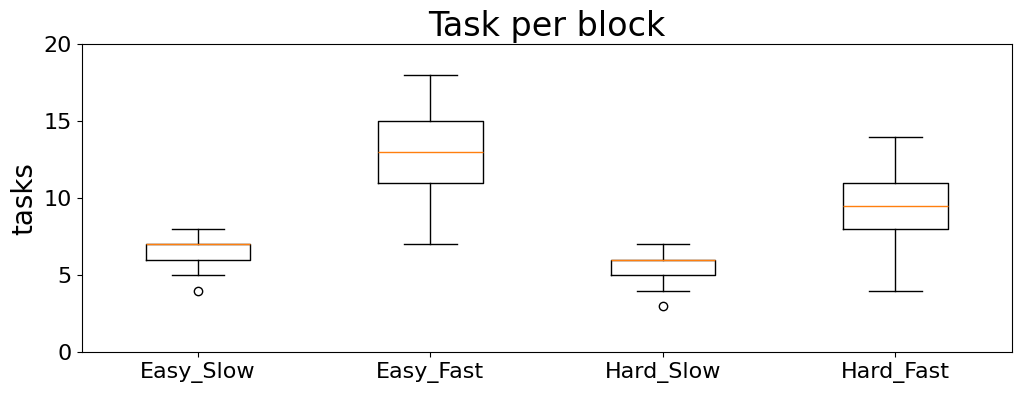

Easy_Slow: 6.58 tasks (~0.75)
Easy_Fast: 13.18 tasks (~2.81)
Hard_Slow: 5.47 tasks (~0.82)
Hard_Fast: 9.5 tasks (~2.37)


In [22]:
# Task per block
df_easy_slow_grouped = df_easy_slow.groupby(['participant_id', 'block_type'])
task_per_block_easy_slow = []

for pid in participant_ids:
    for block_type in easy_slow_block:
        try:
            tasks = df_easy_slow_grouped.get_group((pid, block_type))
            task_per_block_easy_slow.append(len(tasks))
        except KeyError:
            continue

df_easy_fast_grouped = df_easy_fast.groupby(['participant_id', 'block_type'])
task_per_block_easy_fast = []

for pid in participant_ids:
    for block_type in easy_fast_block:
        try:
            tasks = df_easy_fast_grouped.get_group((pid, block_type))
            task_per_block_easy_fast.append(len(tasks))
        except KeyError:
            continue

df_hard_slow_grouped = df_hard_slow.groupby(['participant_id', 'block_type'])
task_per_block_hard_slow = []

for pid in participant_ids:
    for block_type in hard_slow_block:
        try:
            tasks = df_hard_slow_grouped.get_group((pid, block_type))
            task_per_block_hard_slow.append(len(tasks))
        except KeyError:
            continue

df_hard_fast_grouped = df_hard_fast.groupby(['participant_id', 'block_type'])
task_per_block_hard_fast = []

for pid in participant_ids:
    for block_type in hard_fast_block:
        try:
            tasks = df_hard_fast_grouped.get_group((pid, block_type))
            task_per_block_hard_fast.append(len(tasks))
        except KeyError:
            continue

mean_easy_slow = round(np.mean(task_per_block_easy_slow), 2)
mean_easy_fast = round(np.mean(task_per_block_easy_fast), 2)
std_easy_slow = round(np.std(task_per_block_easy_slow), 2)
std_easy_fast = round(np.std(task_per_block_easy_fast), 2)
mean_hard_slow = round(np.mean(task_per_block_hard_slow), 2)
mean_hard_fast = round(np.mean(task_per_block_hard_fast), 2)
std_hard_slow = round(np.std(task_per_block_hard_slow), 2)
std_hard_fast = round(np.std(task_per_block_hard_fast), 2)

plt.figure(figsize=(12, 4))
plt.boxplot([task_per_block_easy_slow, task_per_block_easy_fast, task_per_block_hard_slow, task_per_block_hard_fast], whis = 1.5)
plt.title(f'Task per block', fontsize=24)
plt.xticks([1, 2, 3, 4], ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], fontsize=16)
plt.ylabel('tasks', fontsize=20)
plt.ylim(0, 20)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()

print(f"Easy_Slow: {np.mean(mean_easy_slow)} tasks (~{std_easy_slow})")
print(f"Easy_Fast: {np.mean(mean_easy_fast)} tasks (~{std_easy_fast})")
print(f"Hard_Slow: {np.mean(mean_hard_slow)} tasks (~{std_hard_slow})")
print(f"Hard_Fast: {np.mean(mean_hard_fast)} tasks (~{std_hard_fast})")

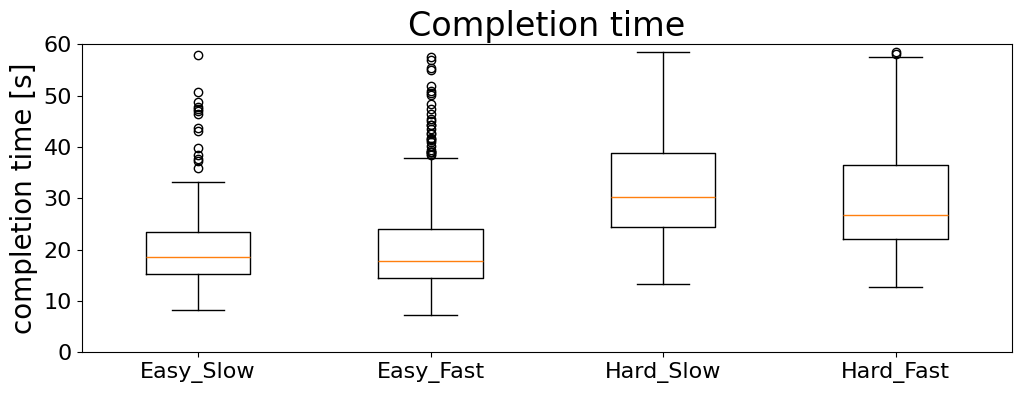

Easy_Slow: 20.58 seconds (~8.45)
Easy_Fast: 20.41 seconds (~9.25)
Hard_Slow: 34.39 seconds (~16.69)
Hard_Fast: 30.87 seconds (~13.77)


In [17]:
# Completion time
mean_easy_slow = round(np.mean(df_easy_slow['completion_time']), 2)
mean_easy_fast = round(np.mean(df_easy_fast['completion_time']), 2)
std_easy_slow = round(np.std(df_easy_slow['completion_time']), 2)
std_easy_fast = round(np.std(df_easy_fast['completion_time']), 2)
mean_hard_slow = round(np.mean(df_hard_slow['completion_time']), 2)
mean_hard_fast = round(np.mean(df_hard_fast['completion_time']), 2)
std_hard_slow = round(np.std(df_hard_slow['completion_time']), 2)
std_hard_fast = round(np.std(df_hard_fast['completion_time']), 2)

plt.figure(figsize=(12, 4))
plt.boxplot([df_easy_slow['completion_time'], df_easy_fast['completion_time'], df_hard_slow['completion_time'], df_hard_fast['completion_time']], whis = 1.5)
plt.title(f'Completion time', fontsize=24)
plt.xticks([1, 2, 3, 4], ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], fontsize=16)
plt.ylabel('completion time [s]', fontsize=20)
plt.ylim(0, 60)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()

print(f"Easy_Slow: {np.mean(mean_easy_slow)} seconds (~{std_easy_slow})")
print(f"Easy_Fast: {np.mean(mean_easy_fast)} seconds (~{std_easy_fast})")
print(f"Hard_Slow: {np.mean(mean_hard_slow)} seconds (~{std_hard_slow})")
print(f"Hard_Fast: {np.mean(mean_hard_fast)} seconds (~{std_hard_fast})")

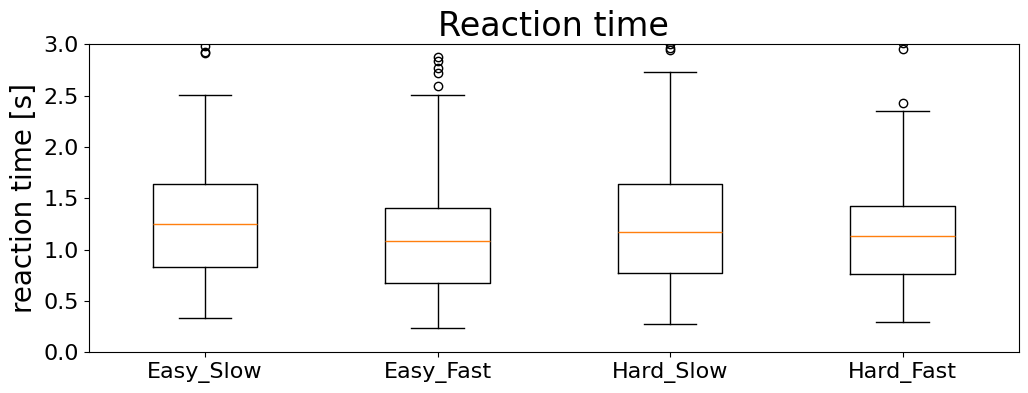

Easy_Slow: 1.31 seconds (~0.64)
Easy_Fast: 1.14 seconds (~0.73)
Hard_Slow: 1.27 seconds (~0.66)
Hard_Fast: 1.17 seconds (~0.63)


In [23]:
# Reaction time
mean_easy_slow = round(np.mean(df_easy_slow['reaction_time']), 2)
mean_easy_fast = round(np.mean(df_easy_fast['reaction_time']), 2)
std_easy_slow = round(np.std(df_easy_slow['reaction_time']), 2)
std_easy_fast = round(np.std(df_easy_fast['reaction_time']), 2)
mean_hard_slow = round(np.mean(df_hard_slow['reaction_time']), 2)
mean_hard_fast = round(np.mean(df_hard_fast['reaction_time']), 2)
std_hard_slow = round(np.std(df_hard_slow['reaction_time']), 2)
std_hard_fast = round(np.std(df_hard_fast['reaction_time']), 2)

plt.figure(figsize=(12, 4))
plt.boxplot([df_easy_slow['reaction_time'], df_easy_fast['reaction_time'], df_hard_slow['reaction_time'], df_hard_fast['reaction_time']], whis = 1.5)
plt.title(f'Reaction time', fontsize=24)
plt.xticks([1, 2, 3, 4], ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], fontsize=16)
plt.ylabel('reaction time [s]', fontsize=20)
plt.ylim(0, 3)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()

print(f"Easy_Slow: {np.mean(mean_easy_slow)} seconds (~{std_easy_slow})")
print(f"Easy_Fast: {np.mean(mean_easy_fast)} seconds (~{std_easy_fast})")
print(f"Hard_Slow: {np.mean(mean_hard_slow)} seconds (~{std_hard_slow})")
print(f"Hard_Fast: {np.mean(mean_hard_fast)} seconds (~{std_hard_fast})")

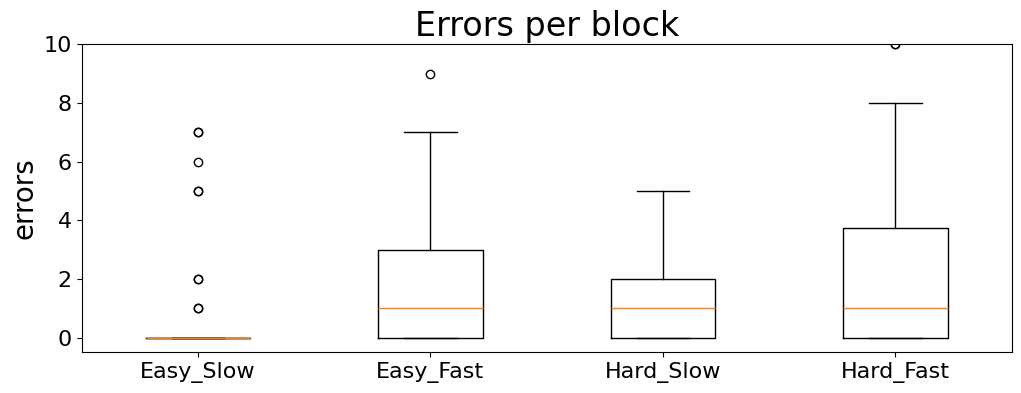

Easy_Slow: 0.95 errors (~2.05)
Easy_Fast: 2.03 errors (~2.22)
Hard_Slow: 1.61 errors (~1.46)
Hard_Fast: 2.39 errors (~2.88)


In [27]:
# Error per block
df_easy_slow_grouped = df_easy_slow.groupby(['participant_id', 'block_type'])
error_per_block_easy_slow = []
for pid in participant_ids:
    for block_type in easy_slow_block:
        try:
            errors = df_easy_slow_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_easy_slow.append(errors)
        except KeyError:
            continue

df_easy_fast_grouped = df_easy_fast.groupby(['participant_id', 'block_type'])
error_per_block_easy_fast = []
for pid in participant_ids:
    for block_type in easy_fast_block:
        try:
            errors = df_easy_fast_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_easy_fast.append(errors)
        except KeyError:
            continue

df_hard_slow_grouped = df_hard_slow.groupby(['participant_id', 'block_type'])
error_per_block_hard_slow = []
for pid in participant_ids:
    for block_type in hard_slow_block:
        try:
            errors = df_hard_slow_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_hard_slow.append(errors)
        except KeyError:
            continue

df_hard_fast_grouped = df_hard_fast.groupby(['participant_id', 'block_type'])
error_per_block_hard_fast = []
for pid in participant_ids:
    for block_type in hard_fast_block:
        try:
            errors = df_hard_fast_grouped.get_group((pid, block_type))['errors'].sum()
            error_per_block_hard_fast.append(errors)
        except KeyError:
            continue

mean_easy_slow = round(np.mean(error_per_block_easy_slow), 2)
mean_easy_fast = round(np.mean(error_per_block_easy_fast), 2)
std_easy_slow = round(np.std(error_per_block_easy_slow), 2)
std_easy_fast = round(np.std(error_per_block_easy_fast), 2)
mean_hard_slow = round(np.mean(error_per_block_hard_slow), 2)
mean_hard_fast = round(np.mean(error_per_block_hard_fast), 2)
std_hard_slow = round(np.std(error_per_block_hard_slow), 2)
std_hard_fast = round(np.std(error_per_block_hard_fast), 2)

plt.figure(figsize=(12, 4))
plt.boxplot([error_per_block_easy_slow, error_per_block_easy_fast, error_per_block_hard_slow, error_per_block_hard_fast], whis = 1.5)
plt.title(f'Errors per block', fontsize=24)
plt.xticks([1, 2, 3, 4], ['Easy_Slow', 'Easy_Fast', 'Hard_Slow', 'Hard_Fast'], fontsize=16)
plt.ylabel('errors', fontsize=20)
plt.ylim(-.5, 10)
plt.tick_params(axis='y', which='major', labelsize=16)
plt.show()

print(f"Easy_Slow: {np.mean(mean_easy_slow)} errors (~{std_easy_slow})")
print(f"Easy_Fast: {np.mean(mean_easy_fast)} errors (~{std_easy_fast})")
print(f"Hard_Slow: {np.mean(mean_hard_slow)} errors (~{std_hard_slow})")
print(f"Hard_Fast: {np.mean(mean_hard_fast)} errors (~{std_hard_fast})")